## Описание проекта:

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 

### Задача проекта: 

научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента спортклуба;

сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;

проанализировать основные признаки, наиболее сильно влияющие на отток;

сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1) выделить целевые группы клиентов;

2) предложить меры по снижению оттока;

3) определить другие особенности взаимодействия с клиентами.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import itertools
import operator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

%config InlineBackend.figure_format = 'retina'

## Описание данных:

**Данные клиента за предыдущий до проверки факта оттока месяц:**

- 'gender' — пол;

- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;

- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи-сотрудники могут получать скидки на абонемент - в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

- 'Churn' — факт оттока в текущем месяце (клиент не посещал клуб)

## Обработка данных

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')

## Обзор данных

- набор данных небольшой (4000 записей, 14 полей)
- пробелов нет
- дубликатов нет
- все поля числовые, нет необходимости преобразовывать
- типы полей не нужно менять
- gender - баланс нормальный (51% /49%)
- контракты - есть на 1, 6 и 12 месяцев
- near location - 84% клиентов живут рядом
- 30% использовали промо-код при первой записи
- у 10% нет контактного телефона
- 75% оформили контракт на 6 месяцев и меньше
- **59% не посещали групповые занятия ни разу**
- **при этом минимум половина клиентов посещает по 1.8 занятия в неделю. Нестыковка.**
- **по посещению групповых занятий среднее практически совпадает с медианой**
- средний возраст 29 лет, максимум - 41 год
- у всех есть дополнительные платы (почему?)
- минимум у половины клиентов контракт заканчивается через месяц
- не менее 25% клиентов не посещали занятия в текущем месяце
- **в наборе данных очень не хватает ID клиента. Подавляющее большинство контрактов на 1 месяц, при этом непонятно, их покупают одни и те же люди или разные. Может быть у них просто слишком хорошие условия при покупке на один месяц и поэтому клиенты просто короткие контракты докупают постоянно**

In [3]:
# функция для обзора файлов с данными

def overview(files):
    # для каждого файла показать sample, info
    for i in files:
        display (i.sample(5))
        print()
        display (i.info())
    # для каждой колонки показать describe и топ значений
        for j in range(0, i.shape[1]):
            print('DESCRIBE: ',i.iloc[:,j].name )
            display (i.iloc[:,j].describe().to_frame().T)
            print('TOP VALUES:', i.iloc[:,j].name )
            display (i.iloc[:,j].value_counts().head())
        print('---------------------------------------')


In [4]:
overview([data])

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
338        0              1        0              0      1                1   
2589       0              1        1              1      1               12   
2748       1              1        0              0      1                1   
1195       1              1        0              0      1                6   
1199       1              1        1              0      0                6   

      Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
338              0   25                     22.483669                    1.0   
2589             1   34                    264.990288                   12.0   
2748             0   29                    174.056002                    1.0   
1195             0   33                    173.464312                    3.0   
1199             1   22                    273.479474                    5.0   

      Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
338          0                   1.270843                           0.778388   
2589         5                   2.759221                           2.808485   
2748         0                   1.356686                           0.934886   
1195         5                   3.994194                           4.014589   
1199         2                   1.052673                           1.025595   

      Churn  
338       1  
2589      0  
2748      1  
1195      0  
1199      0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   floa

None

DESCRIBE:  gender


count     mean       std  min  25%  50%  75%  max
gender  4000.0  0.51025  0.499957  0.0  0.0  1.0  1.0  1.0

TOP VALUES: gender


1    2041
0    1959
Name: gender, dtype: int64

DESCRIBE:  Near_Location


count     mean       std  min  25%  50%  75%  max
Near_Location  4000.0  0.84525  0.361711  0.0  1.0  1.0  1.0  1.0

TOP VALUES: Near_Location


1    3381
0     619
Name: Near_Location, dtype: int64

DESCRIBE:  Partner


count     mean       std  min  25%  50%  75%  max
Partner  4000.0  0.48675  0.499887  0.0  0.0  0.0  1.0  1.0

TOP VALUES: Partner


0    2053
1    1947
Name: Partner, dtype: int64

DESCRIBE:  Promo_friends


count    mean       std  min  25%  50%  75%  max
Promo_friends  4000.0  0.3085  0.461932  0.0  0.0  0.0  1.0  1.0

TOP VALUES: Promo_friends


0    2766
1    1234
Name: Promo_friends, dtype: int64

DESCRIBE:  Phone


count    mean       std  min  25%  50%  75%  max
Phone  4000.0  0.9035  0.295313  0.0  1.0  1.0  1.0  1.0

TOP VALUES: Phone


1    3614
0     386
Name: Phone, dtype: int64

DESCRIBE:  Contract_period


count     mean       std  min  25%  50%  75%   max
Contract_period  4000.0  4.68125  4.549706  1.0  1.0  1.0  6.0  12.0

TOP VALUES: Contract_period


1     2207
12     960
6      833
Name: Contract_period, dtype: int64

DESCRIBE:  Group_visits


count     mean       std  min  25%  50%  75%  max
Group_visits  4000.0  0.41225  0.492301  0.0  0.0  0.0  1.0  1.0

TOP VALUES: Group_visits


0    2351
1    1649
Name: Group_visits, dtype: int64

DESCRIBE:  Age


count      mean       std   min   25%   50%   75%   max
Age  4000.0  29.18425  3.258367  18.0  27.0  29.0  31.0  41.0

TOP VALUES: Age


29    468
30    457
28    447
31    434
27    378
Name: Age, dtype: int64

DESCRIBE:  Avg_additional_charges_total


count        mean        std       min  \
Avg_additional_charges_total  4000.0  146.943728  96.355602  0.148205   

                                   25%         50%         75%        max  
Avg_additional_charges_total  68.86883  136.220159  210.949625  552.59074

TOP VALUES: Avg_additional_charges_total


89.952762     1
174.658455    1
122.765563    1
204.444527    1
50.813166     1
Name: Avg_additional_charges_total, dtype: int64

DESCRIBE:  Month_to_end_contract


count     mean       std  min  25%  50%  75%   max
Month_to_end_contract  4000.0  4.32275  4.191297  1.0  1.0  1.0  6.0  12.0

TOP VALUES: Month_to_end_contract


1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
Name: Month_to_end_contract, dtype: int64

DESCRIBE:  Lifetime


count     mean       std  min  25%  50%  75%   max
Lifetime  4000.0  3.72475  3.749267  0.0  1.0  3.0  5.0  31.0

TOP VALUES: Lifetime


1    843
2    610
3    490
0    487
4    383
Name: Lifetime, dtype: int64

DESCRIBE:  Avg_class_frequency_total


count     mean       std  min       25%       50%  \
Avg_class_frequency_total  4000.0  1.87902  0.972245  0.0  1.180875  1.832768   

                                75%       max  
Avg_class_frequency_total  2.536078  6.023668

TOP VALUES: Avg_class_frequency_total


0.000000    88
0.827058     1
2.770845     1
1.472779     1
3.735185     1
Name: Avg_class_frequency_total, dtype: int64

DESCRIBE:  Avg_class_frequency_current_month


count      mean       std  min       25%  \
Avg_class_frequency_current_month  4000.0  1.767052  1.052906  0.0  0.963003   

                                        50%       75%       max  
Avg_class_frequency_current_month  1.719574  2.510336  6.146783

TOP VALUES: Avg_class_frequency_current_month


0.000000    181
0.379235      1
0.054540      1
1.877288      1
1.058906      1
Name: Avg_class_frequency_current_month, dtype: int64

DESCRIBE:  Churn


count     mean       std  min  25%  50%  75%  max
Churn  4000.0  0.26525  0.441521  0.0  0.0  0.0  1.0  1.0

TOP VALUES: Churn


0    2939
1    1061
Name: Churn, dtype: int64

---------------------------------------


Дубликаты в данных отсутствуют

In [5]:
data.duplicated().sum()

0

### Исследовательский анализ данных

#### Задание: Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [6]:
print ('\nсредние значения показателей для клиентов, которые остались и для клиентов, которые ушли \nи % разница между ними')

display (
    data
    .groupby('Churn').mean()
    .T.reset_index()
    .assign(diff = lambda x: (x[0] - x[1])/x[1])
    .rename(columns = {0:'остались', 1:'ушли'})
    .sort_values(by = 'diff', ascending = False)
    .style
    .format('{0:,.0%}', subset='diff')
    .bar(subset='diff', color = 'gold')
)



средние значения показателей для клиентов, которые остались и для клиентов, которые ушли 
и % разница между ними


Снова видим, что уходят клиенты с коротким лайфтаймом, короткими контрактами и малым временем до окончания контракта

**Построим графики для интересных колонок**

In [7]:
def hist_n_box (df, cols):
#функция строит гистограмму и горизонтальный боксплот рядом
    for i in cols:
        if df[i].count() > 50000:
            bins = 100
        else: 
            bins = 50
        fig = plt.figure(figsize=(12,4))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        ax1.hist(x=i, data=df, bins=bins)
        #показывает медиану и среднее
        ax2.boxplot(x=i, data=df[df[i].isna() == False], vert=False, showmeans=True)
        ax2.set_ylabel(i)
        fig.suptitle(i);

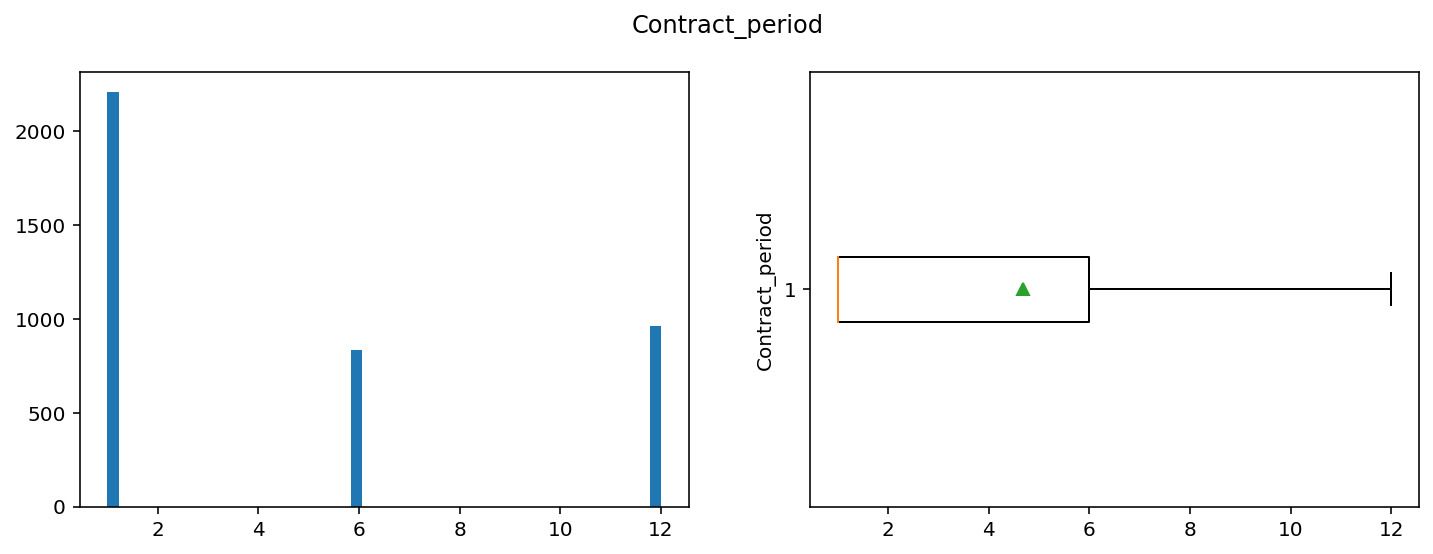

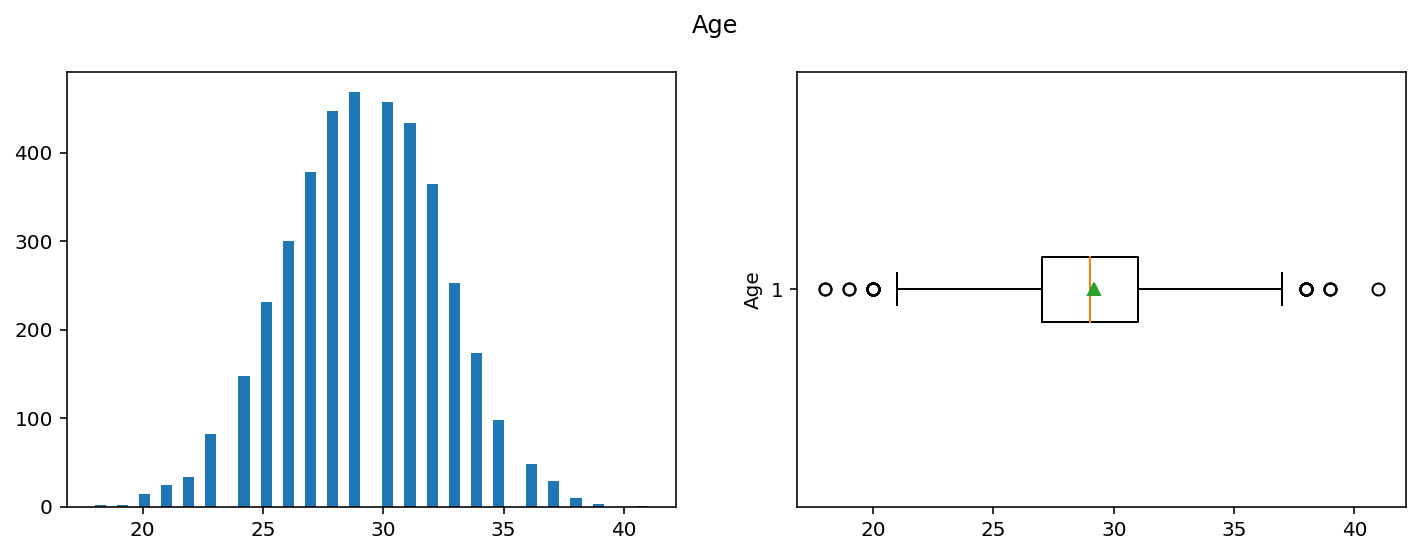

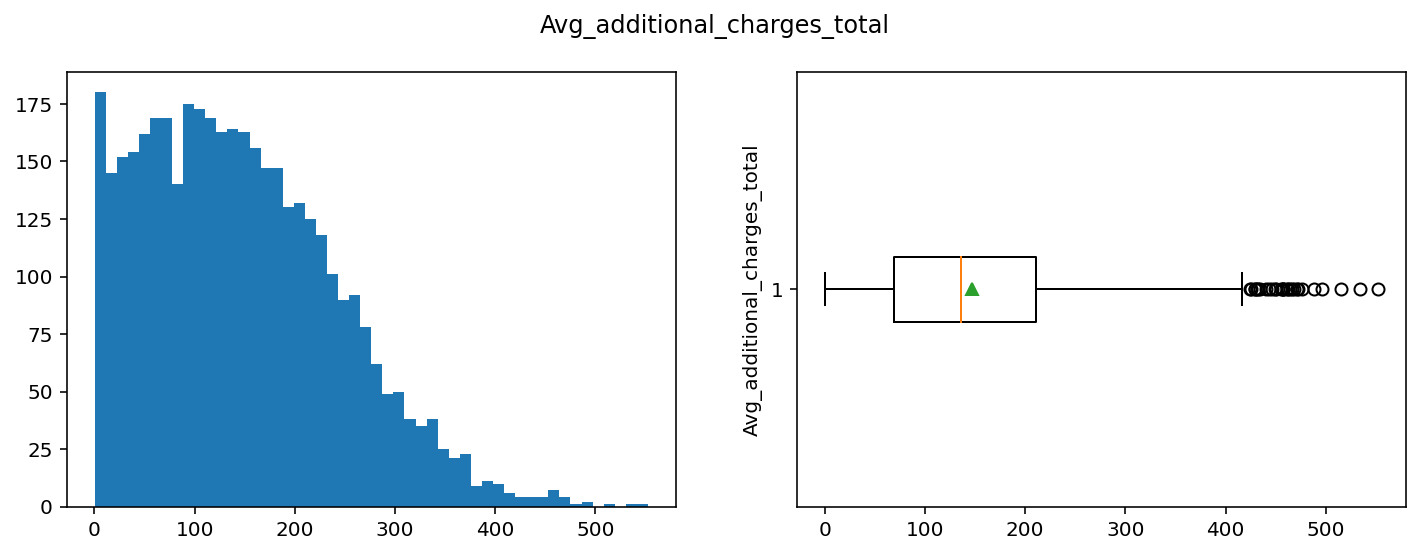

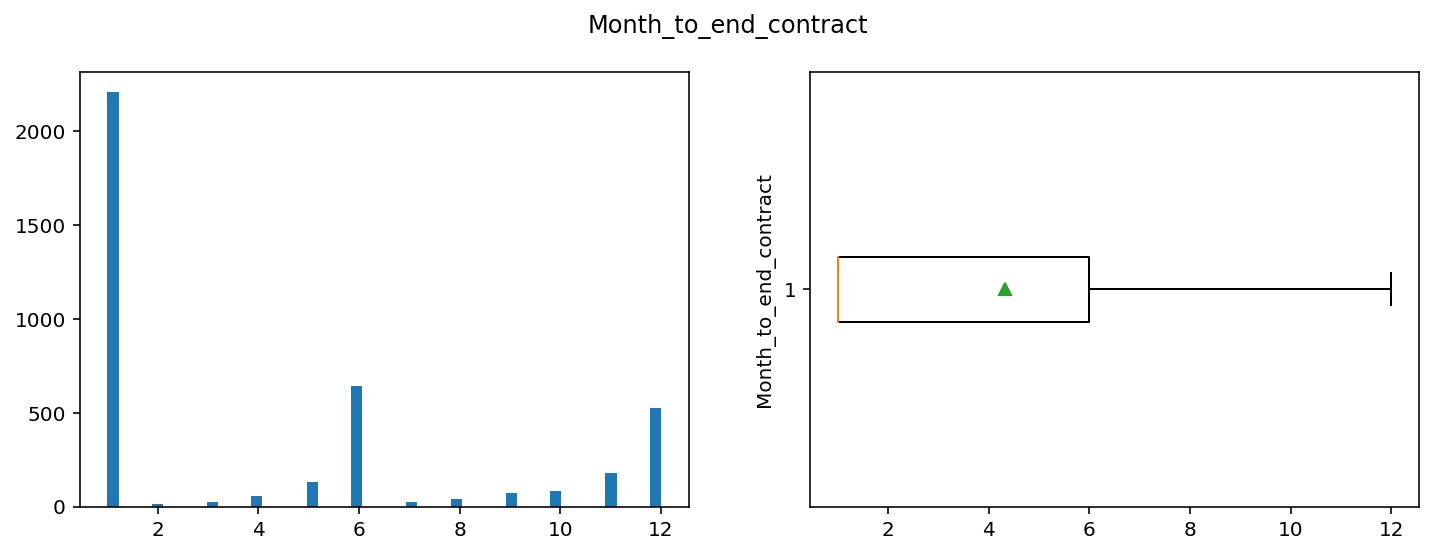

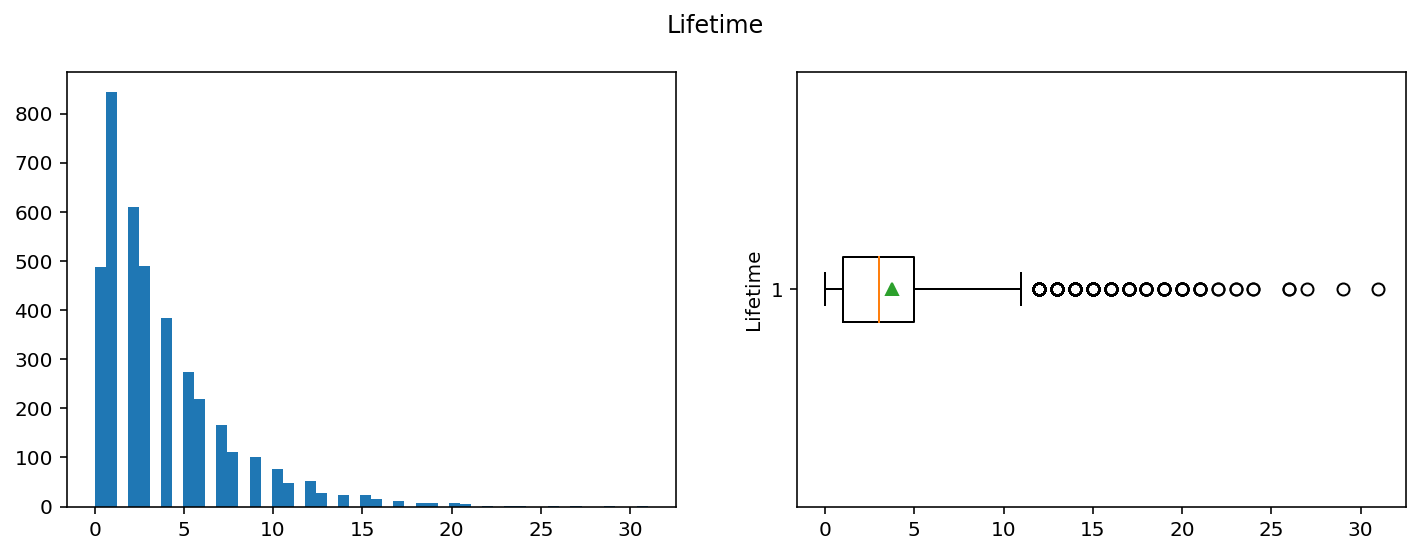

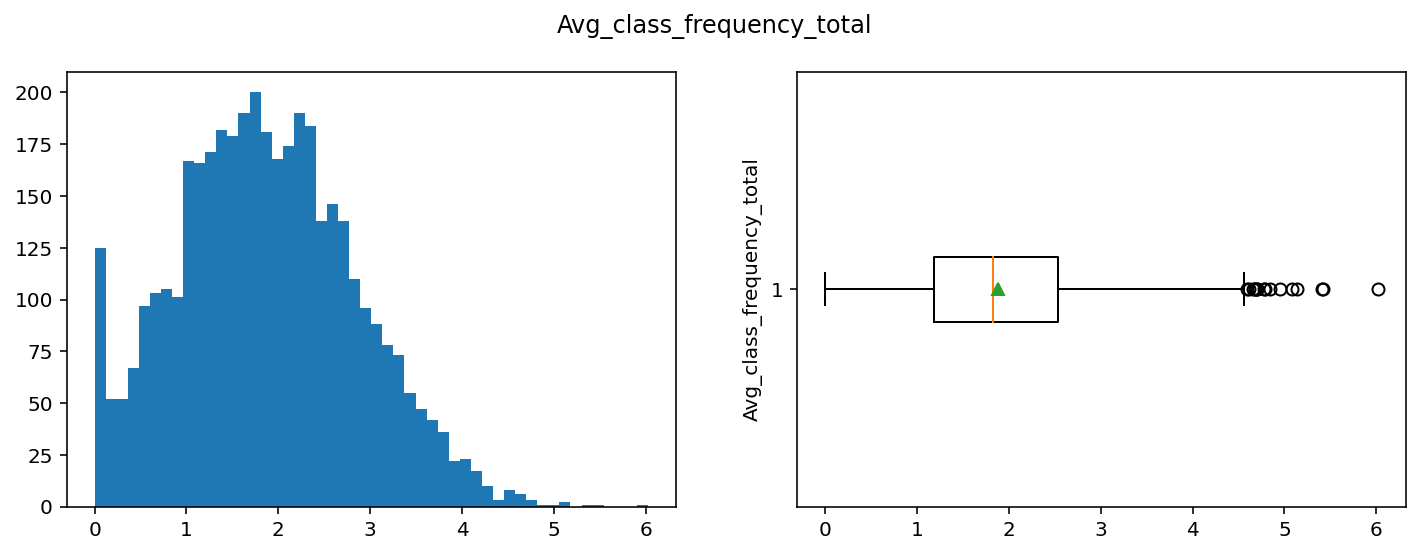

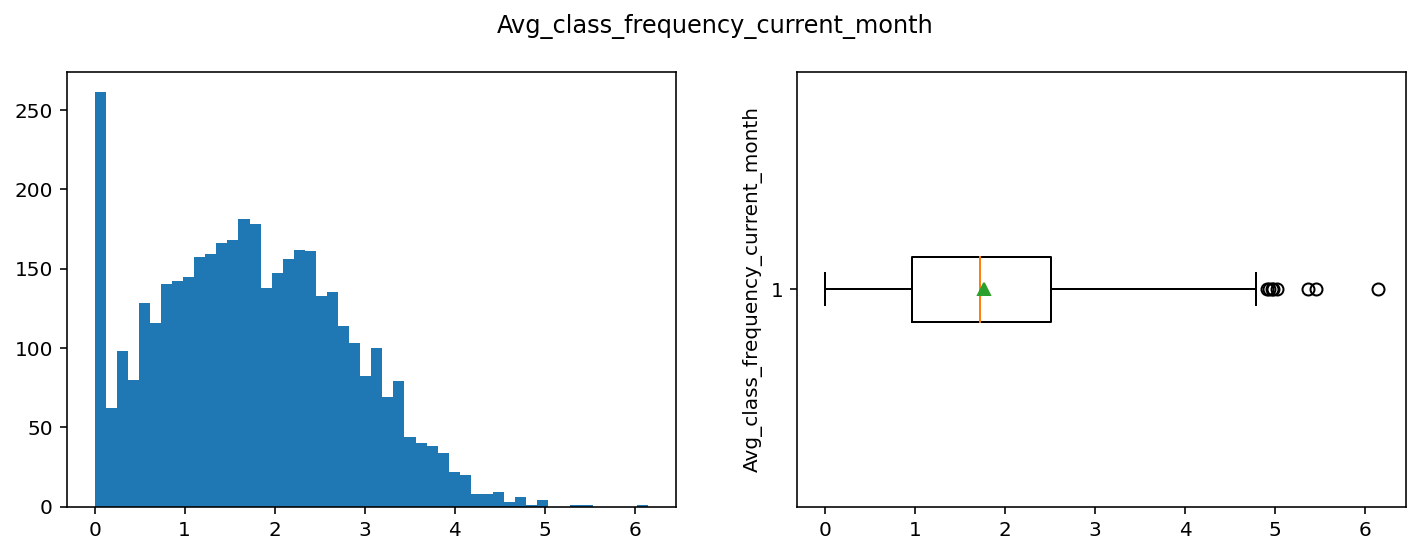

In [8]:
hist_n_box(data, ['Contract_period', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month'])

- возраст распределен нормально
- дополнительные расходы распределены не нормально (у всех есть какой-то минимум)
- дополнительные расходы небольшие, максимум 500 рублей 
- **очень мало давних клиентов, lifetime 11 месяцев - это уже выброс**

**Больше половины контрактов на 1 месяц (это ОЧЕНЬ МНОГО И СТРАННО)**

In [9]:
data['Contract_period'].value_counts(normalize=True)

1     0.55175
12    0.24000
6     0.20825
Name: Contract_period, dtype: float64

#### Задание: Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

**Столбчатые диаграммы**

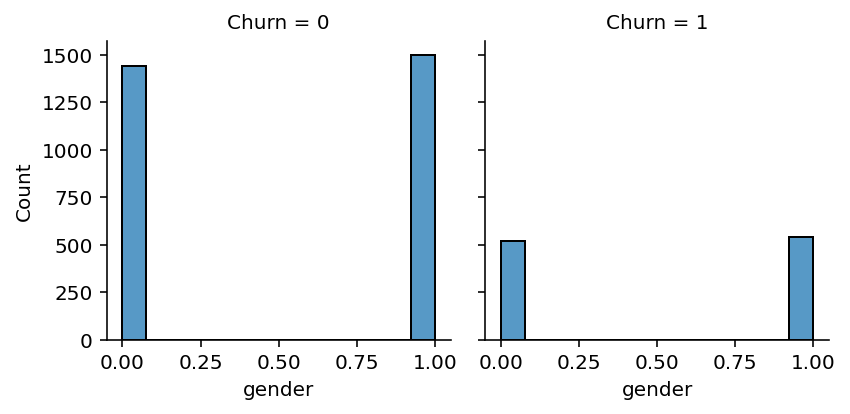

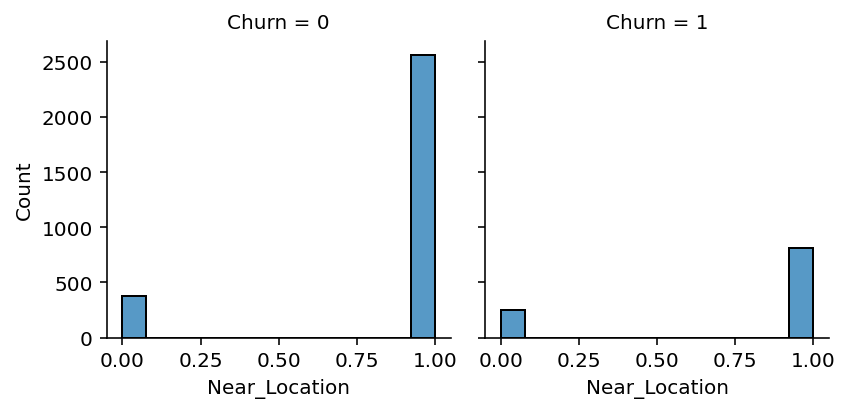

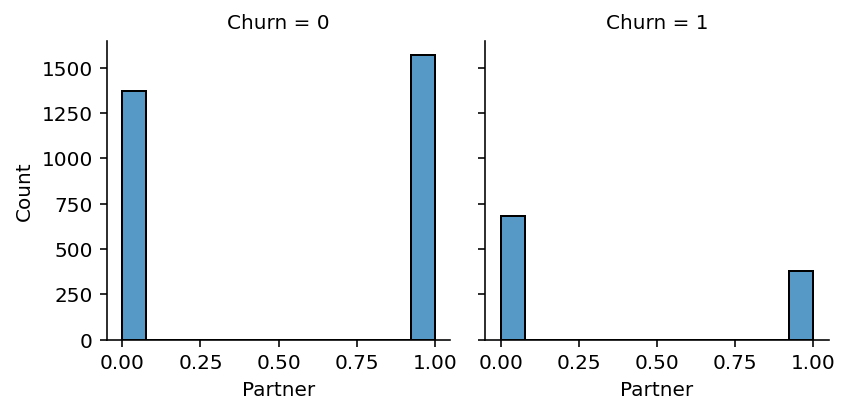

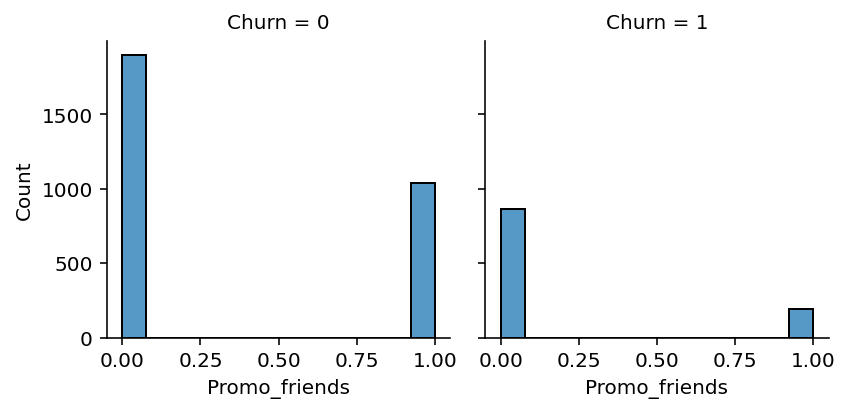

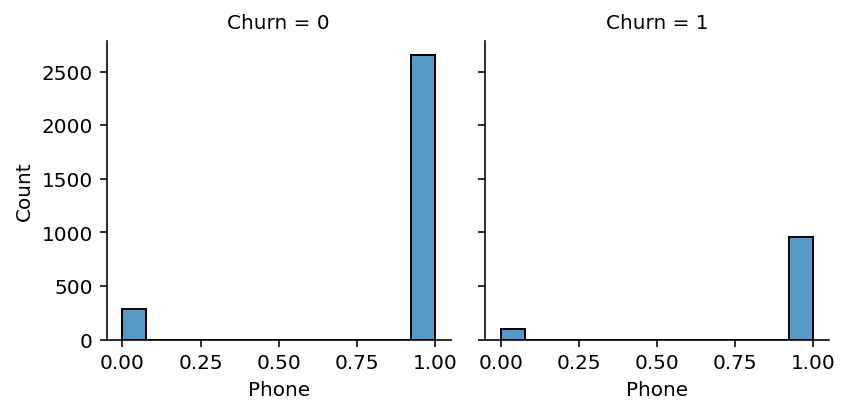

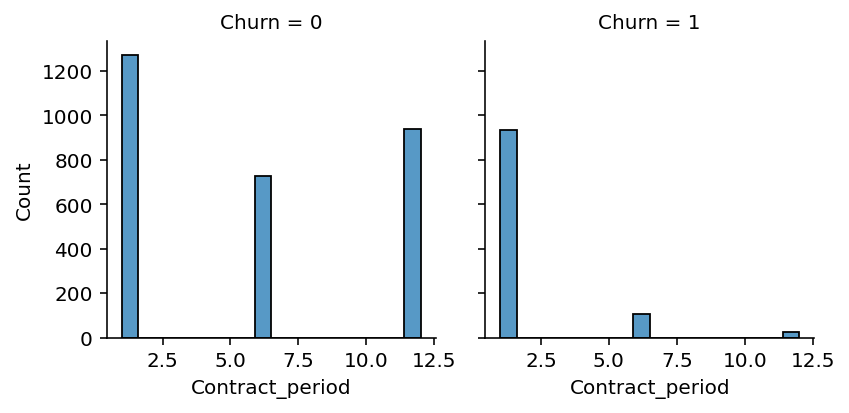

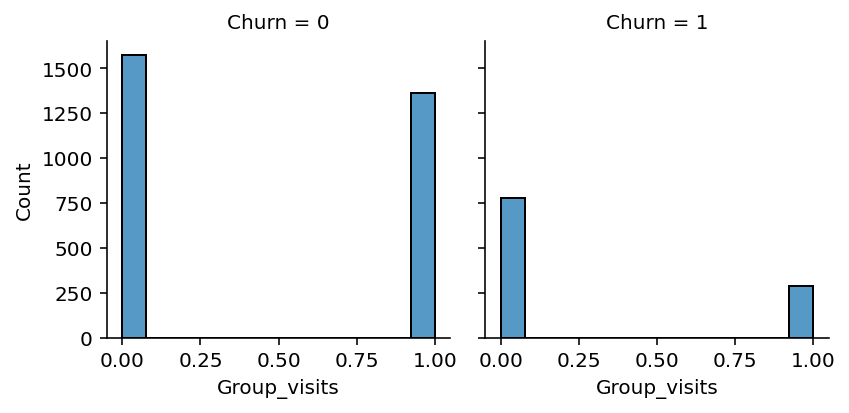

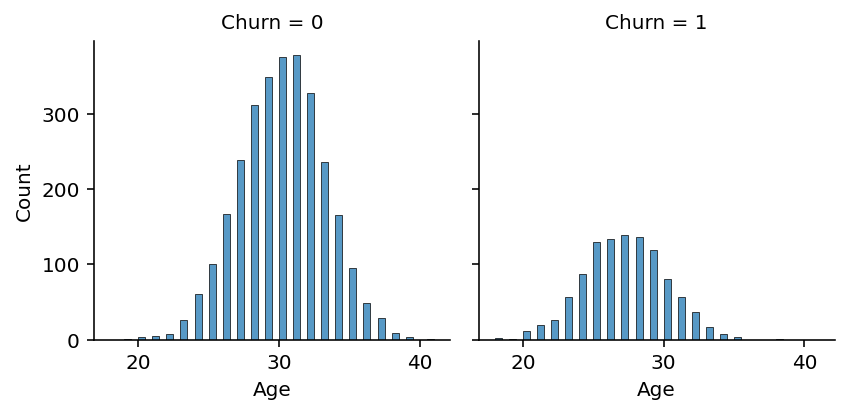

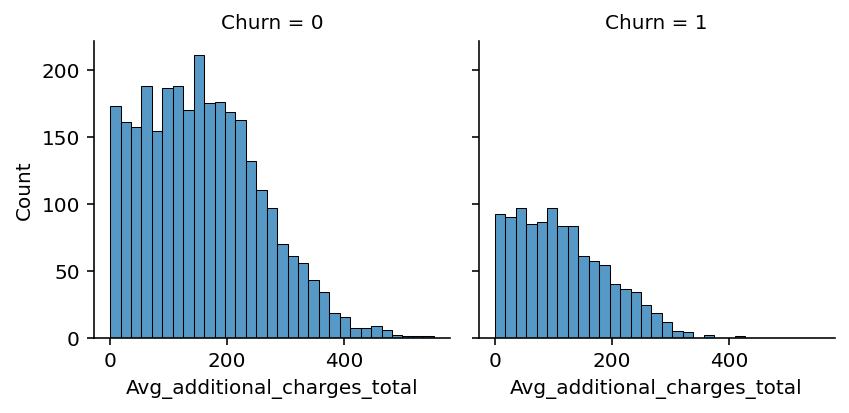

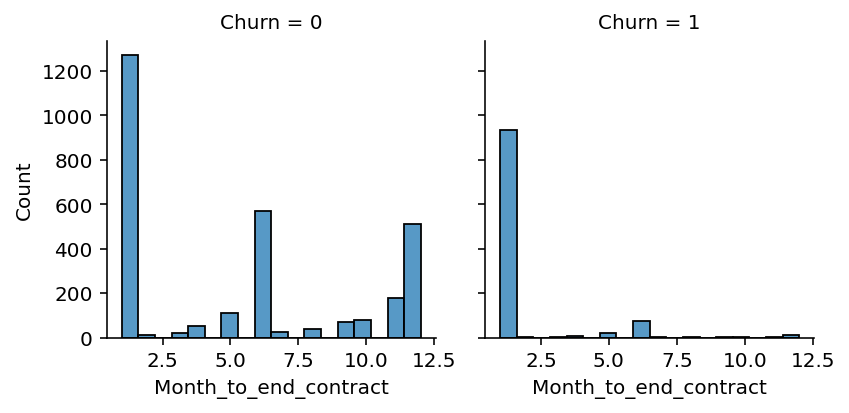

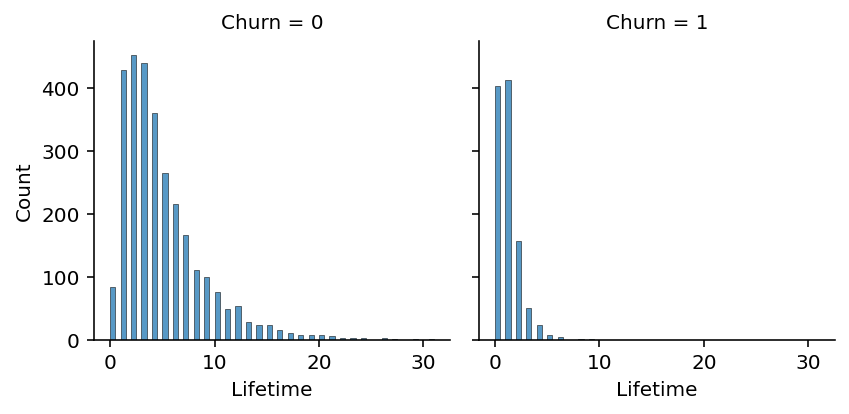

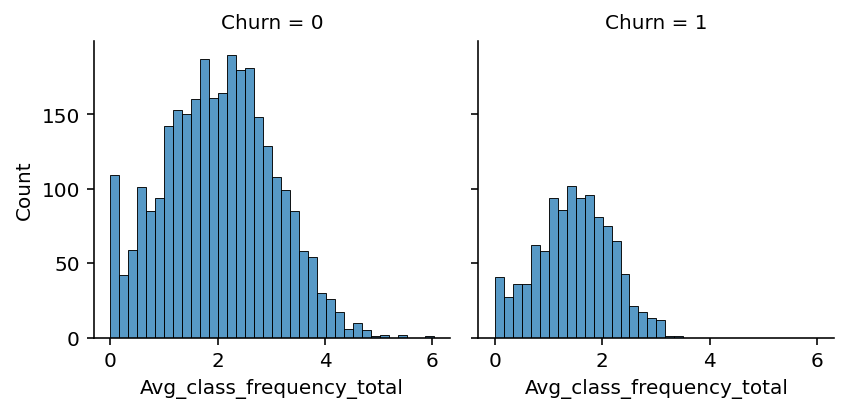

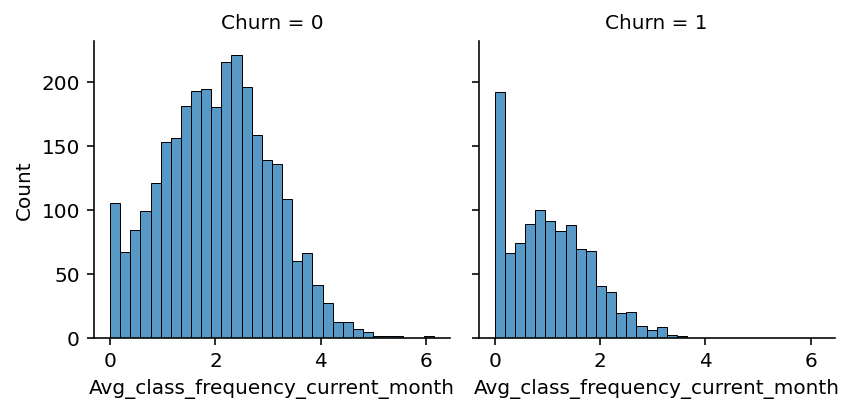

In [10]:
for i in ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month']:

    sns.displot(
        data, x=i, col="Churn",
        height=3, facet_kws=dict(margin_titles=True),
    );


**Распределения, независимо нормализованные**

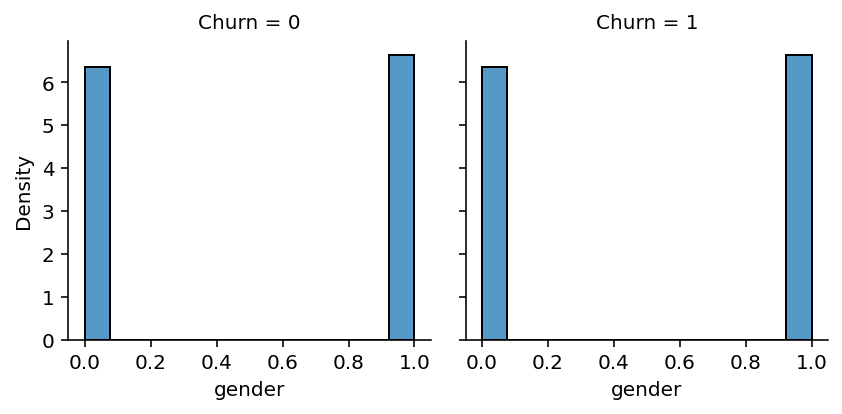

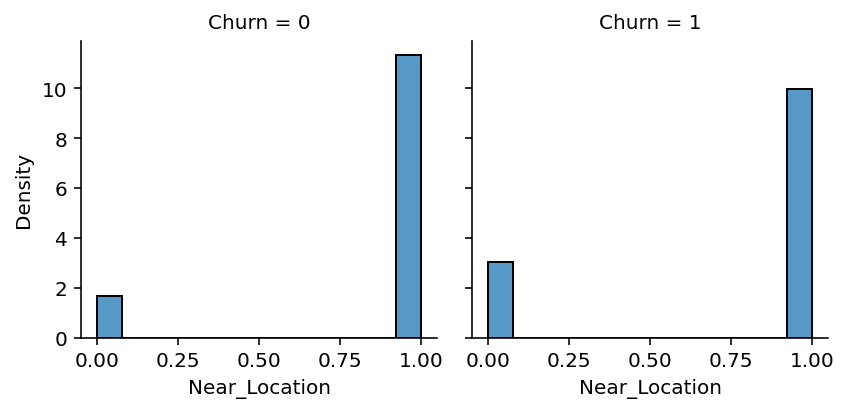

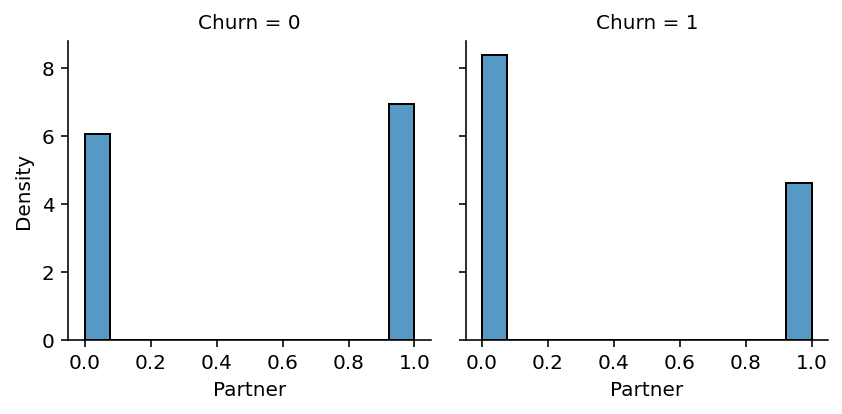

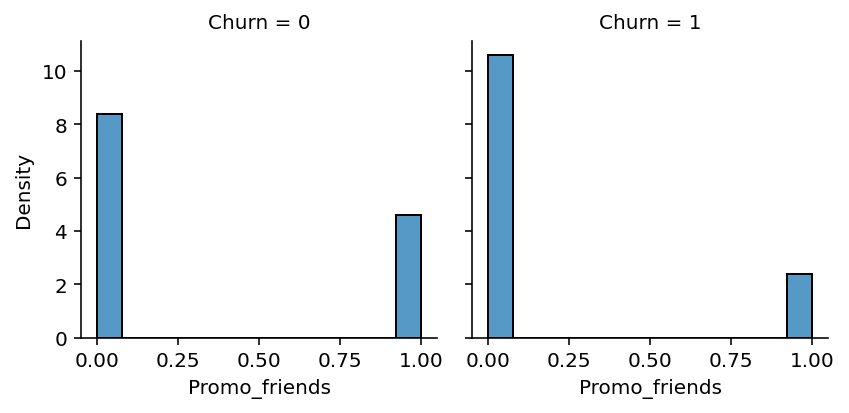

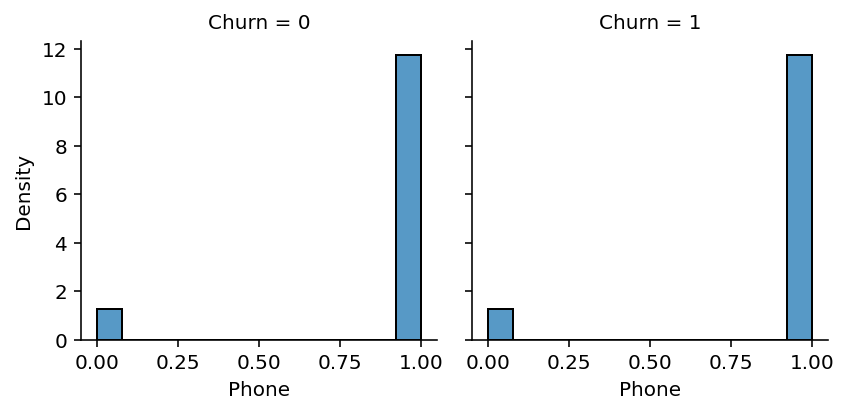

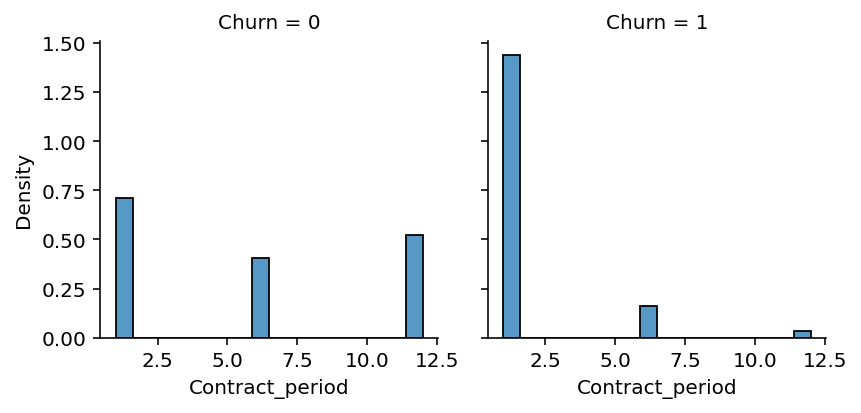

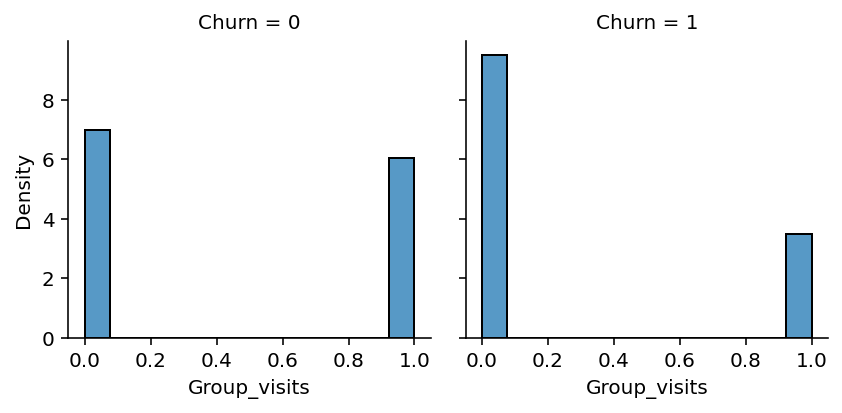

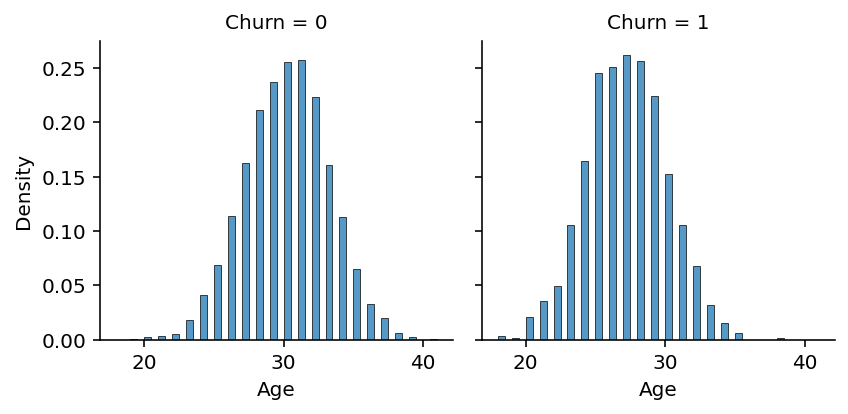

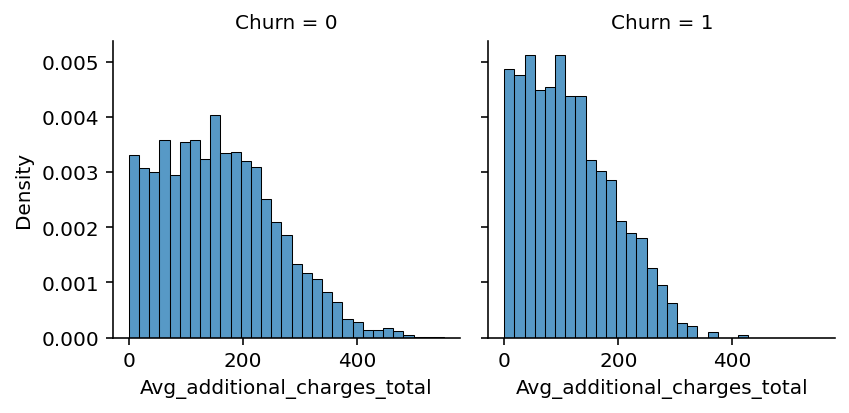

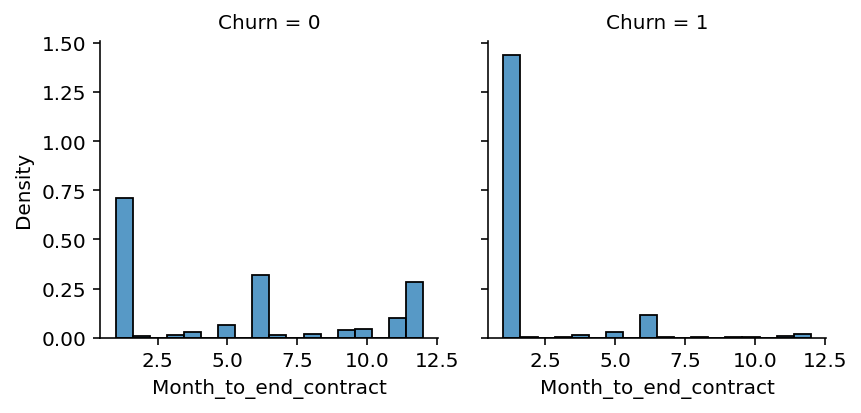

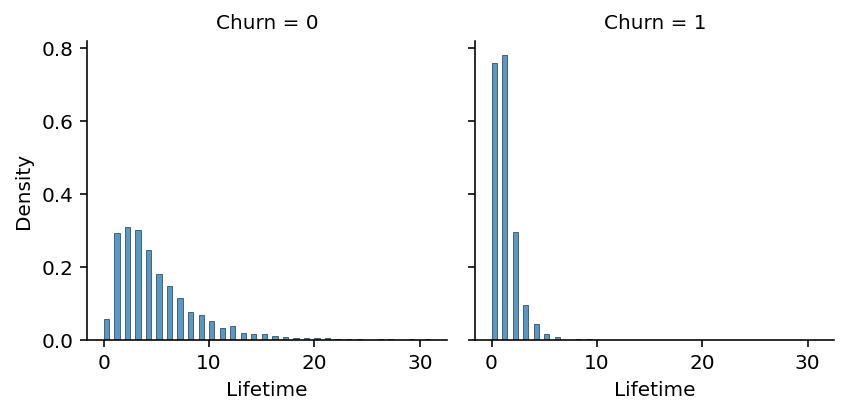

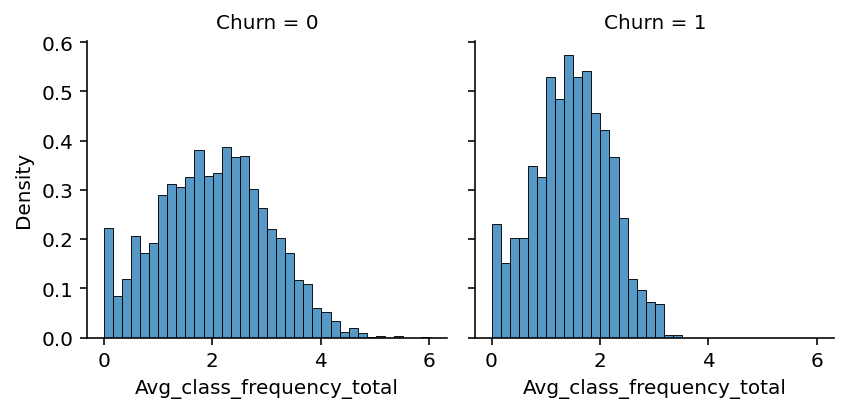

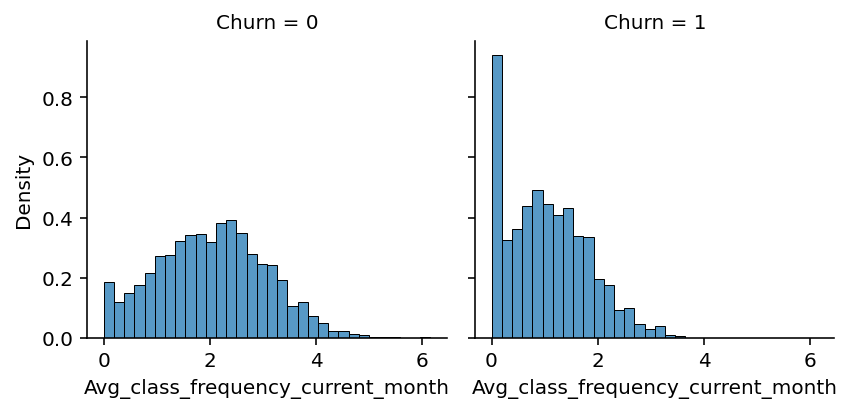

In [11]:
for i in ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month']:

    sns.displot(
        data, x=i, col="Churn", stat="density", common_norm=False,
        height=3, facet_kws=dict(margin_titles=True),
    );


предварительные наблюдения по гистограммам:


- Клиенты с полом 0, которые являются сотрудниками компании-партнера клуба, удерживаются лучше. Клиенты пола 1 наоборот чаще перестают ходить на занятия, если они сотрудники компании-партнера клуба
- отток немного меньше среди тех, кто живет недалеко
- отток немного меньше среди тех, кто пришел по акции "приведи друга" 
- отток существенно меньше среди тех, кто ходит на групповые занятия
- для тех, кто ушел, медианный возраст ниже чем у тех, кто остался
- большая разнице в оттоке в зависимости от длительности контракта. Однако это может объясняться просто тем, что контракт закончился и клиент перестал ходить
- те, кто бросили ходить, не тратили больше 400 рублей на дополнительные услуги
- практически у всех, кто бросил ходить, около месяца до окончания контракта. Но есть небольшой пик в районе 6 месяцев
- у всех, кто бросил ходить, лайфтайм меньше 9 месяцев
- среди тех, кто бросил ходить, нет тех кто ходит на групповые занятия 4 и больше раз в неделю
- **934 клиента с контрактом длиной 1 месяц не ходят в клуб этот месяц. Как это получается?**

In [12]:
print ('\nКоличество клиентов с контрактом длиной 1 месяц, которые не ходят в клуб в течение месяца:')

data.query('Contract_period == 1 and Churn == 1 ')['Churn'].count()


Количество клиентов с контрактом длиной 1 месяц, которые не ходят в клуб в течение месяца:


934

Проверим, не связано ли такое количество коротких контрактов с партнерскими программами (посчитаем, количество контрактов разной длительности с партнеркой и без нее). При сопоставимом общем количестве контрактов с партнеркой и без нее. Количество 1-месячных контрактов с партнеркой почти в 2 раза меньше чем без нее. 

==> Похоже что количество коротких контрактов не связано с партнерскими программами

In [13]:
data.pivot_table(index = 'Partner', columns = 'Contract_period',  values = 'Churn', aggfunc = 'count', margins=True)

Contract_period     1    6   12   All
Partner                              
0                1426  354  273  2053
1                 781  479  687  1947
All              2207  833  960  4000

Проверим, не связан ли отток с участием в партнерских программах и с длительностью контракта (посчитаем % оттока по контрактам разной длительности с партнеркой и без нее)

==> Видим, что отток на коротких контрактах существенно больше как при партнерке так и без нее, а в целом отток на контрактах с партнеркой почти в 2 раза меньше.

In [14]:
display (
    data
    .pivot_table(index = 'Partner', columns = 'Contract_period',  values = 'Churn', aggfunc = 'mean', margins=True)
    .style.format('{:,.0%}')
        )

#### Задание: Постройте матрицу корреляций и отобразите её.

''

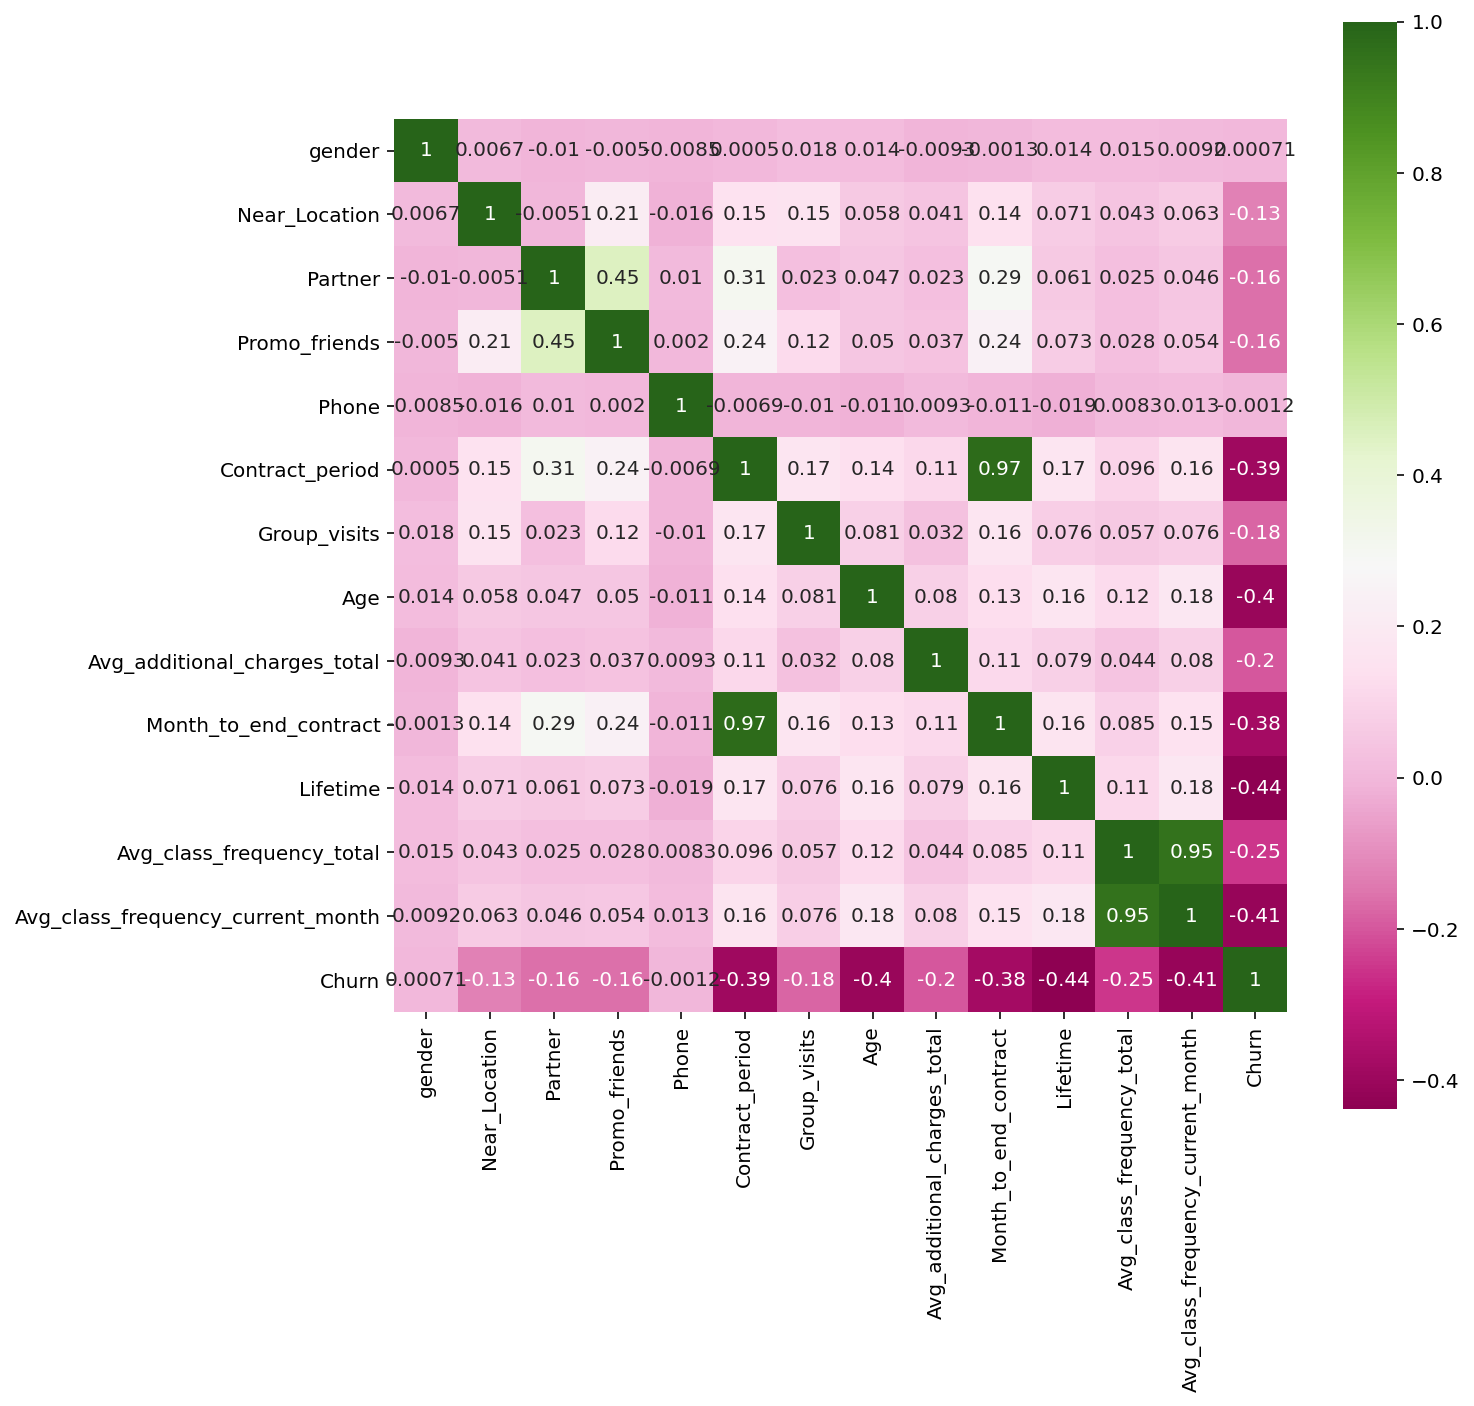

In [15]:
cm = data.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm, cmap="PiYG", square=True, annot=True)
;

Отдельно вынем корреляцию с оттоком

In [16]:
 display (
     pd.DataFrame(data.corr()['Churn']
          .drop('Churn')
          .sort_values())
          .style.background_gradient(cmap='PiYG', vmin=-1, vmax=1)
 )


##### Предварительные наблюдения по матрице корреляций:

- month to end contract / contract period - совпадает для 1 месяца и соответственно сильно коррелирует
- avg class frequency за предыдущий месяц сильно коррелирует с частотой вообще
- сильнее всего коррелируют с Churn (отрицательно): Lifetime, Avg_class_frequency_current_month, Age, Contract period


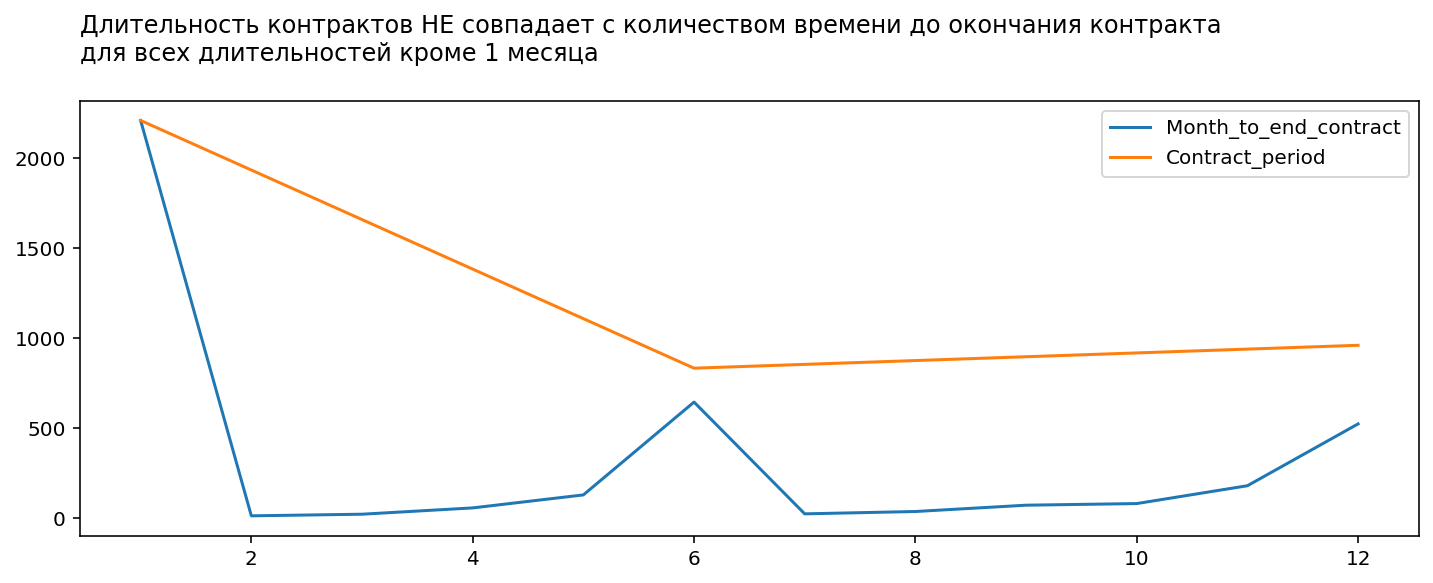

In [17]:
plt.figure(figsize=(12,4))
data['Month_to_end_contract'].value_counts().sort_index().plot()
data['Contract_period'].value_counts().sort_index().plot()
plt.title('Длительность контрактов НЕ совпадает с количеством времени до окончания контракта \nдля всех длительностей кроме 1 месяца', loc='left', pad=20)
plt.legend();

#### Попарные графики признак-признак не показали чего-то интересного, не буду их выводить

In [18]:
def pairs (df, x_name, y_name):
    plt.figure(figsize=(5, 5))
    sns.jointplot(
        x=df[x_name], y=df[y_name], kind="hex", palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

In [19]:
# churn исключать не буду, может быть проявится что-то интересное

# col_pairs = list(itertools.combinations(data.columns, 2))
# for pair in col_pairs:
#     pairs(data, pair[0], pair[1])

#### Количество посещений групповых занятий - еще одна странная метрика

- Среднее количество посещений за последний месяц по каждому лайфтайму практически совпадает с количеством посещений за все время
- Для клиентов с лайфтаймом > 22 почему-то нет данных по количеству посещений в текущий месяц
- Данные после 17 лайфтайма можно отбросить, т.к. таких клиентов в сумме меньше 1%
- клиенты с коротким лайфтаймом (как мы помним, практические совпадающие с клиентами с контрактами длительностью в 1 месяц), реже посещают спортклуб

''

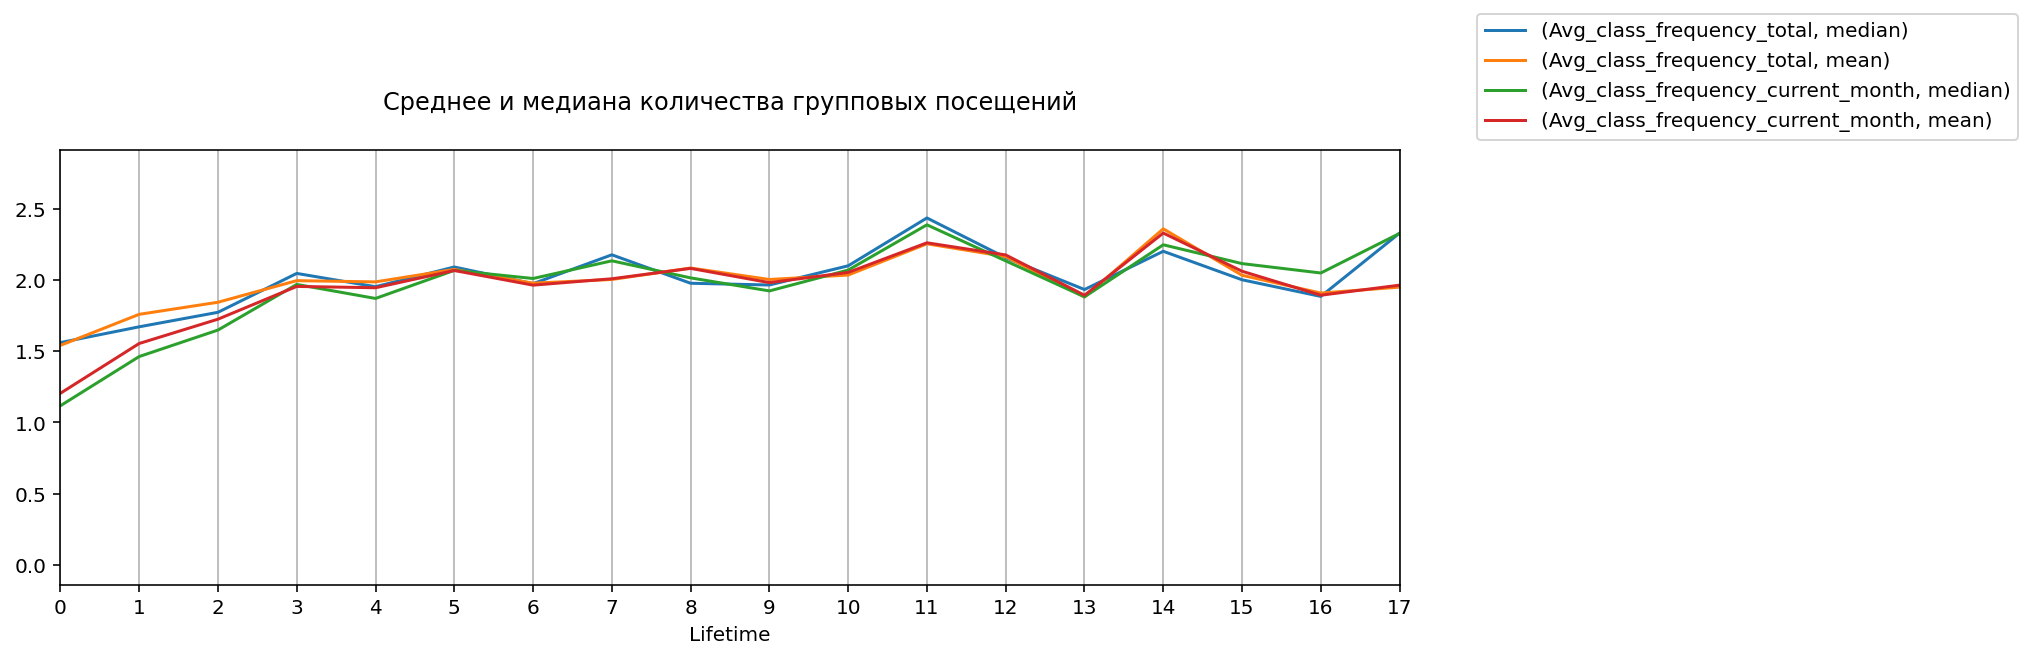

In [20]:
visits_lifetime = (data
     .groupby('Lifetime')
     .agg({'Avg_class_frequency_total':['median', 'mean'], 'Avg_class_frequency_current_month':['median', 'mean']})
                  )

visits_lifetime.plot(figsize=(12,4))
plt.xlim(0,17)
plt.xticks(np.arange(0,18, 1.0))
plt.grid(which = 'major', axis = 'x')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Среднее и медиана количества групповых посещений', pad=20)
;


In [21]:
data['Lifetime'].value_counts(normalize=True).cumsum()

1     0.21075
2     0.36325
3     0.48575
0     0.60750
4     0.70325
5     0.77150
6     0.82650
7     0.86825
8     0.89600
9     0.92100
10    0.94000
12    0.95325
11    0.96525
13    0.97225
15    0.97825
14    0.98425
16    0.98800
17    0.99075
19    0.99250
18    0.99425
20    0.99600
21    0.99725
26    0.99775
24    0.99825
22    0.99875
23    0.99925
27    0.99950
29    0.99975
31    1.00000
Name: Lifetime, dtype: float64

#### Комментарии к данным:

**Не хватает ID клиента**

Очень много контрактов, длящихся по 1 месяцу. При этом непонятно, их покупают одни и те же люди или разные. От ответа на этот вопрос сильно зависят выводы и рекомендации

**Не хватает дат заключения контракта**

- было бы полезно оценить динамику заключения контрактов
- предполагаю, что посещение спортклуба имеет выраженную сезонность. Было бы хорошо этот фактор учесть, особенно при таком количестве коротких контрактов.

**Что такое Lifetime?**  🤔

лайфтайм пока самый сильный предсказатель, хотелось бы понять, на что мы смотрим. Если лайфтайм - это время с первого звонка в клуб, а не с первого контракта - то получится что мы прогнозируем по времени от первого звонка до текущего момента. Как если бы люди долго зрели - то долго будут ходить, не продавайте контракты сразу, все равно такие клиенты отвалятся ))) 

Поле Lifetime - это время именно с первого контакта а не с начала посещения спортклуба? 

Можно попробовать посчитать, возвращающийся это клиент или нет, используя поле Lifetime (lifetime минус длительность действующего контракта плюс время, оставшееся до конца действующего контракта). Получается что у 75%+ клиентов lifetime начался раньше действующего контракта. Это кажется слишком оптимистичным для количества возвращающихся клиентов. 

При этом **есть клиенты, у которых длительность контракта минус время, оставшееся до конца контракта, меньше лайфтайма (см. пример дальше). Предположу, что это ошибка в данных.**

#### Допущение: для дальнейших выкладок предположу, что Lifetime - это время с заключения первого контракта.

#### Производная метрика Recurring client позволяет выделить сильно отличающиеся по оттоку группы

Исходя из этого допущения, можем рассчитать, посещал ли клиент спортклуб до того, как заключил текущий контракт:

возьмем длительность текущего контракта и вычтем из него количество месяцев, оставшихся до окончания. 
Так мы узнаем, сколько клиент ходит в клуб по действующему контракту. 
Далее возьмем лайфтайм, вычтем из него полученную цифру. Так мы узнаем, сколько времени клиент ходил в клуб 
ДО покупки текущего контракта.

In [22]:
# длительность текущего контракта минус количество месяцев, оставшихся до окончания = 
# сколько клиент ходит в клуб по действующему контракту; 

# Вычтем из лайфтайм полученную цифру. Так мы узнаем, сколько времени клиент ходил в клуб 
# ДО покупки текущего контракта.

data['LT_before_prev_contract'] = data['Lifetime'] - (data['Contract_period'] - data['Month_to_end_contract']) 

# если клиент ходил в клуб ДО покупки текущего контракта, обозначим его как 'recurring'

data['Recurring'] = data['LT_before_prev_contract'].apply(lambda x: 1 if x > 0 else 0)

В наборе есть порядка 3% клиентов с отрицательным количеством месяцев лайфтайма до подписания текущего контракта

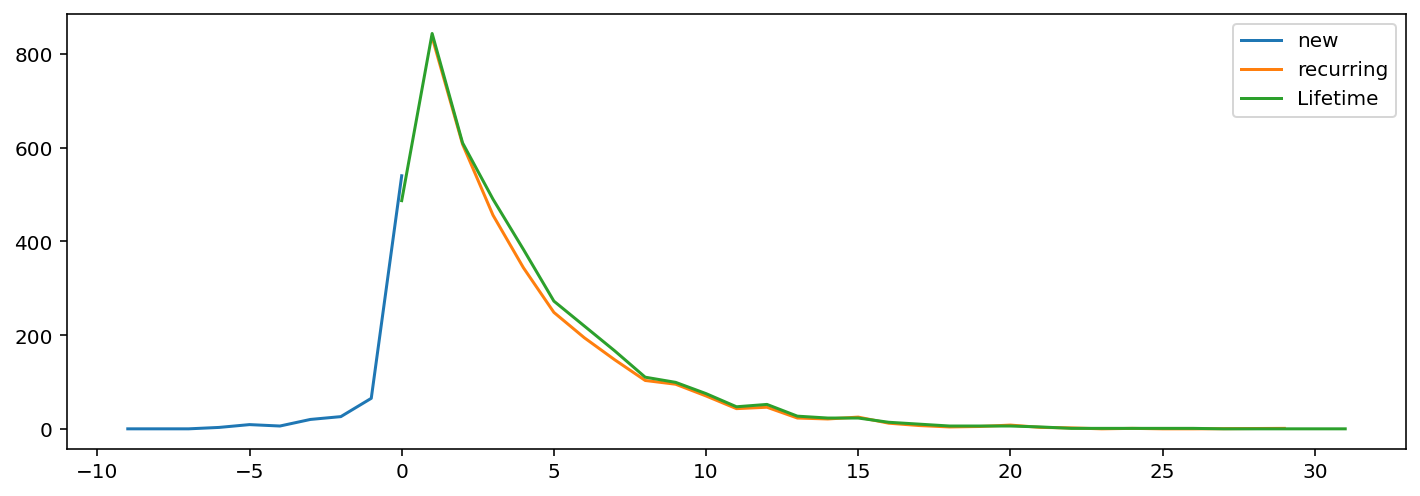

In [23]:
plt.figure(figsize=(12,4))
data.query('Recurring == 0') ['LT_before_prev_contract'].value_counts().sort_index().plot(label='new')
data.query('Recurring == 1') ['LT_before_prev_contract'].value_counts().sort_index().plot(label='recurring')
data['Lifetime'].value_counts().sort_index().plot()

plt.legend();

index  LT_before_prev_contract
35   -9.0                        1
32   -7.0                        1
27   -6.0                        4
20   -5.0                       10
23   -4.0                        7
18   -3.0                       21
14   -2.0                       27
11   -1.0                       66

доля клиентов с отрицательным временем посещения клуба до покупки текущего контракта:  0.03425


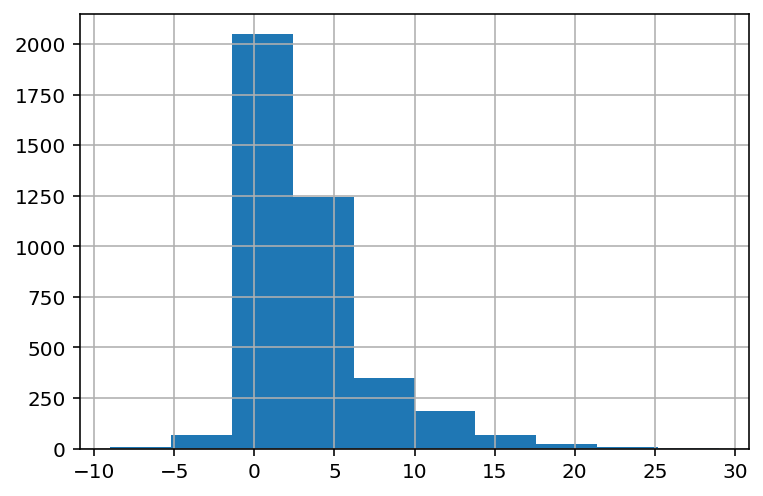

In [24]:
data['LT_before_prev_contract'].hist();
display (data['LT_before_prev_contract'].value_counts().reset_index().query('index < 0').sort_values(by='index'))
print ('доля клиентов с отрицательным временем посещения клуба до покупки текущего контракта: ',
    data.query('LT_before_prev_contract < 0')['Churn'].count() / data['Churn'].count())

Предположу, что это ошибка в данных и уберу таких клиентов из набора

In [25]:
data = data.query ('LT_before_prev_contract >= 0')

In [26]:
data.shape

(3863, 16)

**Процент оттока среди повторных и первичных клиентов сильно отличается**

In [27]:
print ('количество повторных клиентов, сгруппированных по длительности контрактов')

display (
    data
    .pivot_table(index = 'Recurring', columns = 'Contract_period',  values = 'Churn', aggfunc = 'count', margins=True)  
        )

print()
print ('% оттока среди повторных клиентов, сгруппированных по длительности контрактов')

display (
    data
    .pivot_table(index = 'Recurring', columns = 'Contract_period',  values = 'Churn', aggfunc = 'mean', margins=True)
    .style.format('{:,.0%}')
    .bar(subset='All', color='gold', vmin=0, vmax=1)
        )

количество повторных клиентов, сгруппированных по длительности контрактов


Contract_period     1    6   12   All
Recurring                            
0                 404   62   74   540
1                1803  730  790  3323
All              2207  792  864  3863


% оттока среди повторных клиентов, сгруппированных по длительности контрактов


Обе новых метрики, LT_before_prev_contract и Recurring сильно коррелируют с оттоком

In [28]:
 display (
     pd.DataFrame(data.corr()['Churn']
          .drop('Churn')
          .sort_values())
          .style.background_gradient(cmap='PiYG', vmin=-1, vmax=1)
 )

#### Выводы по результатам исследовательского анализа данных: данные необходимо проверить и доработать

Я считаю, что по имеющимся данным нельзя давать рекомендации, так как необходимо прояснить следующие моменты:


1. Что значит метрика Lifetime? Это время от начала первого контракта, заключенного со спортклубом? 
<br>

1. Если это действительно так: Почему так мал процент клиентов, которые длительно посещают спортклуб? Больше 90% клиентов посещают спортклуб меньше 8 месяцев. Лайфтайм это ключевой признак, с ним необходимо разобраться. 
<br>
1. Верно ли, что 55% контрактов заключено на 1 месяц? Возможно, у спортклуба необычная бизнес-модель, и тогда ее нужно учесть при анализе. Также возможно, что мы имеем нерепрезентативную выборку (в выборку почему-то попали в основном клиенты с короткими контрактами). Это важный признак, поэтому с ним нужно разобраться. 
<br>
1. Cтранно, что количество контрактов, заканчивающихся через один месяц, совпадает с количеством контрактов длительностью один месяц.
<br>
1. 934 клиента с контрактом длиной 1 месяц не ходят в клуб этот месяц (Churn = 1). Как это получается?
<br>
1. Так как подавляющее большинство контрактов короткие, для подготовки дальнейших рекомендаций необходимо понять, это одни и те же клиенты или разные. Для этого необходимо включить в набор данных ID клиента или хотя бы метку, это повторный клиент или новый. 
<br>
1. ~~Есть и менее существенная, но тем не менее очевидная нестыковка: 59% клиентов не посещают групповые занятия (см. среднее   поля Group_visits). При этом медиана посещений = 1.82 занятия, а должна быть равна нулю. Еще лучше это расхождение видно если мы просто посчитаем, сколько клиентов в принципе ходит на групповые занятия, а сколько ходит больше 0 раз в месяц. А это второй из ключевых признаков.~~ 

<div style="border:solid black 2px; padding: 20px">

**Комментарий ревьюера**
    
1. Да, предполагается, что Lifetime отражает количество месяцев, которое клиент отзанимался в фитнес-клубе с момента заключения первого контракта.
    
2. Возможно фитнес-клуб молодой, поэтому в данных очень мало клиентов в долгим lifetime, а остальные только недавно начали пробовать услуги клуба. Но это лишь предположение.
    
3. Думаю, про нетривиальную бизнес-модель было бы указано в задании. Согласна, что из описания не ясно, как именно составлялась выборка, но для упрощения можно считать, что процедура была корректной. Скорее всего в выборке сохранены такие же соотношение длительностей контракта как и в популяции посетителей клуба. 
    
4. Здесь, к сожалению, нет предположений о причинах.
    
5. Многие покупают абонемент на месяц, чтобы начать заниматься в целом. Но поскольку эта история относительно дешевая, то стимул выходит не очень эффективным, и покупатель в итоге не использует приобретенный абонемент. 
    
6. Согласна. Данные признаки важны для анализа. Для простоты в данном проекте допускается, что все 4000 клиентов являются разными людьми.
    
7. Выяснили выше, что посещения включают не только групповые активности.

<div class="alert alert-block alert-info">

Ответ на комментарий ревьюера:
    
1. ок, если lifetime это действительно время с подписания первого контракта то метрика recurring рассчитана верно
    
2. максимальный лайфтайм в наборе данных = 31, получается что клуб существует больше 2,5 лет
    
3. такая пропорция коротких контрактов выглядит очень странно. У меня была гипотеза что это контракты для тех, кто связан с компниями-партнерами, но она не подтвердилась.
    
4. ок
    
5. что-то явно не то с короткими контрактами )))
    
6. Если мы считаем что все эти клиенты разные, тогда данные выглядят еще более странно: 86% клиентов - recurring (в п.1 мы решили что метрика рассчитана правильно, при этом 55% контрактов - на 1 месяц. **ВЫВОД: 47% всех контрактов в клубе, который существует больше 2 лет - это recurring клиенты с контрактом в 1 месяц. Это нелогично**.
    
7. ок

</div>

<div class="alert alert-success">
    
**Комментарий от ревьюера v2**
    
6. Возможно, у этого феномена есть какое-то объяснение. Например, этим клиентам клуб подарил такие контракты, или они воспользовались какими-то купонами. 

In [97]:
print ('Максимальный лайфтайм: ', data['Lifetime'].max())
print ('доля recurring клиентов', data['Recurring'].mean().round(2))
print ('доля recurring клиентов с длиной контракта в 1 месяц: ', 
       # количество recurring клиентов с контрактом в 1 месяц
      ( data.query('Recurring == 1 and Contract_period ==1')['gender'].count()
       /data.shape[0]).round(2)  )
print ('доля контрактов, заканчивающихся через 1 месяц: ', data['Month_to_end_contract'].value_counts(normalize=True).iloc[0]) 
print ('доля контрактов длительностью 1 месяц: ', data['Contract_period'].value_counts(normalize=True).iloc[0])



Максимальный лайфтайм:  31
доля recurring клиентов 0.86
доля recurring клиентов с длиной контракта в 1 месяц:  0.47
доля контрактов, заканчивающихся через 1 месяц:  0.5713176287859176
доля контрактов длительностью 1 месяц:  0.5713176287859176


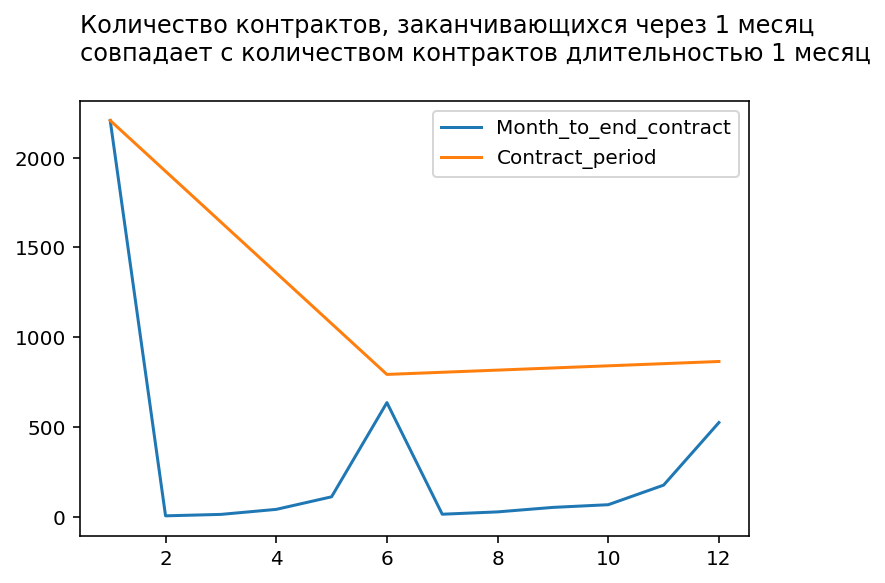

In [32]:
data['Month_to_end_contract'].value_counts().sort_index().plot()
data['Contract_period'].value_counts().sort_index().plot()

plt.legend()
plt.title ('Количество контрактов, заканчивающихся через 1 месяц \nсовпадает с количеством контрактов длительностью 1 месяц', loc='left', pad=20);

**Тем не менее для демонстрации освоенного материала доведу задание до конца**

## Задание:  Постройте модель  бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

### Логистическая регрессия

Необходимо учесть, что показатель  churn несбалансирован

In [33]:
print ('Соотношение классов:\n')
data['Churn'].value_counts(normalize=True)

Соотношение классов:



0    0.731556
1    0.268444
Name: Churn, dtype: float64

Также необходимо скорректировать влияние коллинеарных признаков методом L1, т.к. две пары признаков практически идентичны

In [34]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop('Churn', axis=1)
y = data['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# зададим алгоритм для нашей модели
# скорректируем влияние коллинеарных прзнаков
model = LogisticRegression(solver='liblinear', random_state=1, penalty='l1')

# обучим модель
model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_probs = model.predict_proba(X_test)[:, 1]

# бинарный прогноз
lr_pred = model.predict(X_test)

Определим оптимальный порог методом precision_recall_curve, чтобы отработать несбалансированность целевой переменной

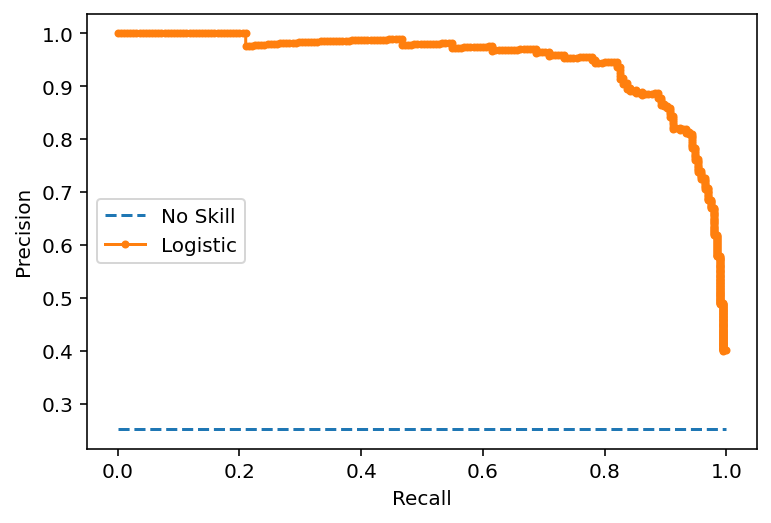

In [35]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)

# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Попробуем установить оптимальный порог 0.7, т.к. для нас допустимо распознать больше false positives, чем пропустить true positive

определим функцию для расчета метрик

In [36]:
# функция для расчета метрик классификации

def metrics(models, y_test=y_test):
    for model, predictions in models.items():
        print('Метрики для модели', model)
        print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
        print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
        print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
        print('F1: {:.2f}'.format(f1_score(y_test, predictions))) 
        print('roc_auc: {:.2f}\n'.format(roc_auc_score(y_test, predictions))) 
    

Посчитаем метрики для модели без доработок и для модели с новым порогом. 

In [37]:
threshold = 0.7
lr_pred_custom = [0 if i < threshold else 1 for i in lr_probs]
models =  ({'Линейная регрессия':lr_pred, 'Линейная регрессия с порогом 0.7':lr_pred_custom})
metrics(models)

Метрики для модели Линейная регрессия
Accuracy: 0.94
Precision: 0.91
Recall: 0.84
F1: 0.87
roc_auc: 0.90

Метрики для модели Линейная регрессия с порогом 0.7
Accuracy: 0.93
Precision: 0.95
Recall: 0.76
F1: 0.85
roc_auc: 0.87



Для модели с порогом 0.7 полнота ниже, точность и доля правильных ответов выше.

Тем не менее, т.к. для нас допустимо распознать больше false positives, чем пропустить true positive, считаю что 
**нужно использовать logistic regression модель без коррекции порога.**

### Случайный лес

In [38]:
# зададим модель
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)
# обучим модель
rf_model.fit(X_train, y_train)
# бинарный прогноз
rf_pred = rf_model.predict(X_test) 

### Задание: оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. Какая модель показала себя лучше на основании метрик?

Метрики зависимы от сбалансированности, но мы будем сравнивать их между собой, поэтому сбалансированностью можно пренебречь.

**Линейная регрессия показывает лучший результат.**

In [39]:
models =  ({'Линейная регрессия':lr_pred, 'Случайный лес':rf_pred})
metrics(models)

Метрики для модели Линейная регрессия
Accuracy: 0.94
Precision: 0.91
Recall: 0.84
F1: 0.87
roc_auc: 0.90

Метрики для модели Случайный лес
Accuracy: 0.93
Precision: 0.87
Recall: 0.86
F1: 0.86
roc_auc: 0.91



### ВЫВОД по бинарной классификации: 

обе модели выполнены для демонстрации принципиального подхода, выводы по ним делать не имеет смысла.

## Задание:  Сделайте кластеризацию клиентов

Для кластеризации уменьшим размерность набора данных. Из предыдущих итераций уже понятно, что на отток мало влияют поля:

- 'gender'
- 'Phone'
- 'Age'

кроме того, слеующие поля мы можем выбросить, так как у них есть практически дубли:

- 'Avg_class_frequency_total'
- 'Contract_period'
- 'Group_visits'



In [40]:
data_k = data.drop(['gender', 'Phone', 'Group_visits', 'Age',
       'Avg_class_frequency_current_month'], axis=1)

разделим новый набор данный на тренировочный и обучающий наборы

In [41]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data_k.drop('Churn', axis=1)
y = data_k['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)


### Задание: стандартизируйте данные

In [42]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) 


### Задание: Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму.

С упрощенным набором данных получаем 3 кластера

In [43]:
linked = linkage(X_train_st, method = 'ward') 

Так как график отрисовывается достаточно долго, вставлю картинку, чтобы не мешать ревью

In [44]:
# plt.figure(figsize=(15, 10))  
# dendrogram(linked, orientation='top')
# plt.title('Hierarchial clustering for test dataset')
# plt.show() 

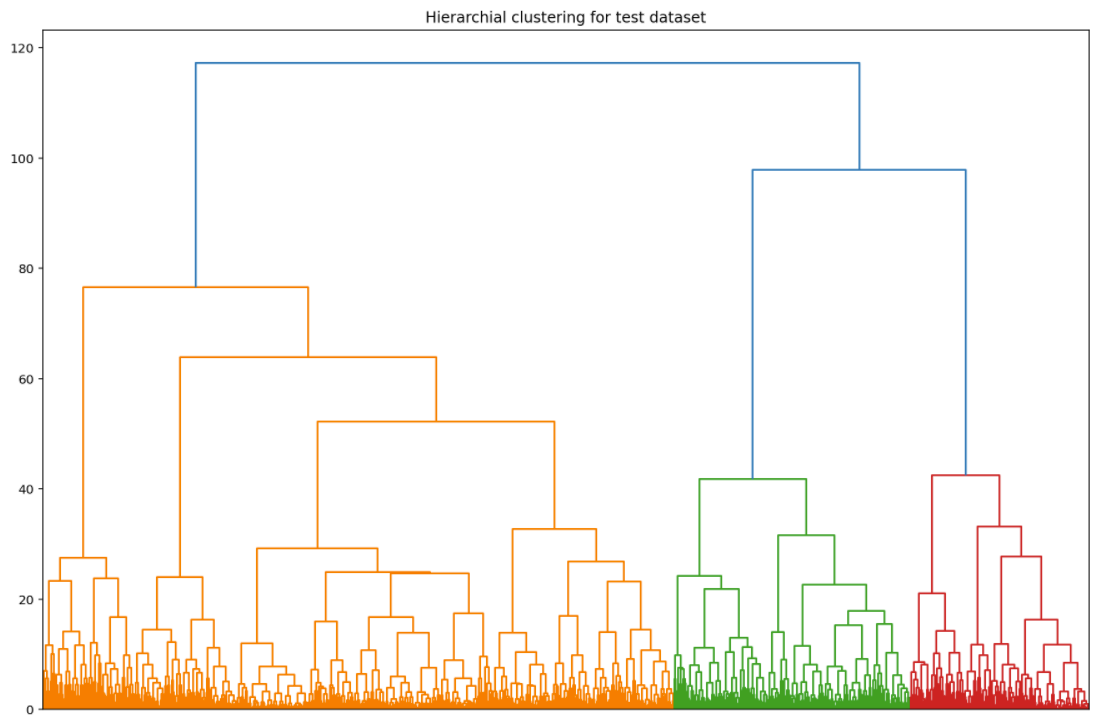

### Задание: Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов.

В задании есть инструкция указать 5 кластеров. Однако, так как я упростила набор данных, эти кластеры не слишком сильно отличаются друг от друга. Попробую использовать 3 кластера.

In [45]:
# стандартизируем данные
X_sc = scaler.fit_transform(X)

# задаём число кластеров, равное 3, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=3, random_state=0) 

# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc) 

# сохраняем метки кластера в поле нашего датасета
data_k['cluster'] = labels

### Задание: Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

Выделился один кластер с высоким оттоком

In [46]:
# выводим статистику по средним значениям наших признаков по кластеру
display (
    data_k.groupby(['cluster'])
    .mean()
    .style.bar(color='pink', vmin=0)

)

In [47]:
top_clusters = (
    data_k[['cluster','Churn']].groupby(['cluster'])
    .agg(['mean', 'count'])
    .sort_values(by=('Churn',  'mean'), ascending=False)
)

display (top_clusters.style.bar(color='gold', vmin=0))


In [48]:
# display (
#     data_k
#     .pivot_table(index='cluster', columns='Churn', values = 'Recurring', aggfunc=['mean', 'count'])
#     .style.format('{:,.2f}')
#     .bar(color='coral', subset=['mean'], vmin=0, vmax=1)
# )

#### описание кластеров:

СИЛЬНЫЙ ОТТОК: определяется в основном по короткому лайфтайму до заключения контракта и новой метрике 'recurring'. Все, кто пришел в клуб в первый раз, прогнозируются к оттоку

СРЕДНИЙ ОТТОК: все, кто не входит в первую и третью категории

СЛАБЫЙ ОТТОК: длинные контракты, большой лайфтайм, регулярно посещают клуб

### Задание: Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?

In [49]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        x=df[x_name], y=df[y_name], hue=df[cluster_name], palette='brg', alpha=0.5
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

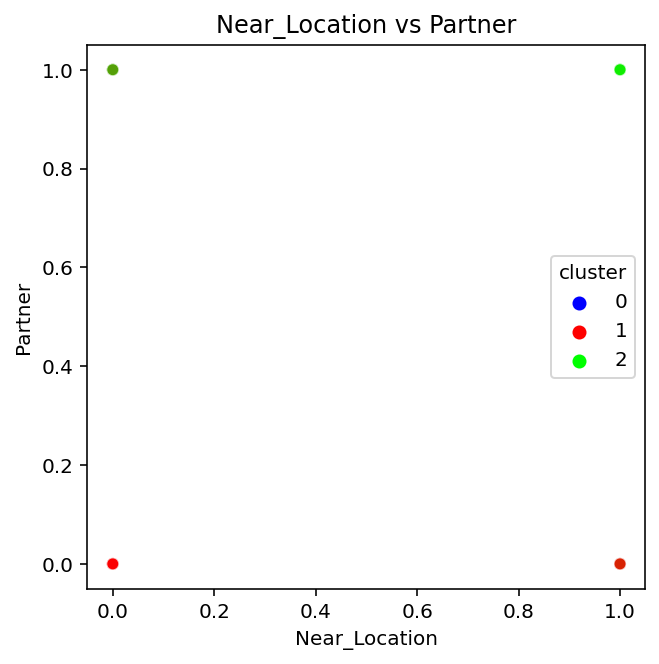

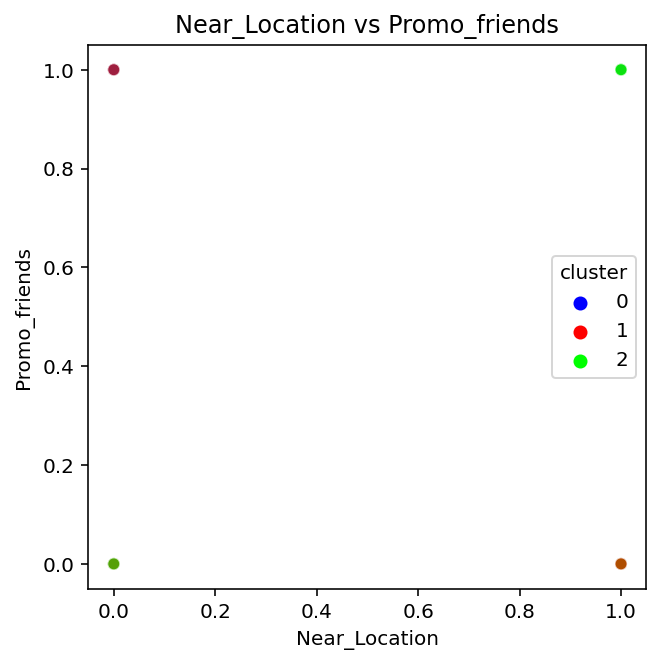

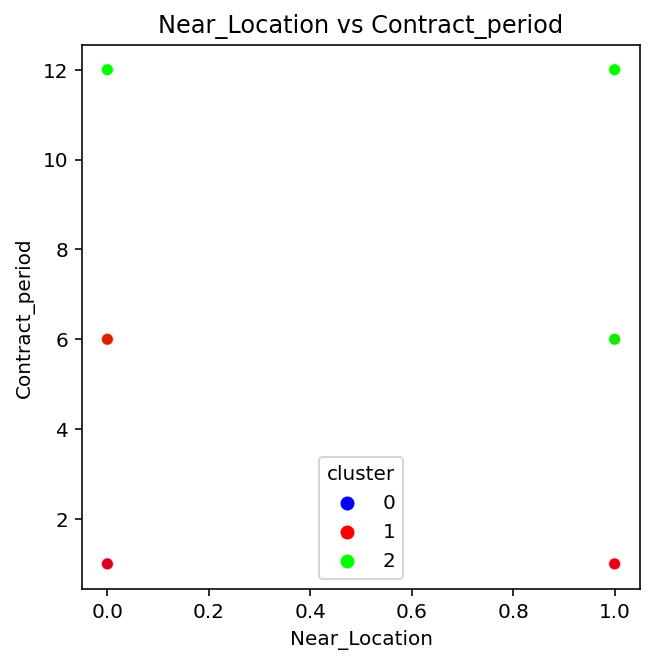

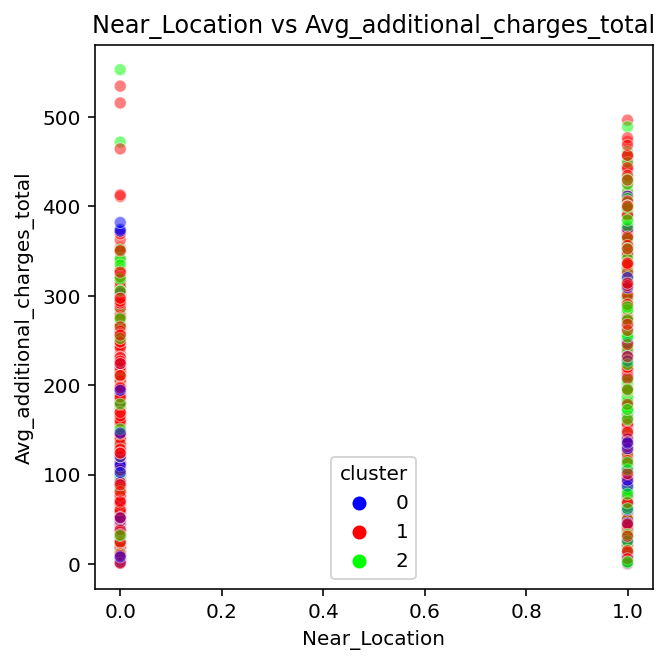

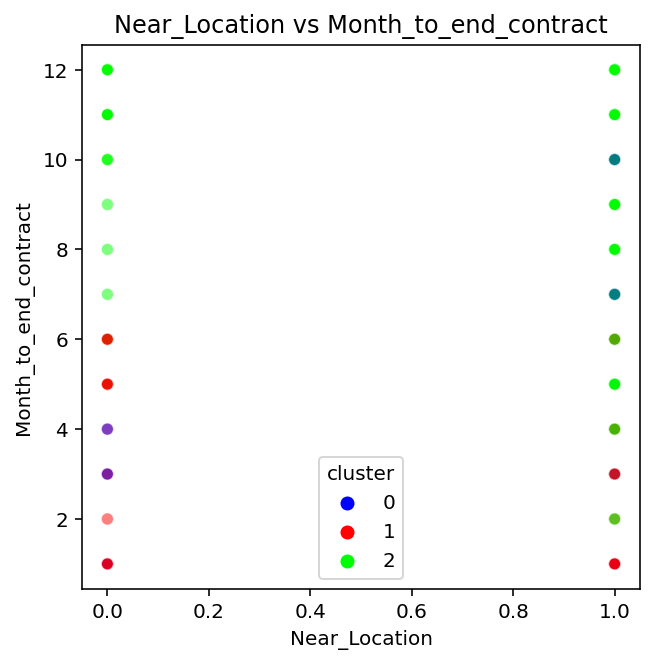

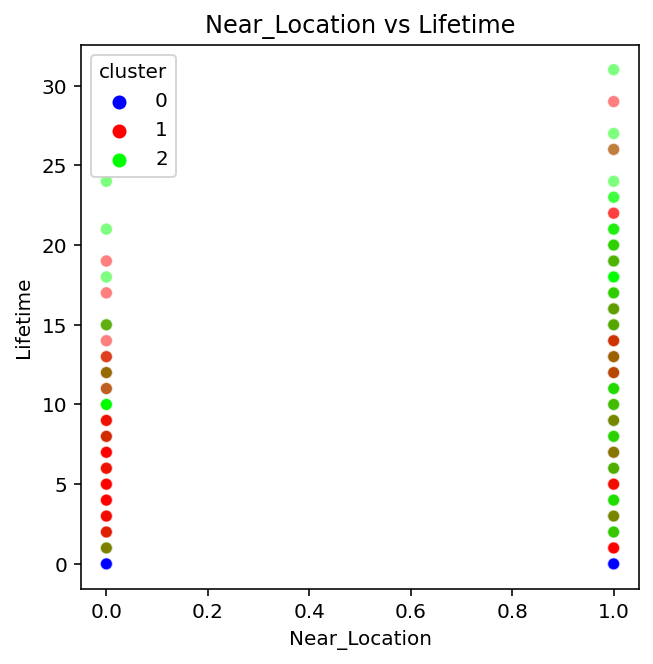

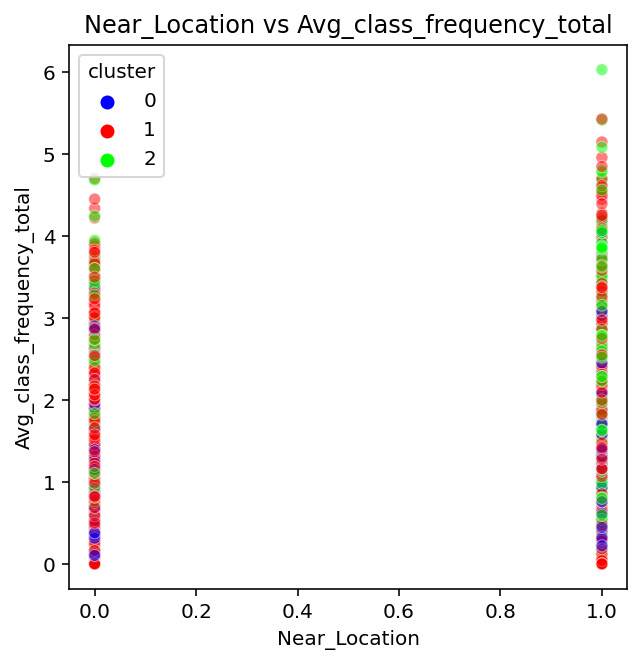

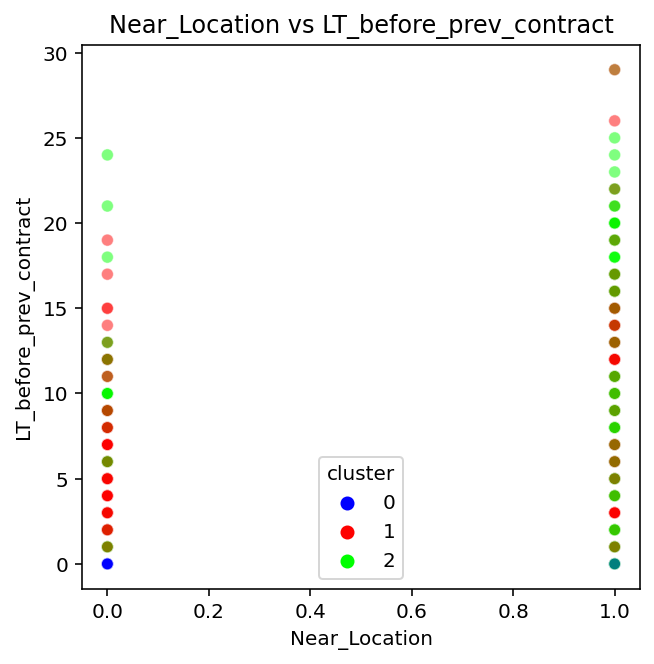

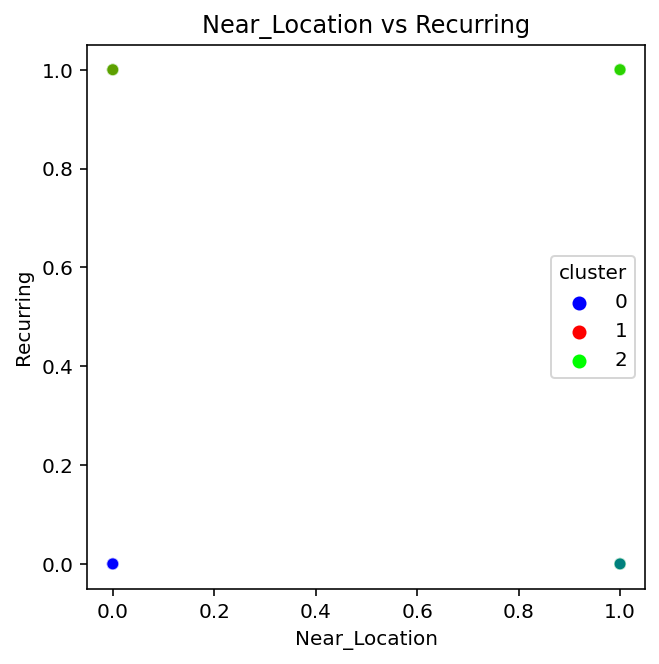

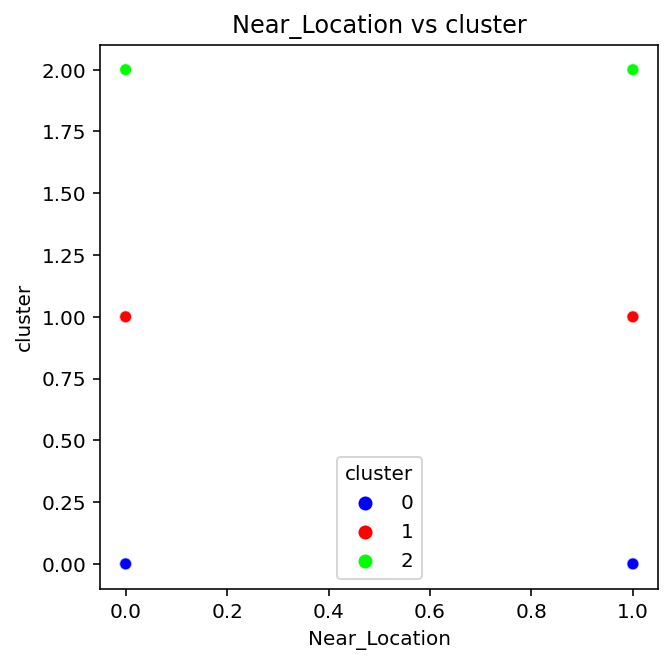

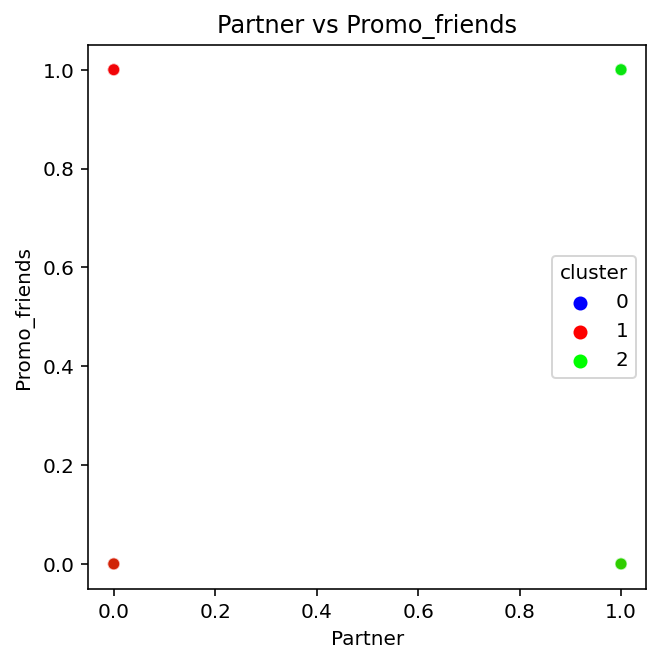

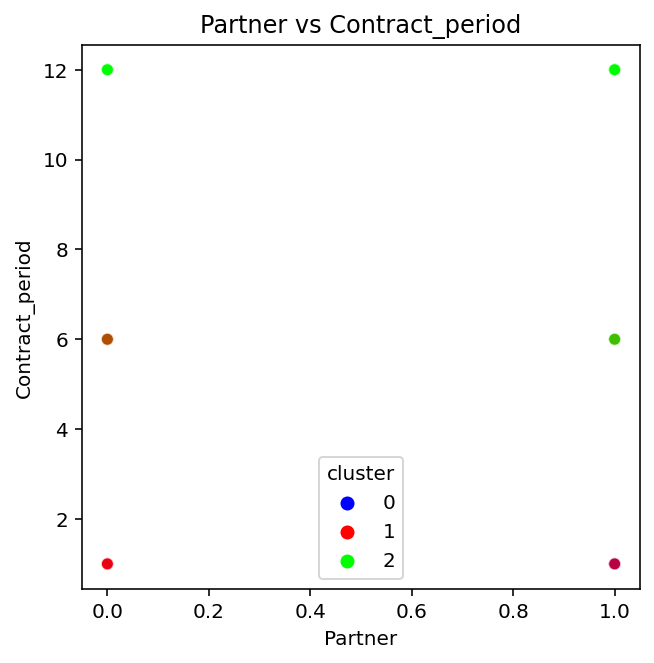

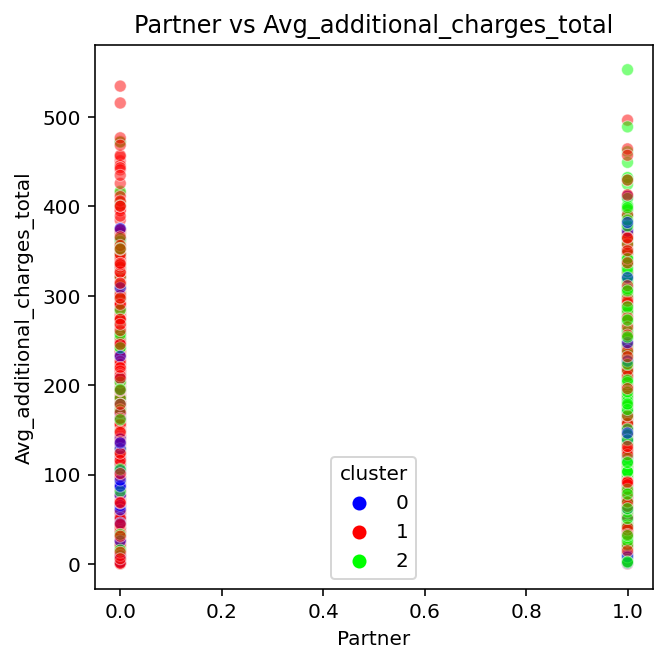

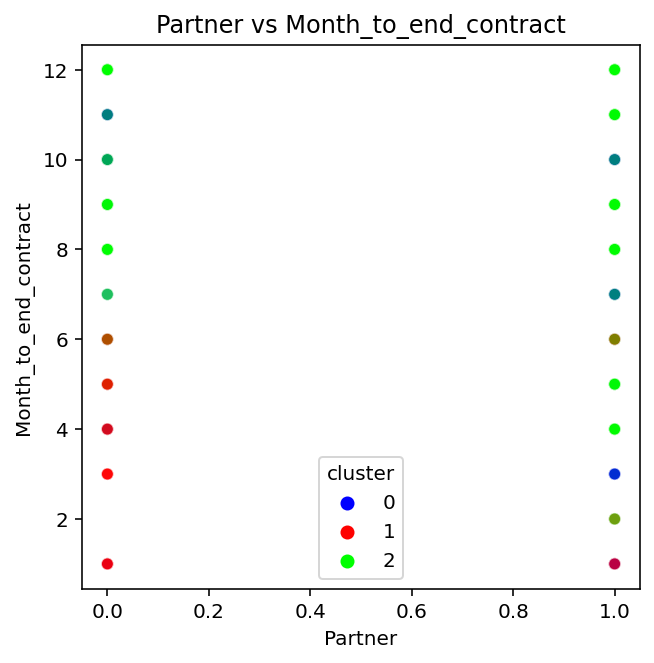

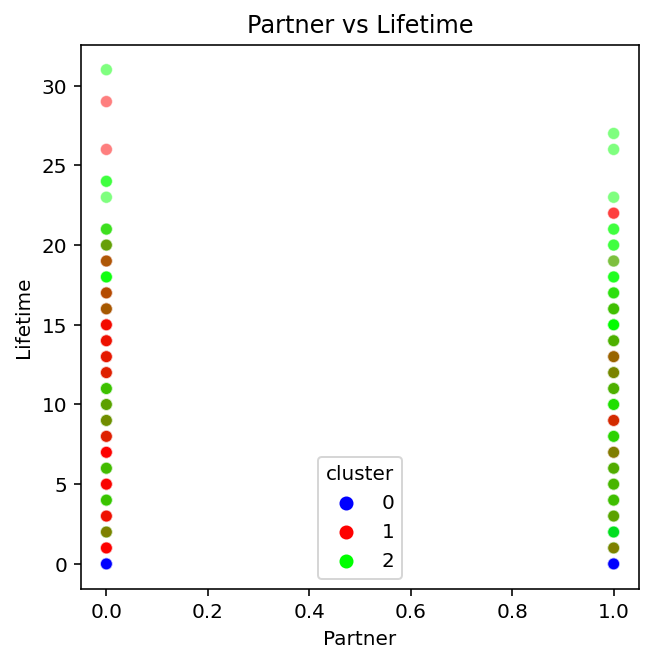

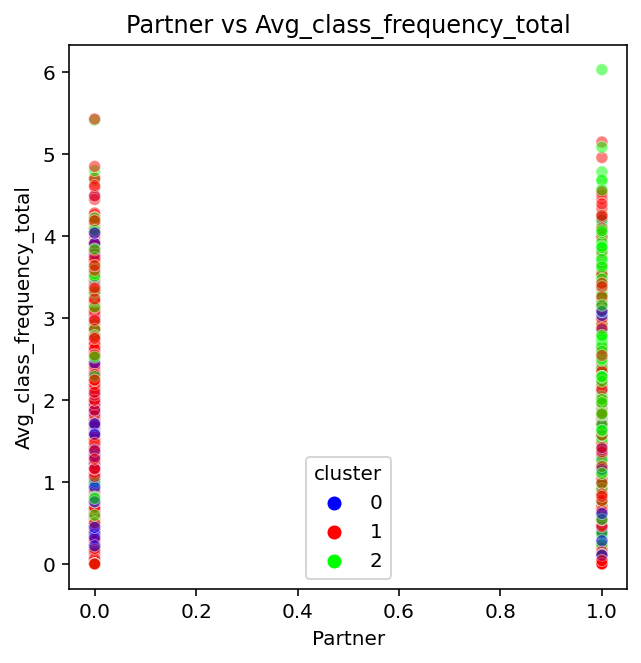

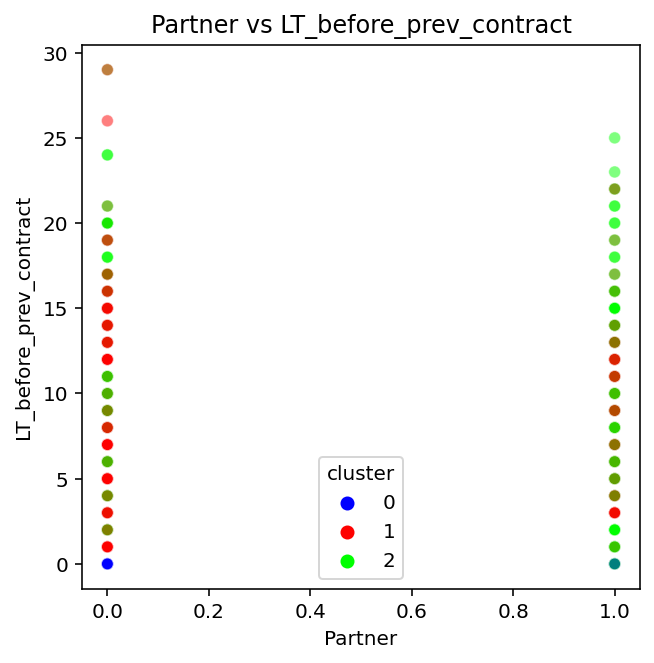

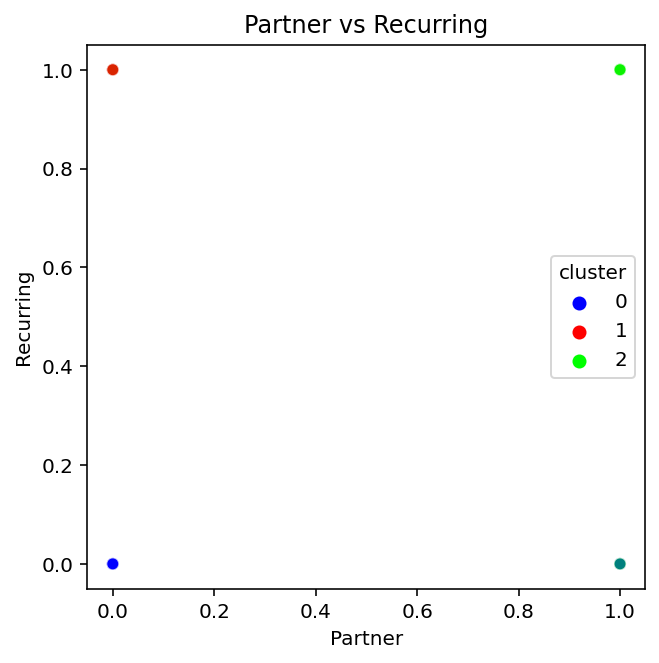

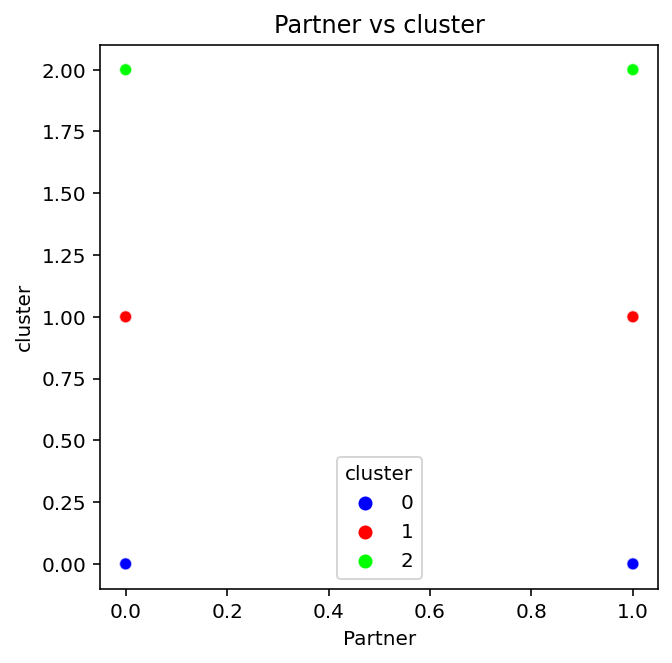

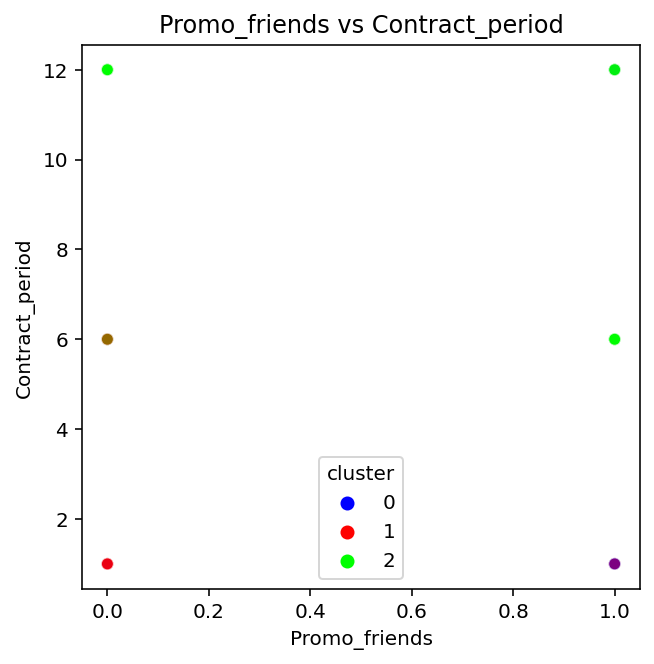

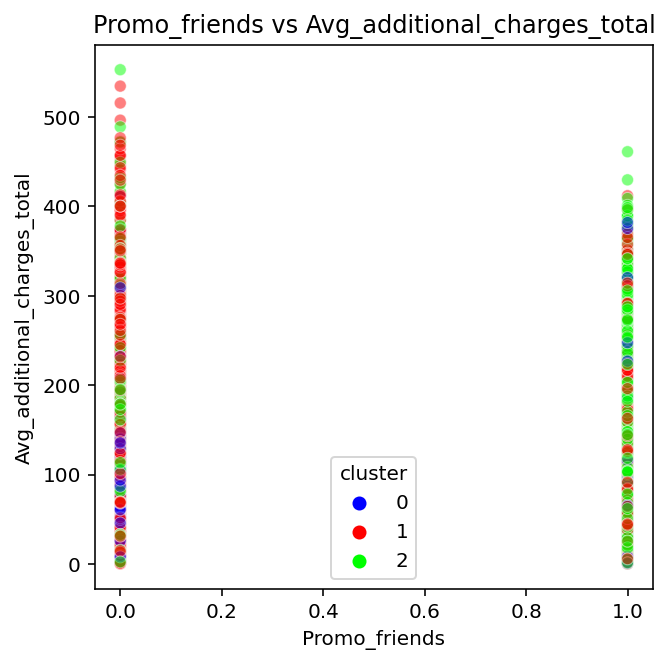

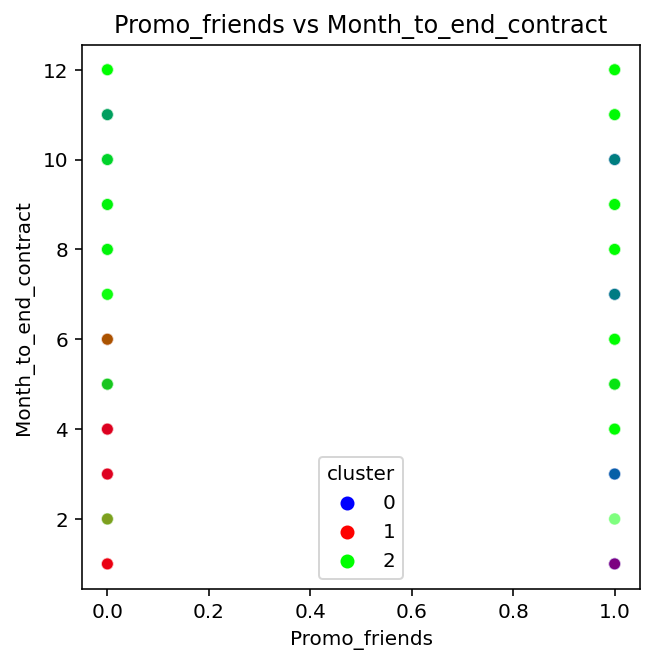

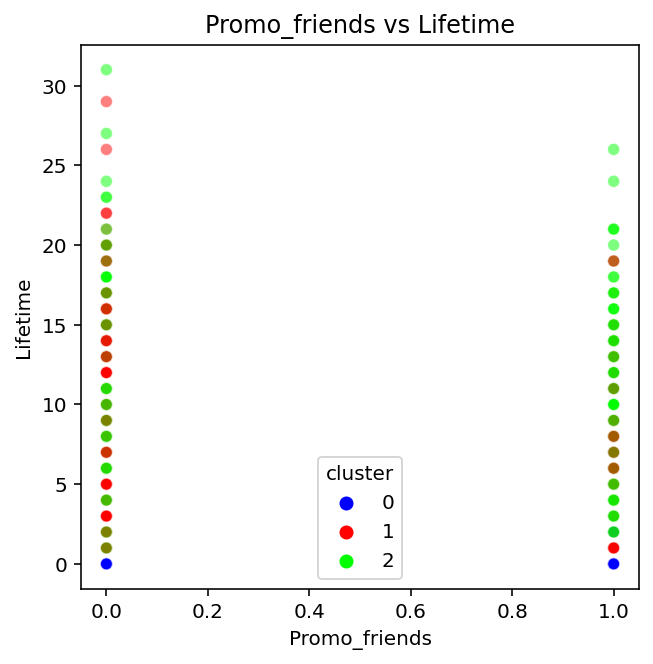

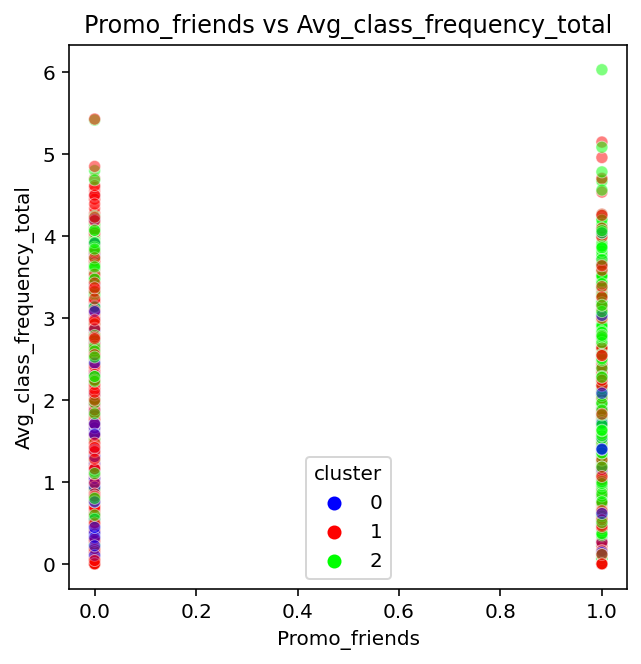

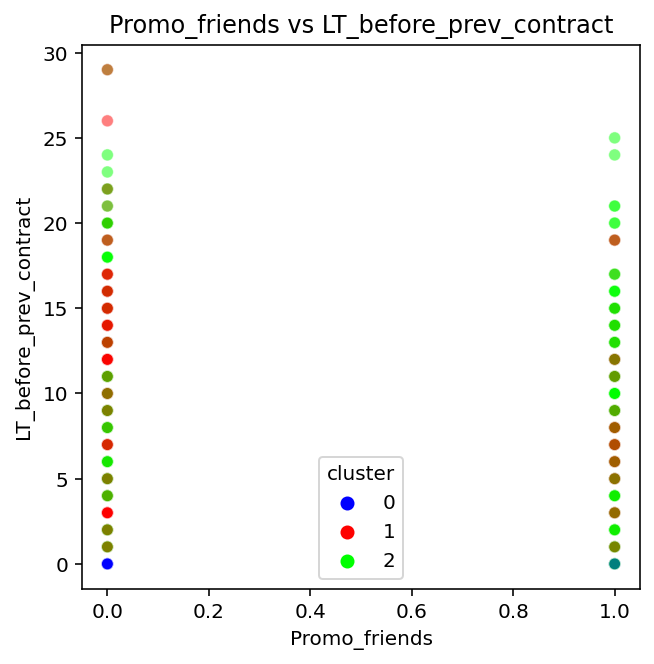

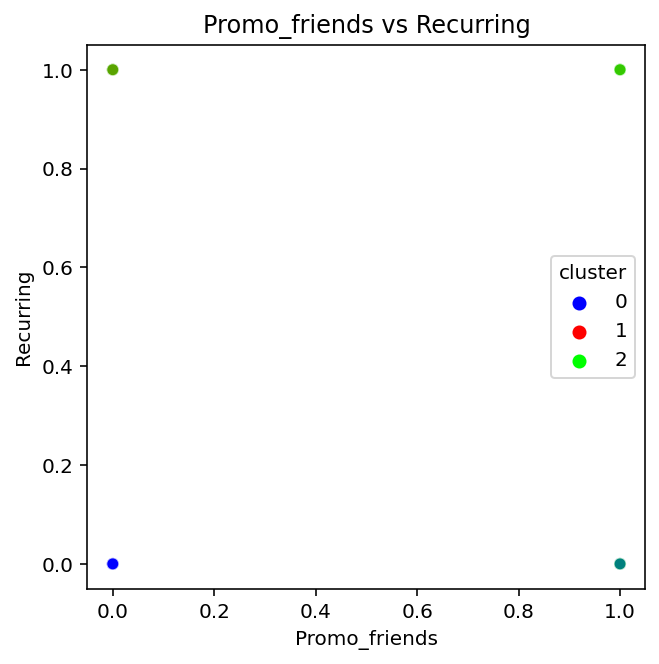

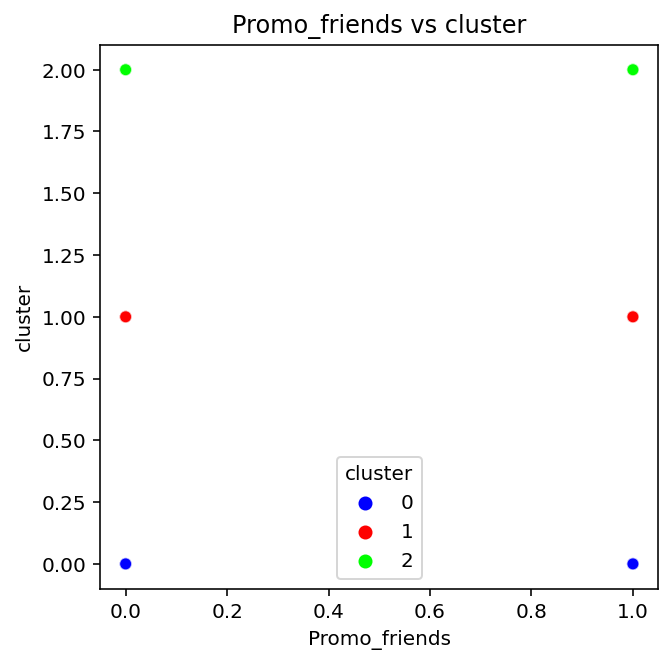

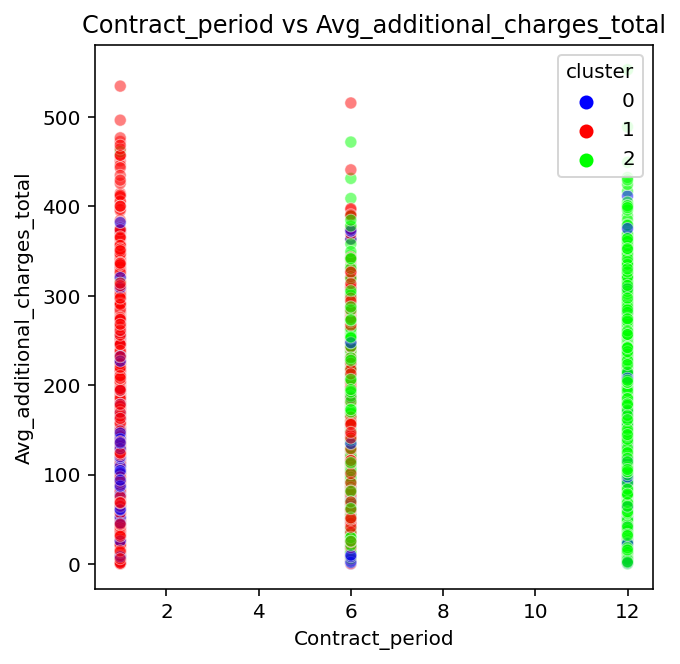

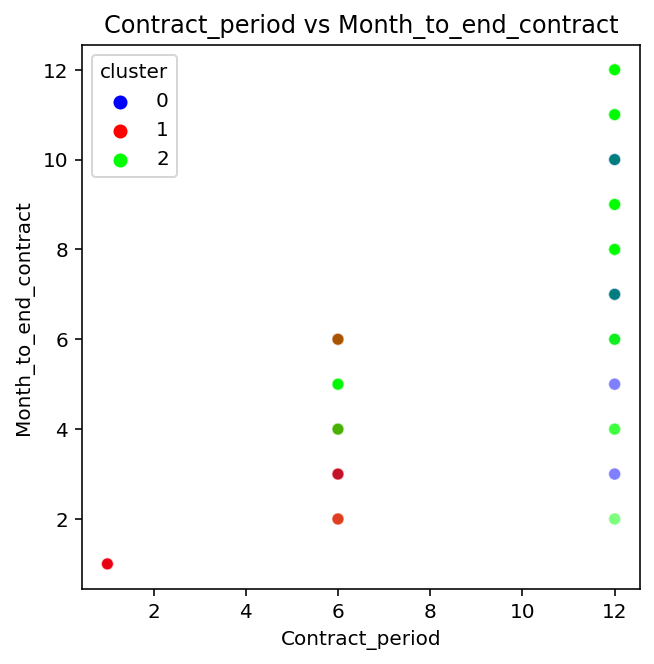

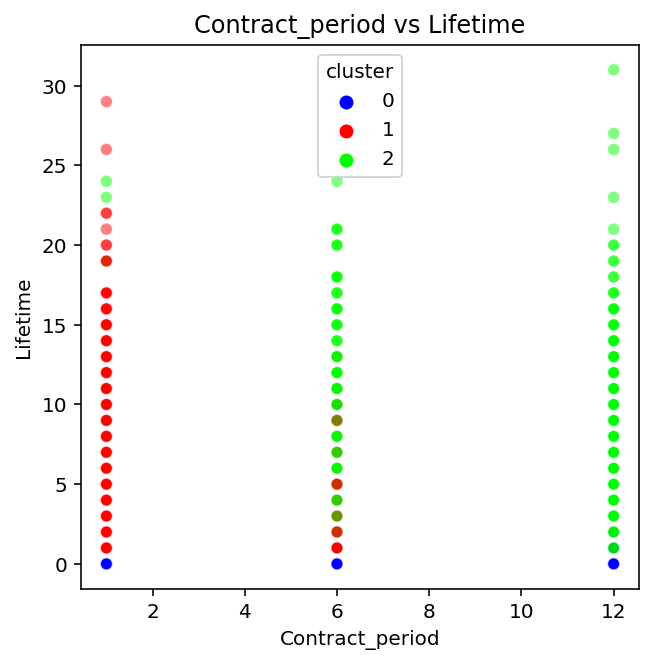

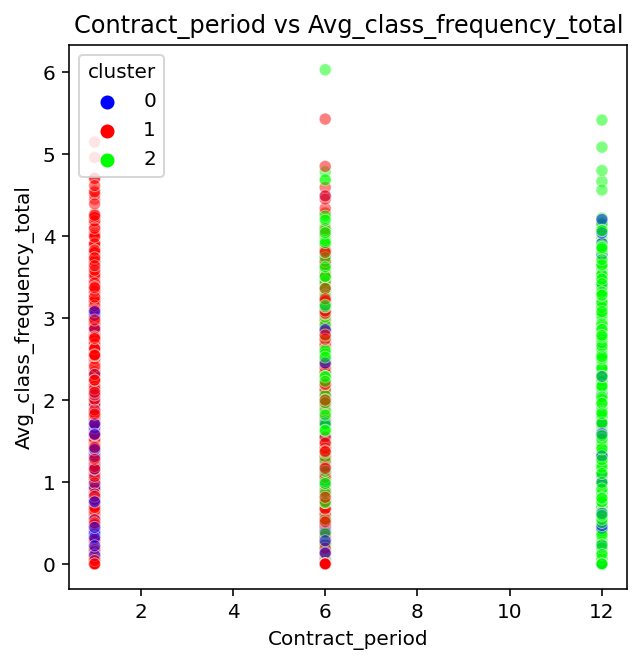

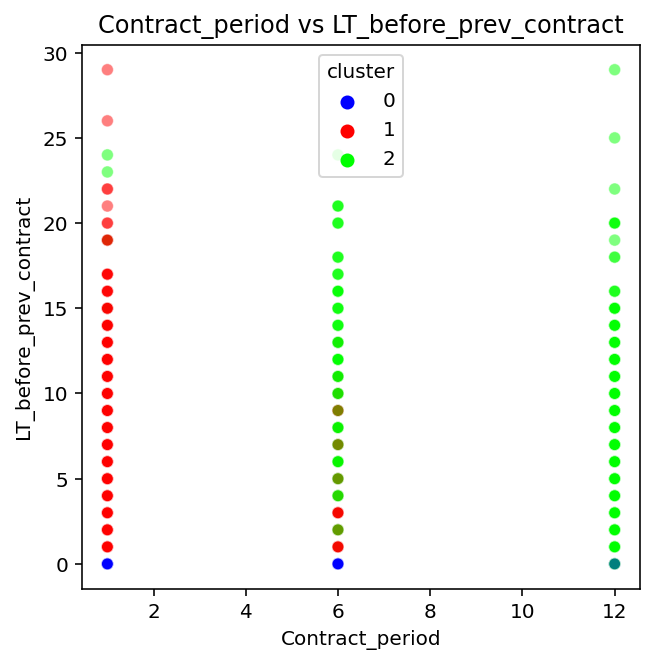

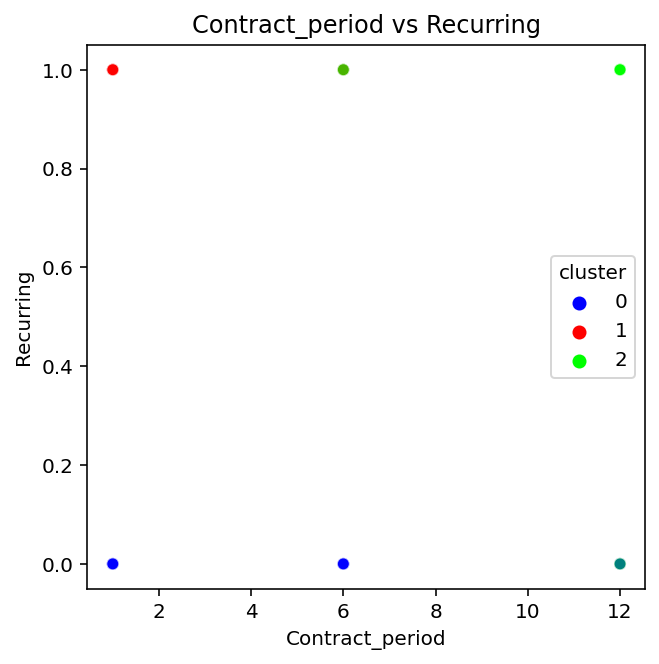

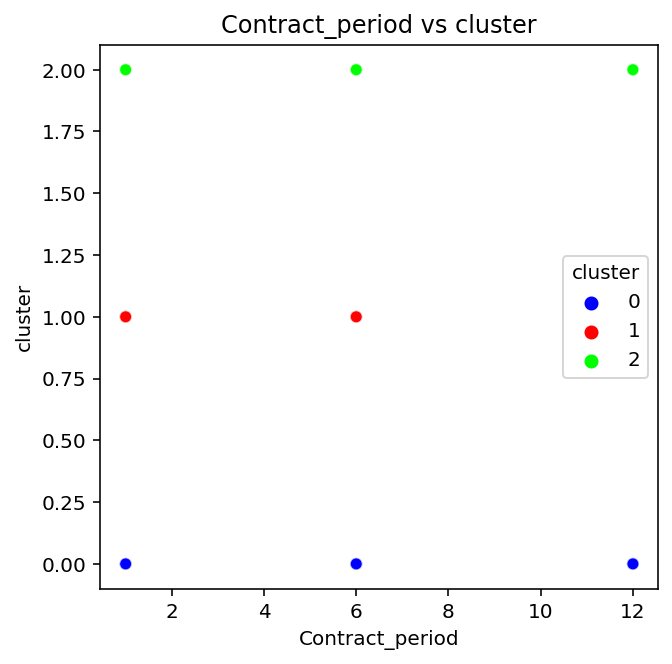

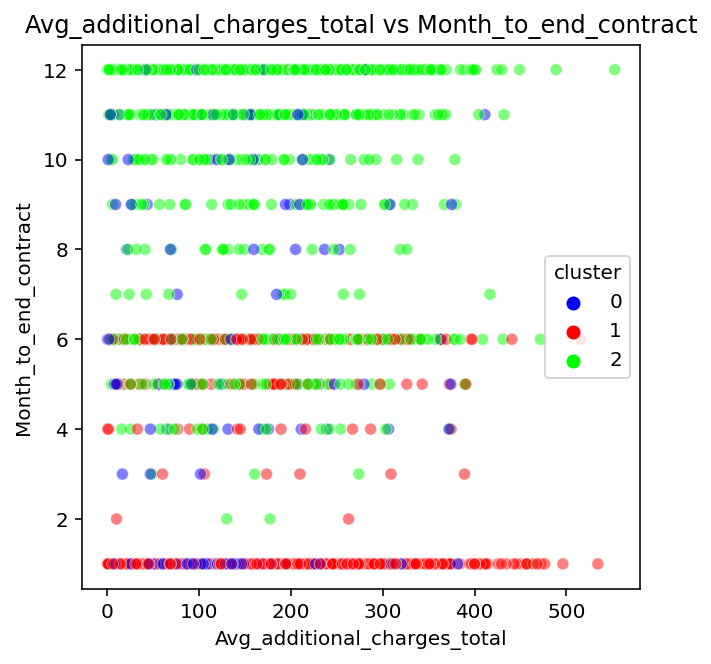

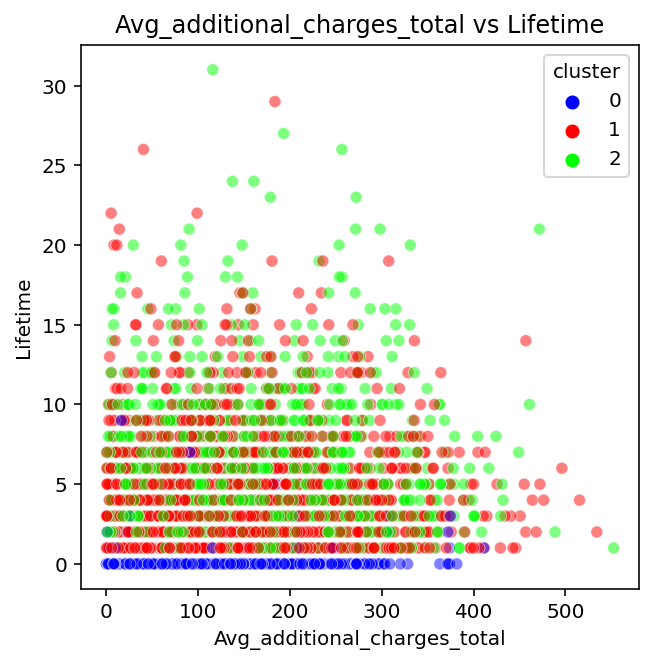

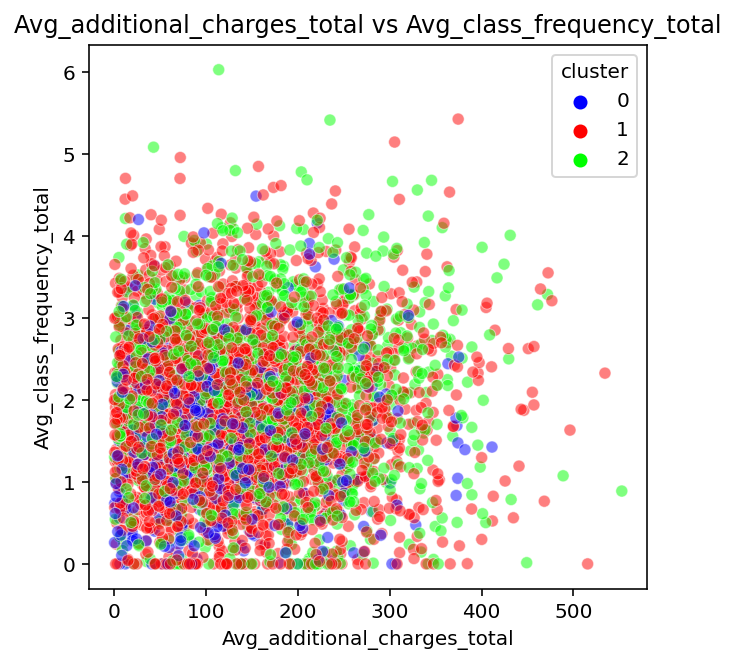

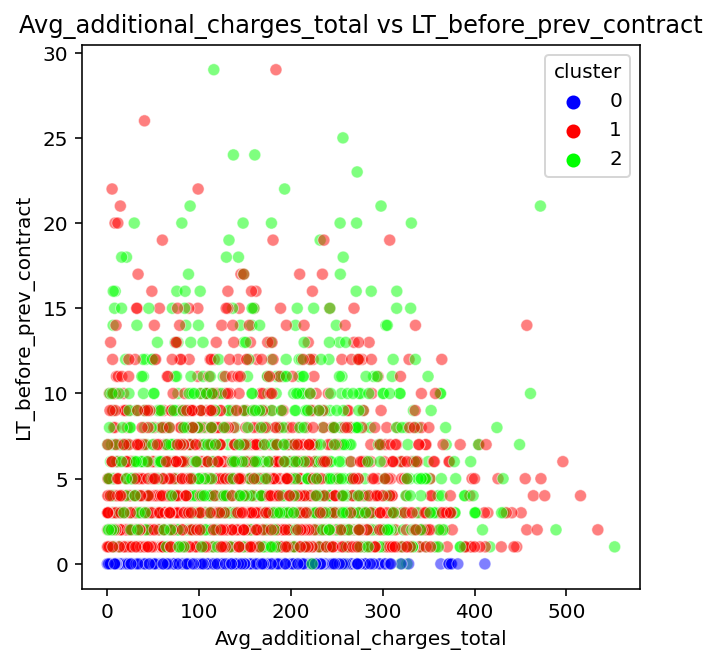

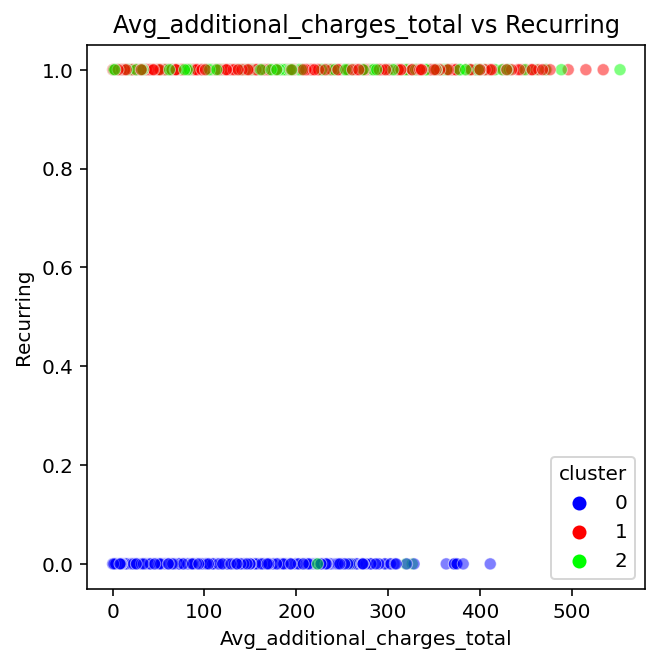

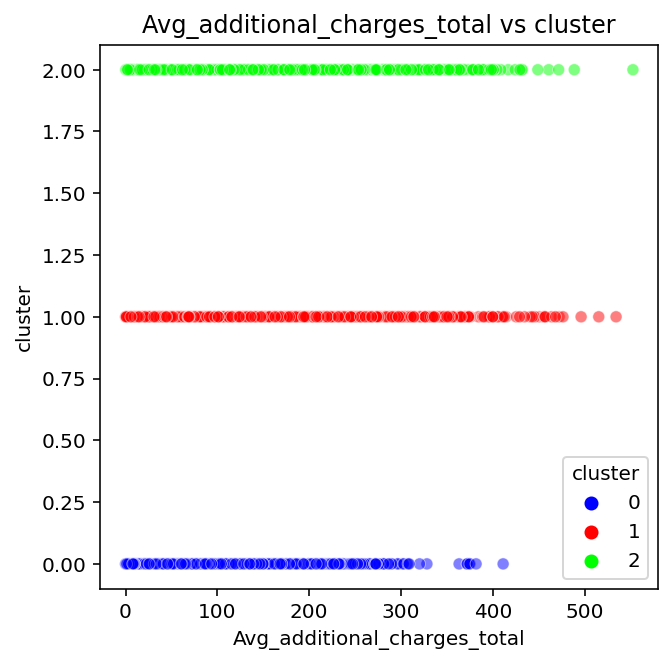

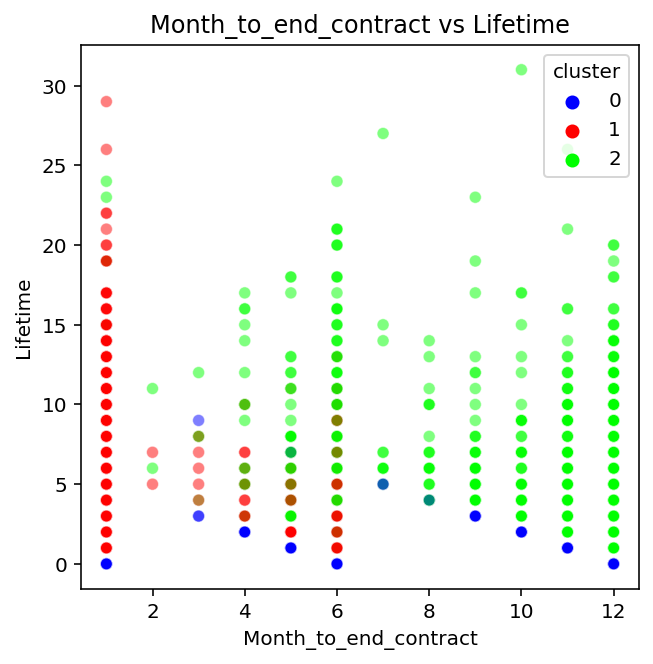

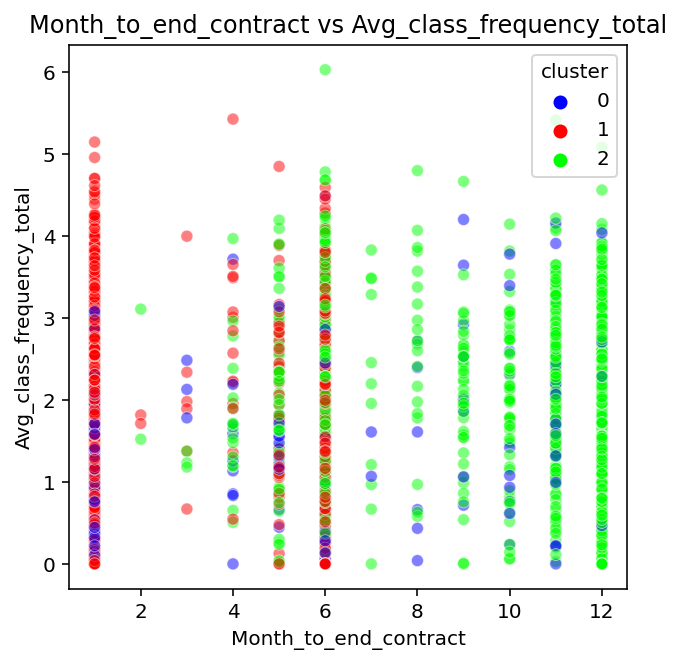

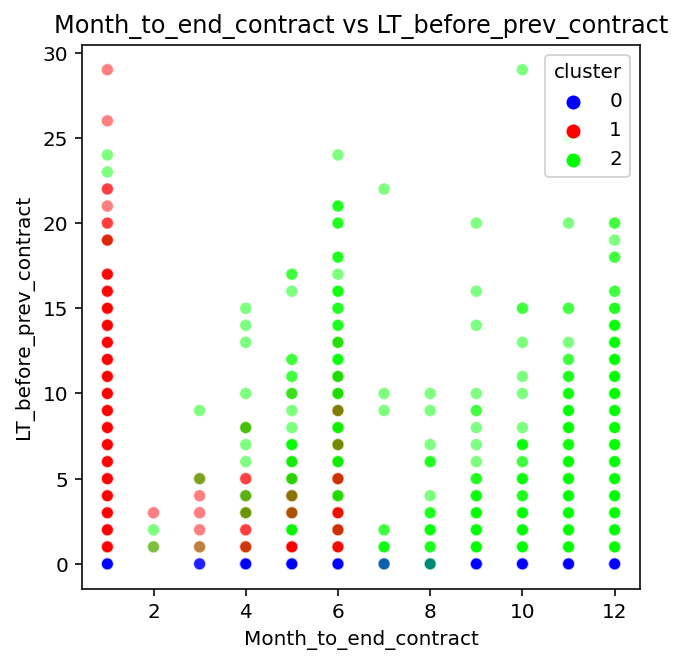

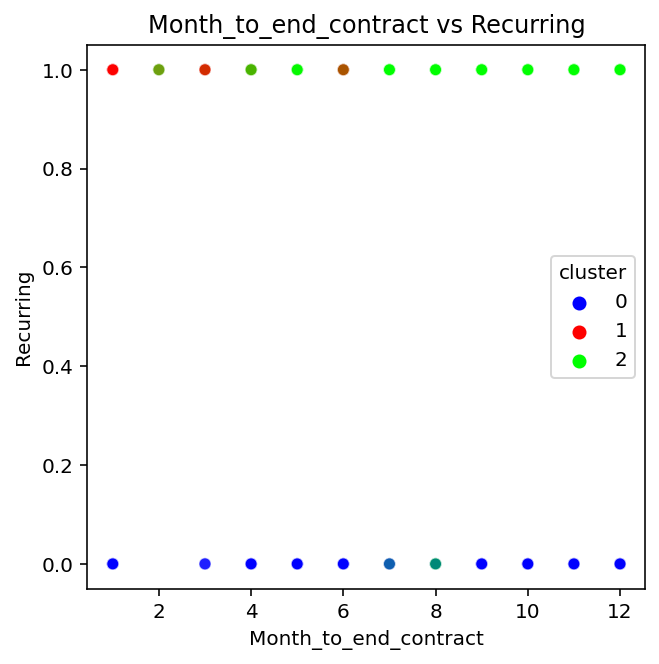

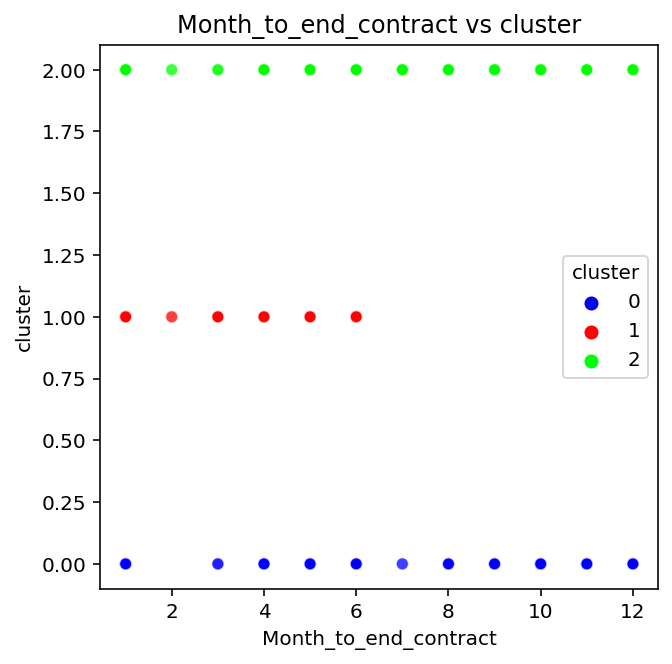

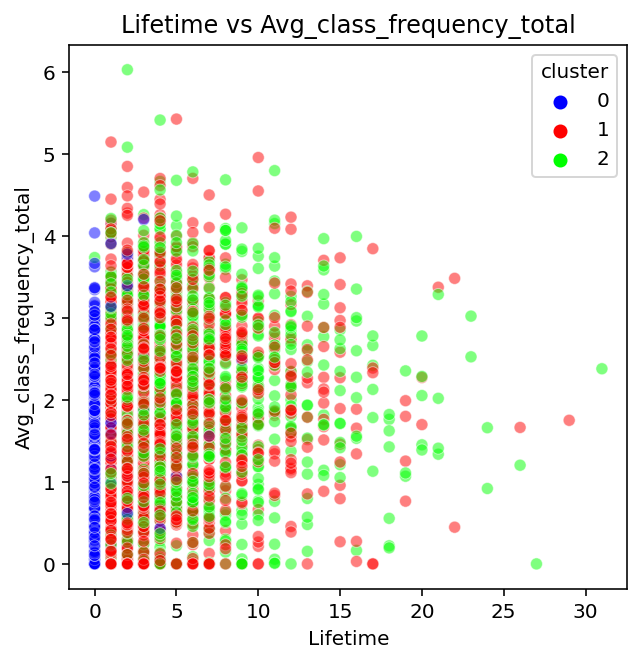

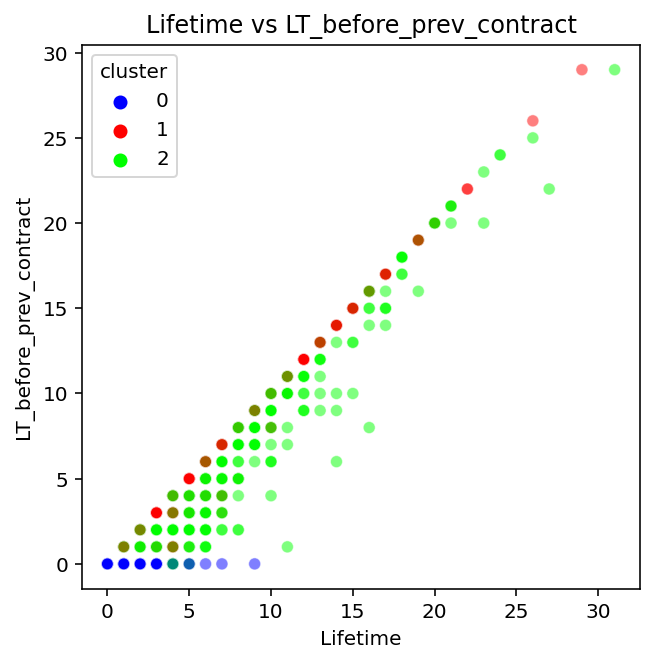

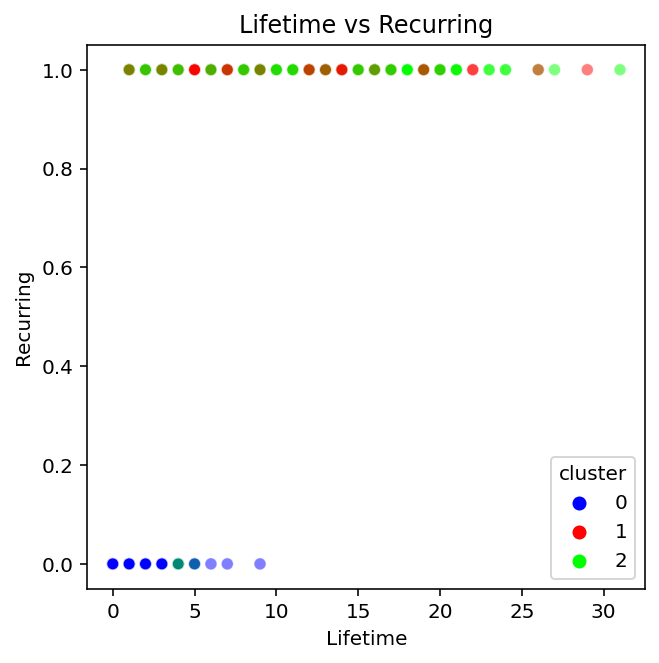

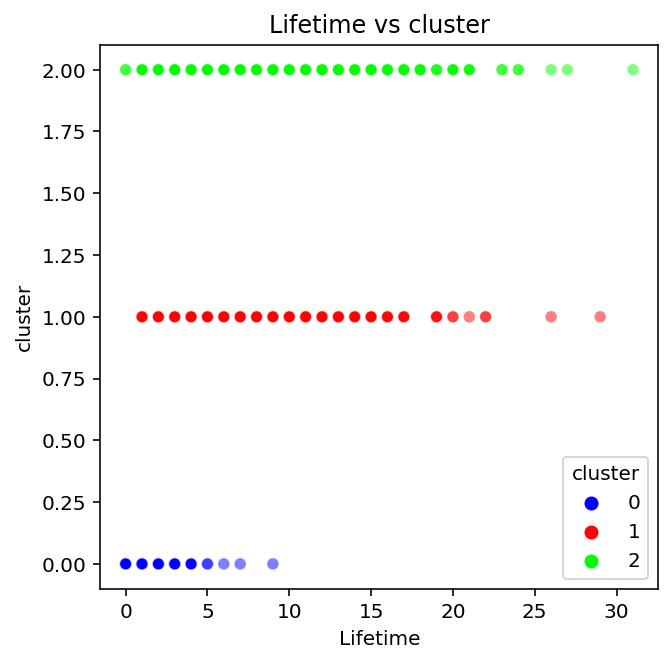

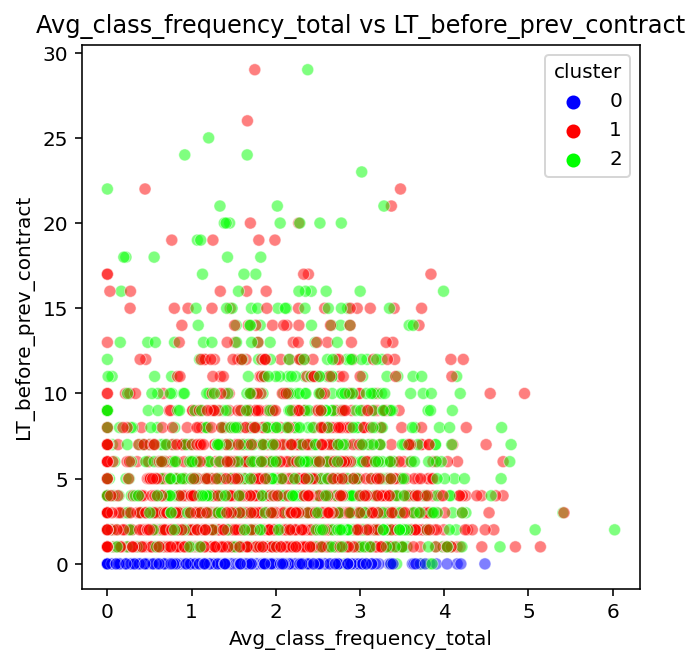

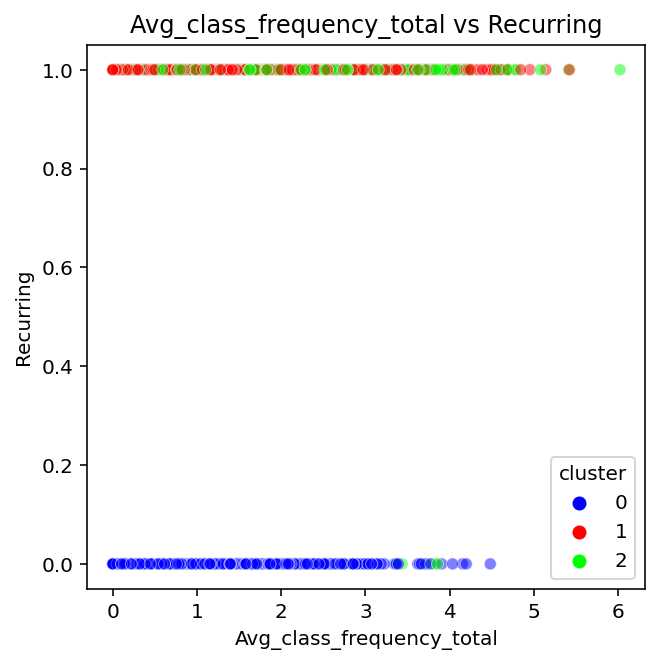

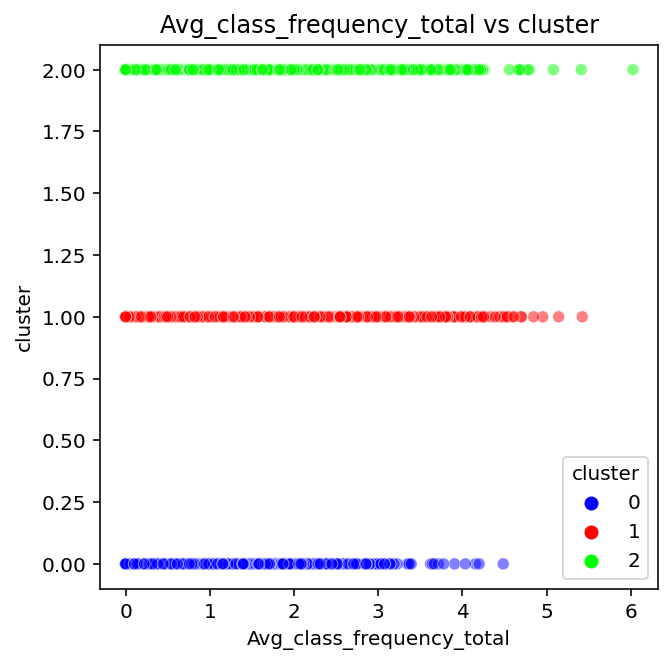

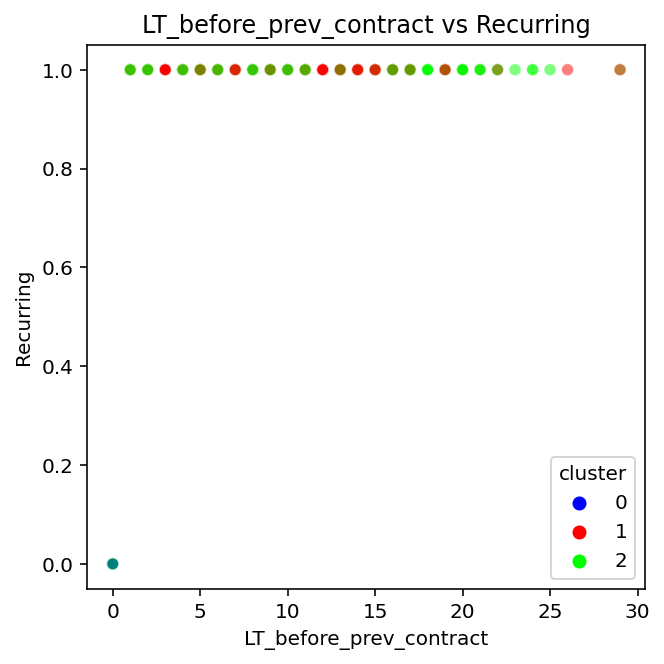

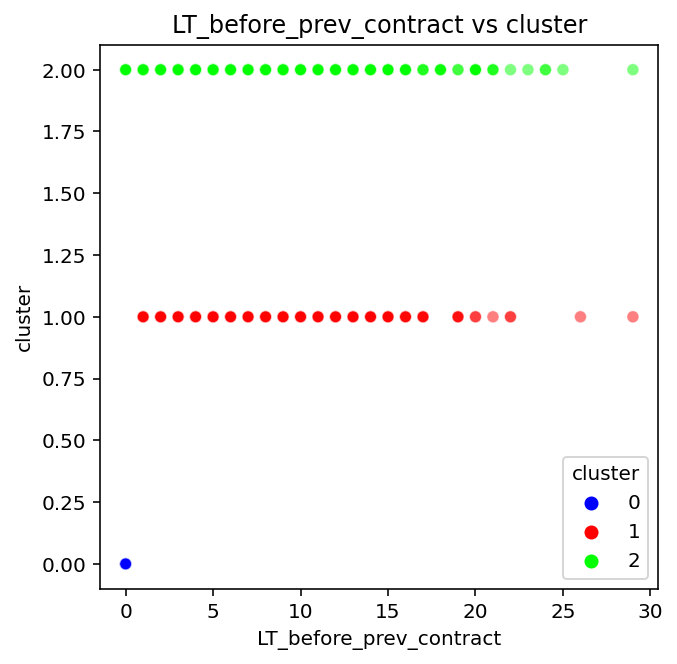

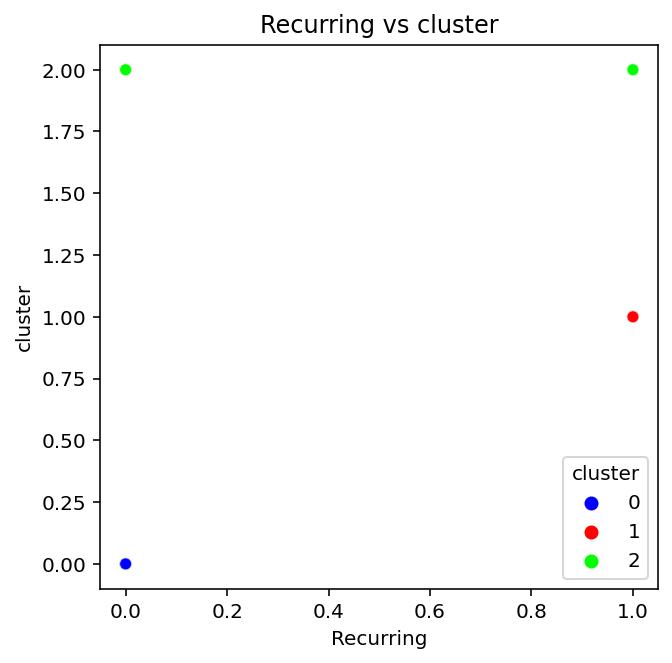

In [50]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(data_k.drop('Churn', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(data_k, pair[0], pair[1], 'cluster')

построим распределения признаков для кластеров

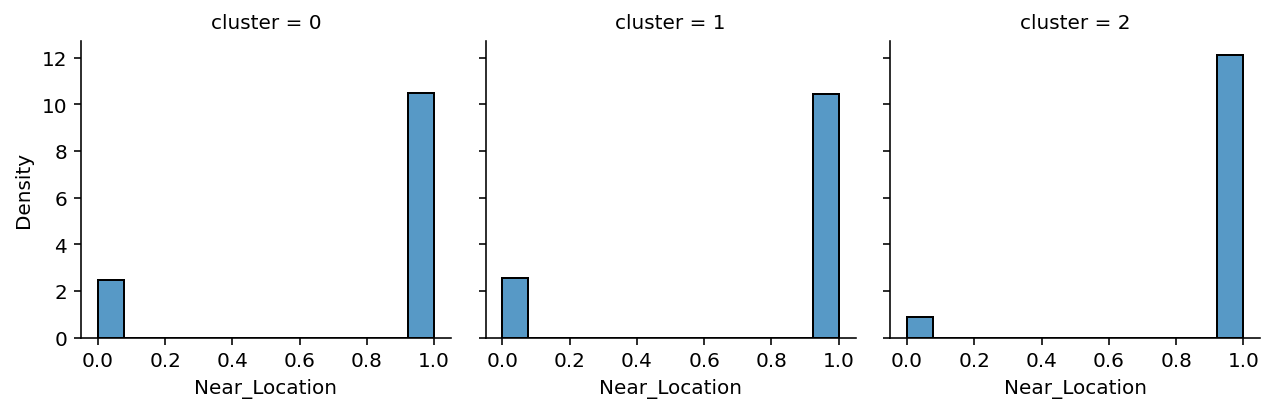

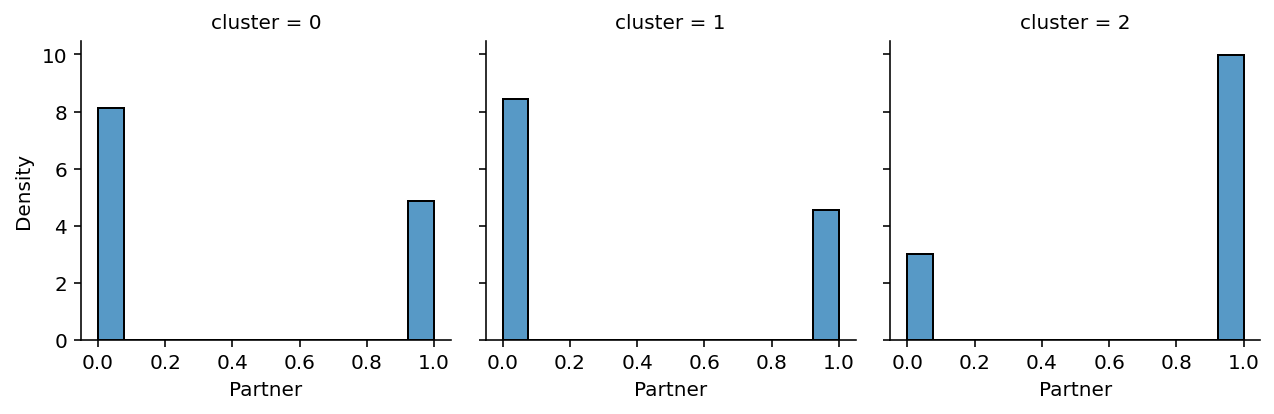

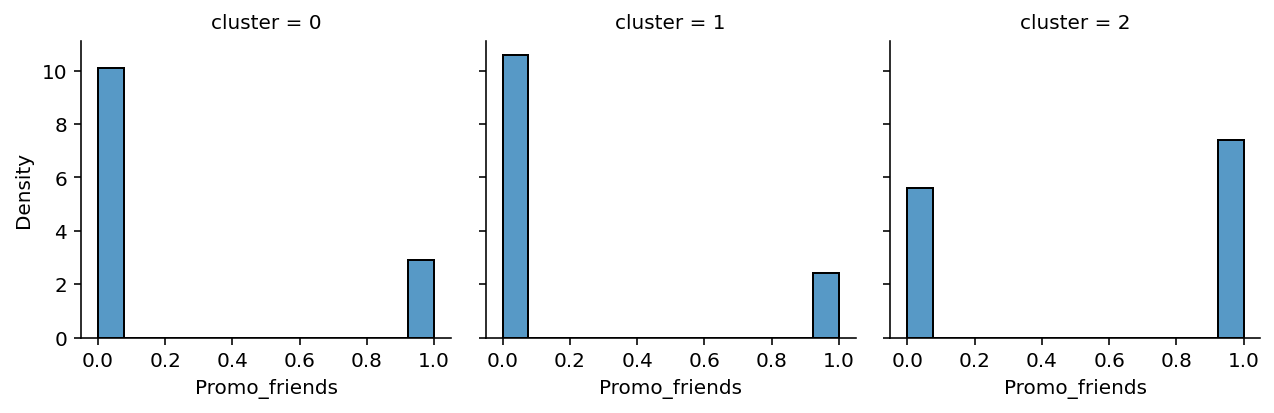

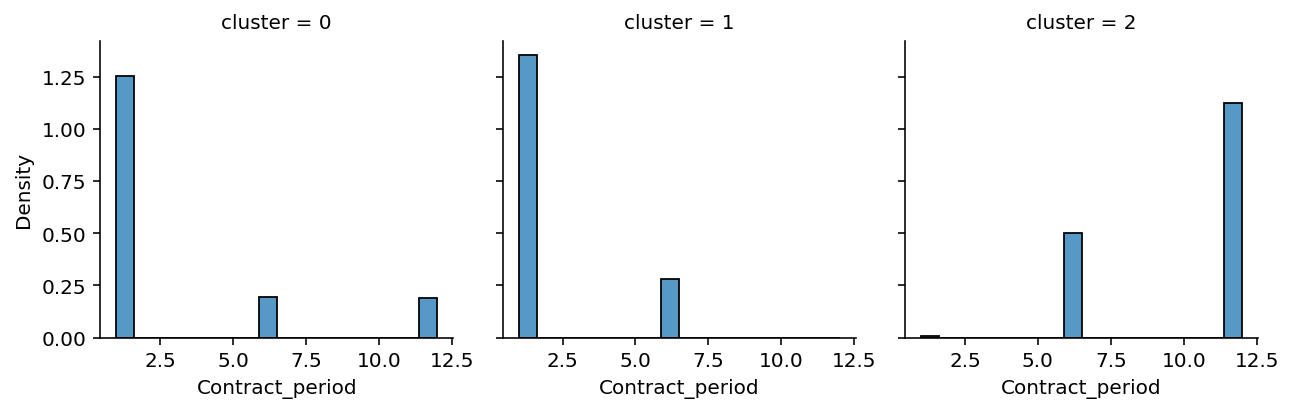

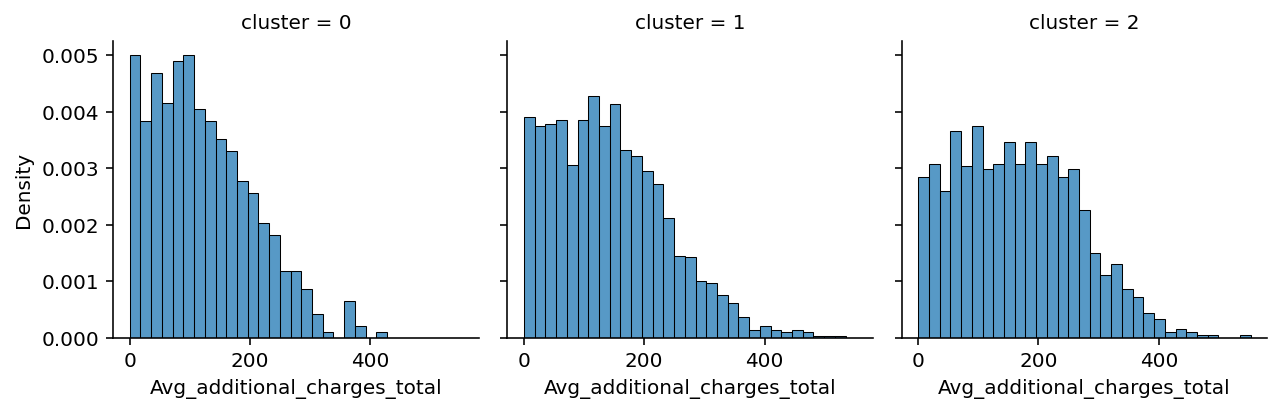

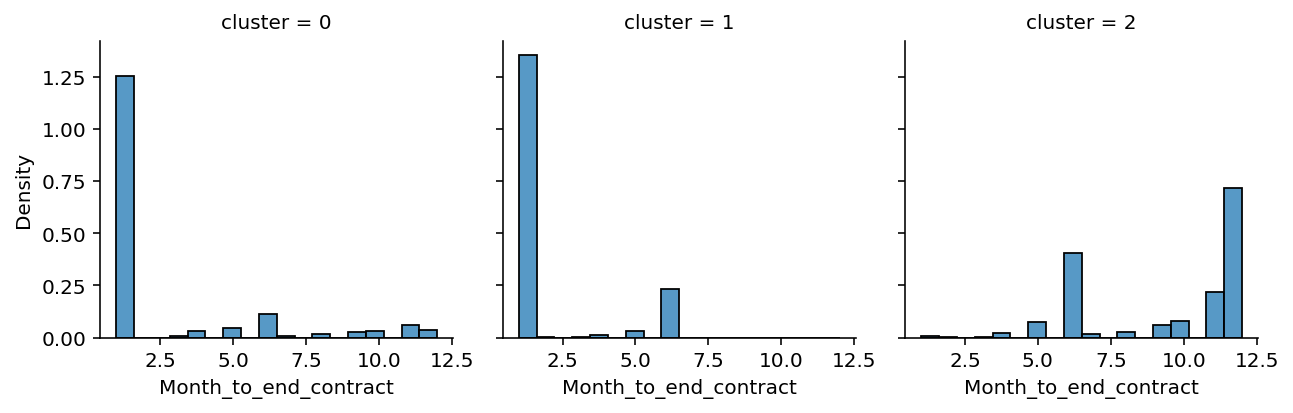

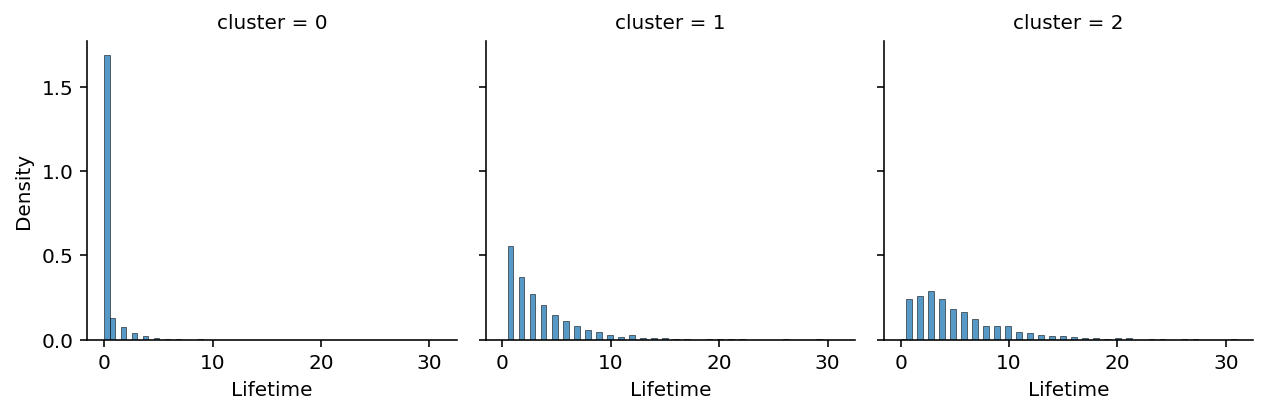

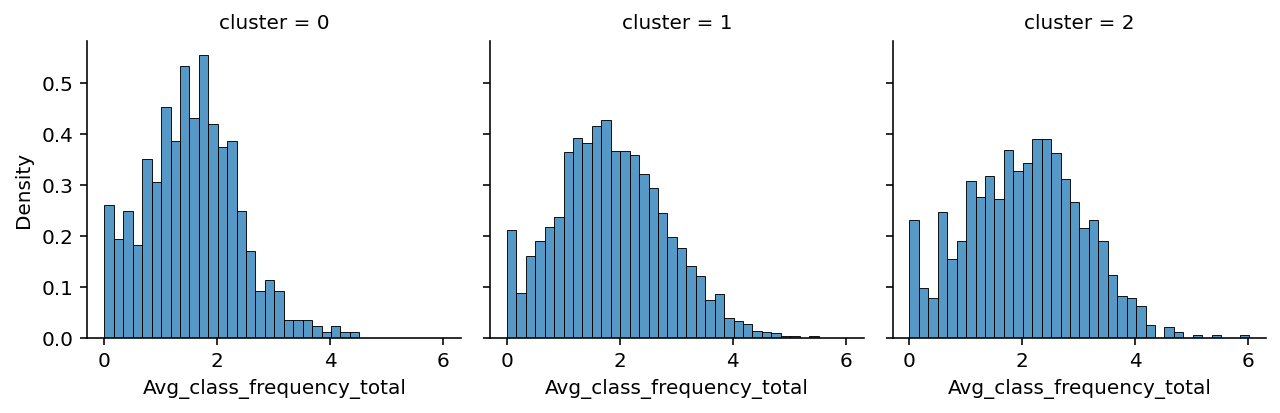

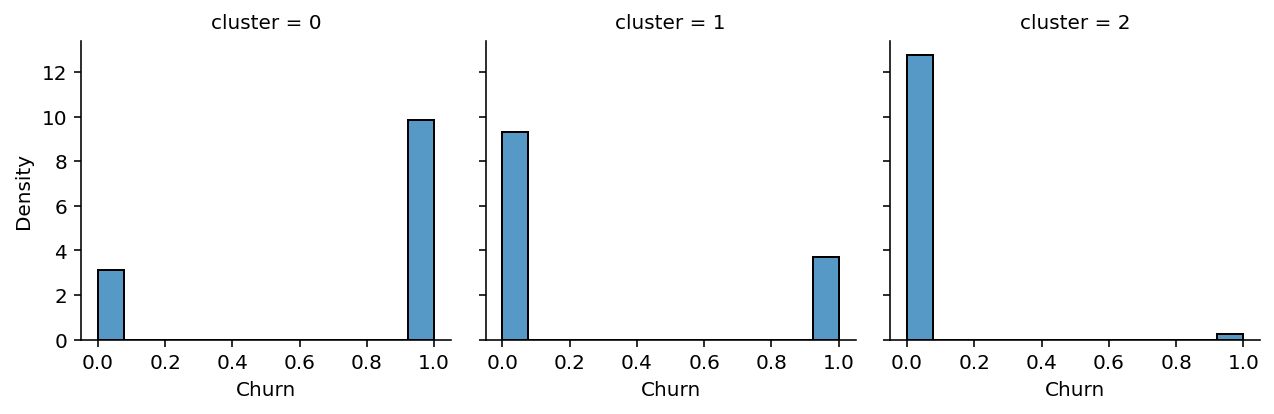

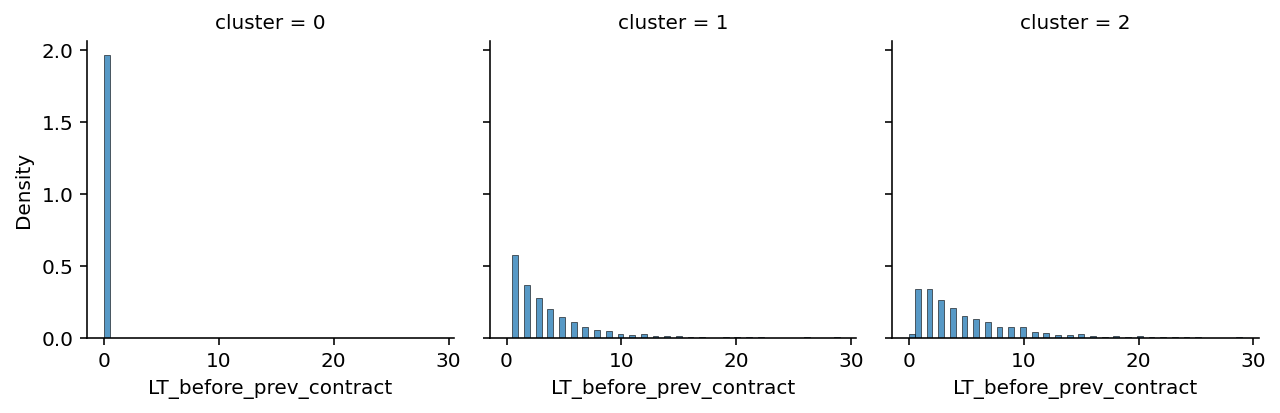

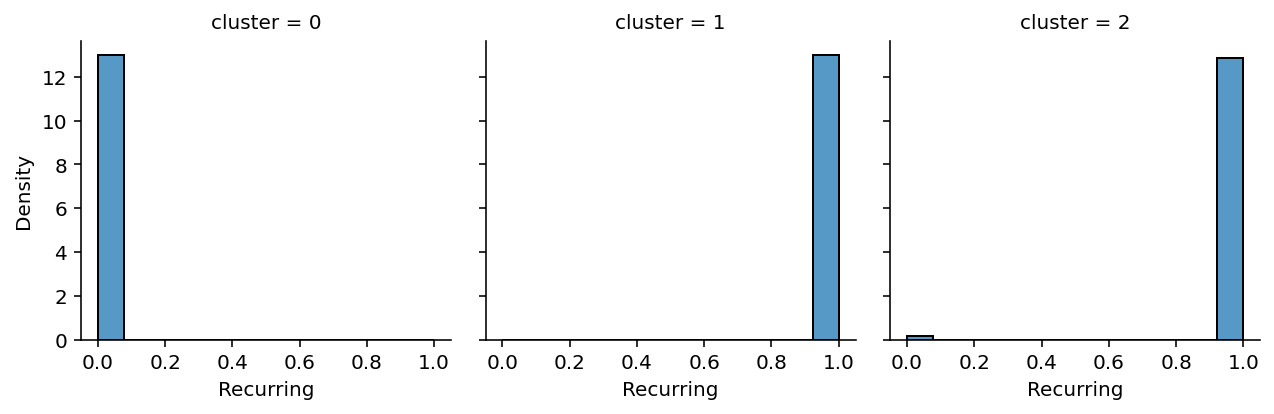

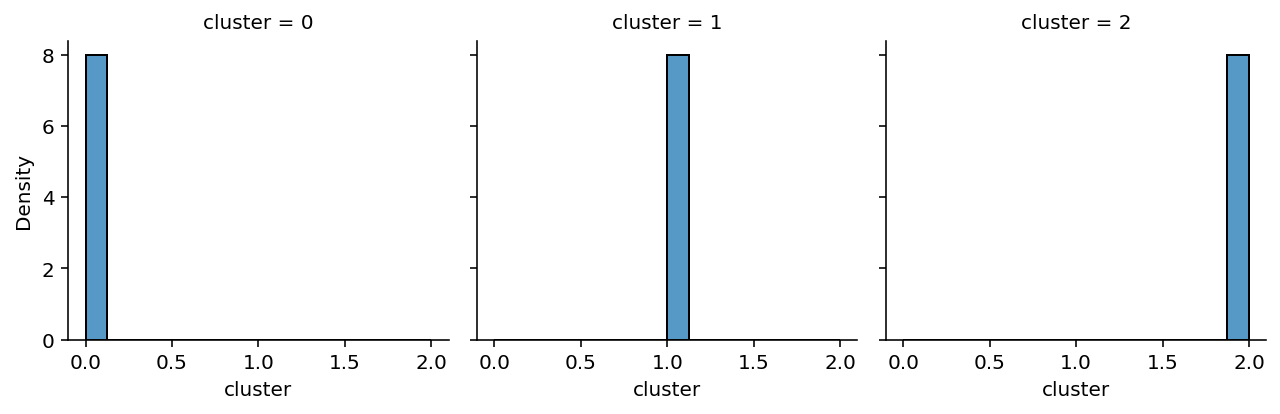

In [51]:
for i in data_k.columns:

    sns.displot(
        data_k, x=i, col="cluster", stat="density", common_norm=False,
        height=3, facet_kws=dict(margin_titles=True),
    );

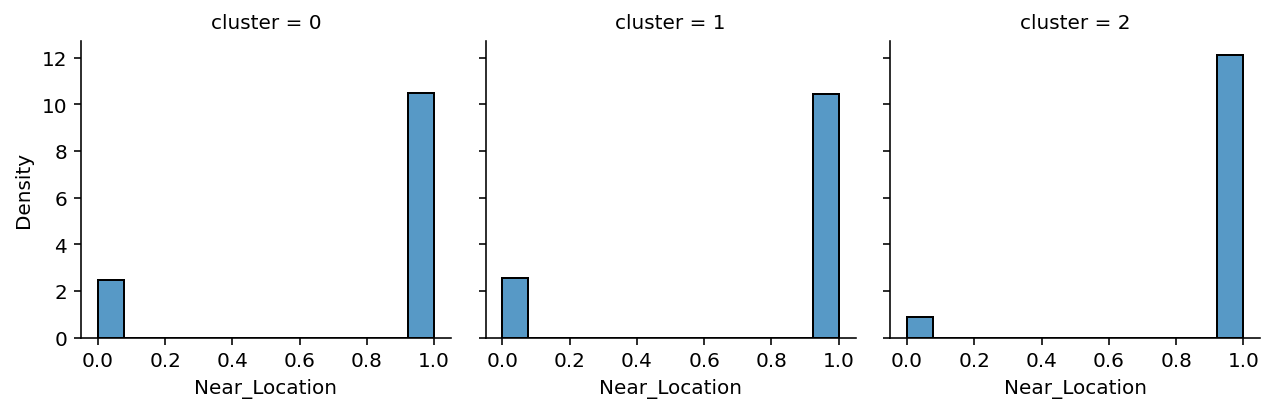

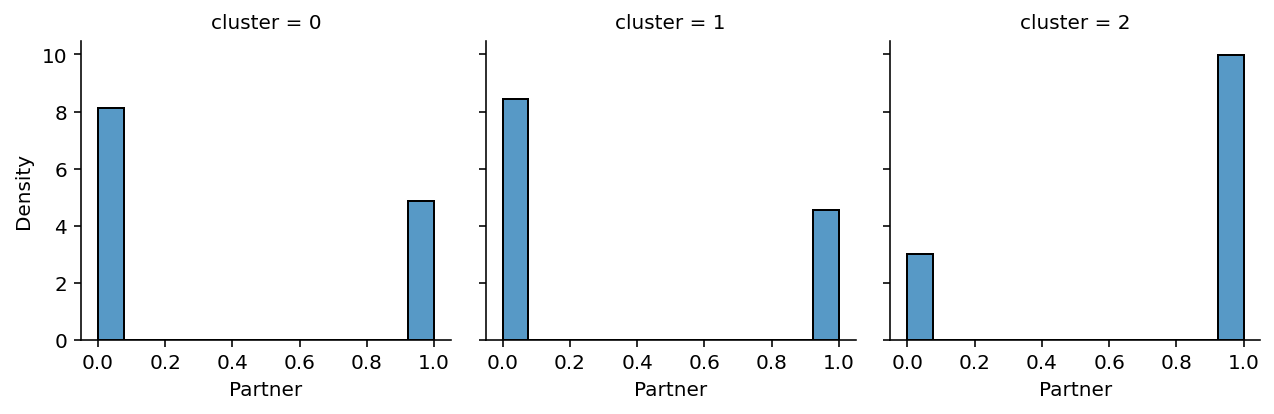

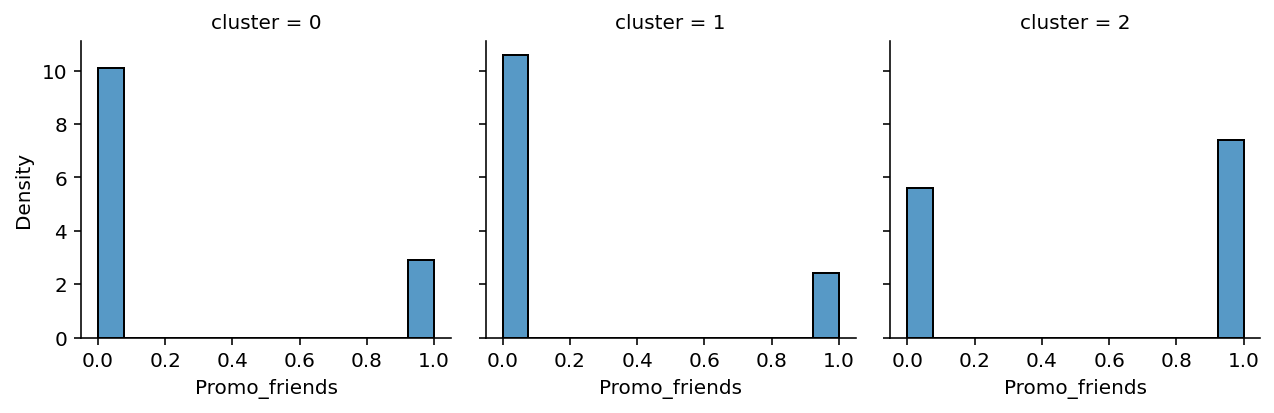

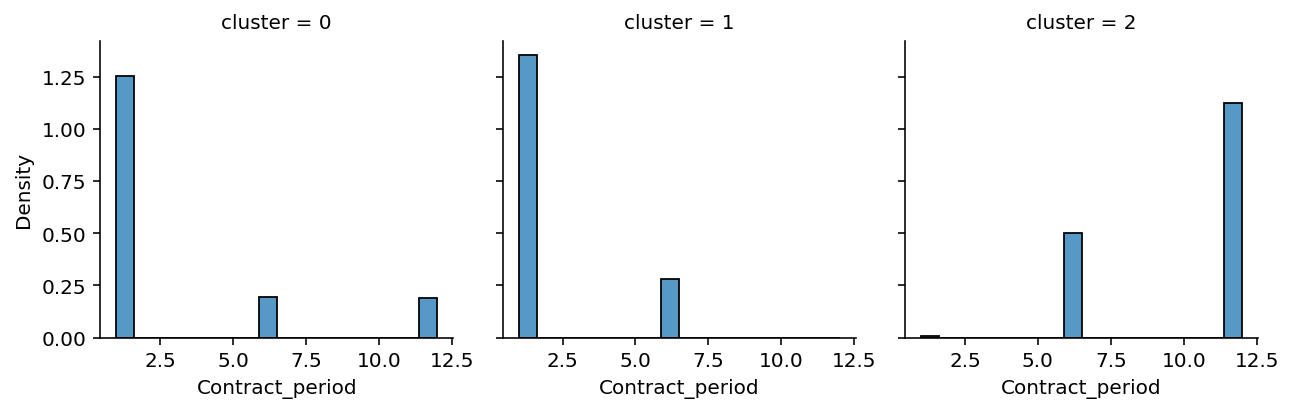

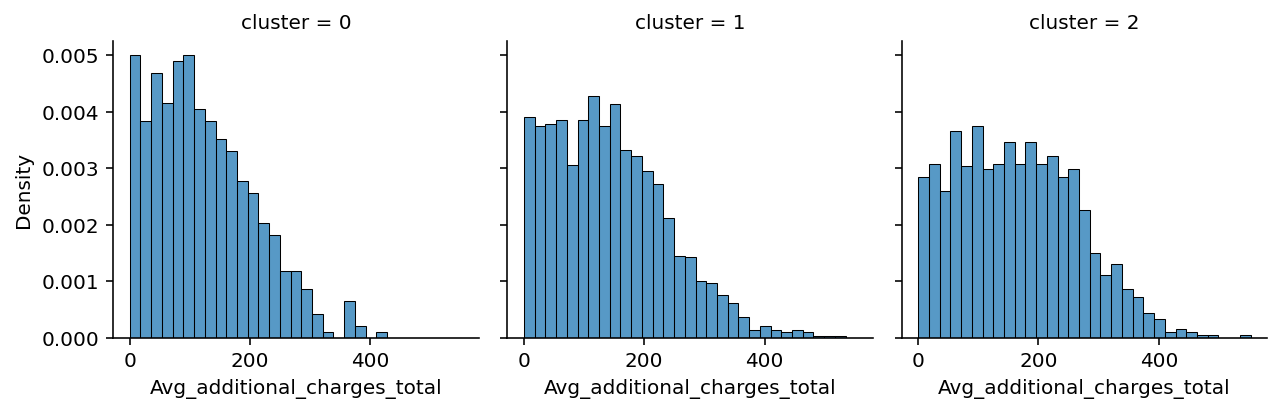

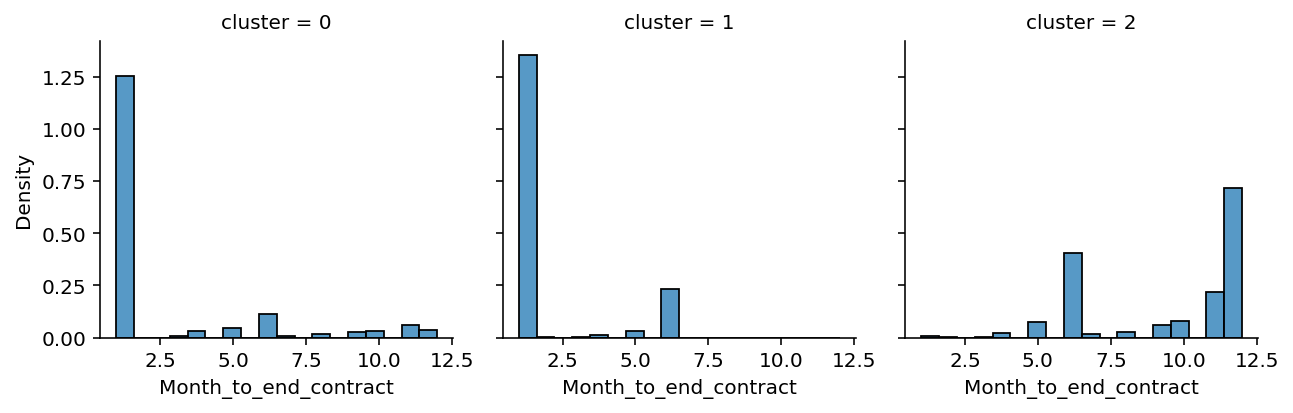

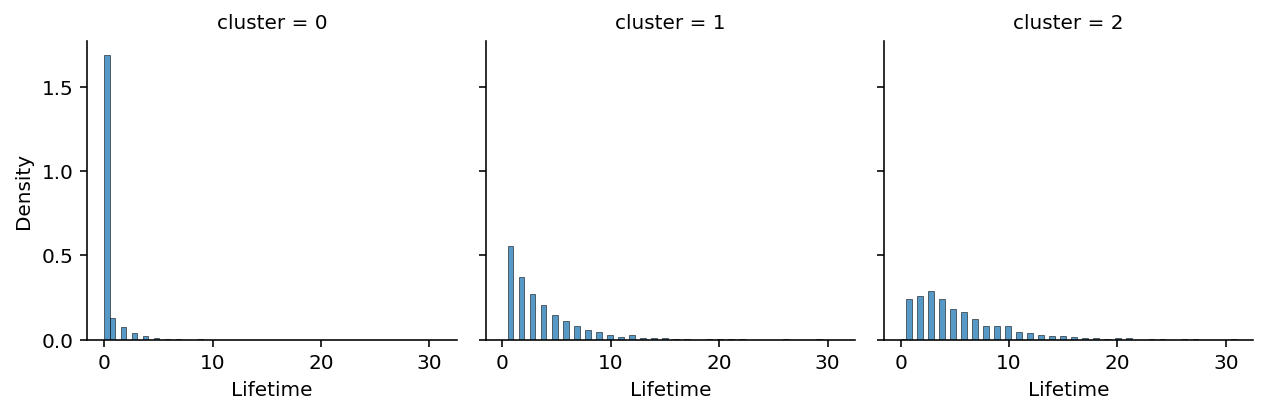

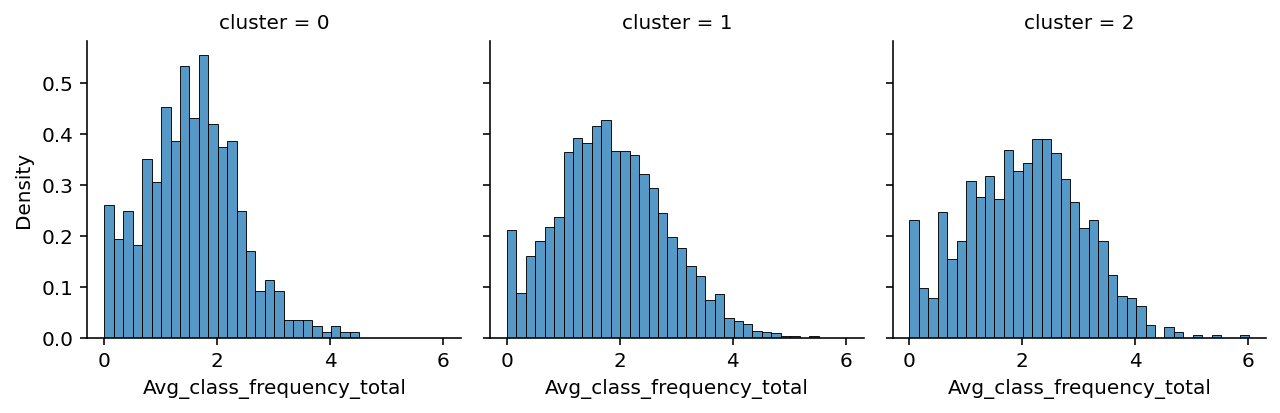

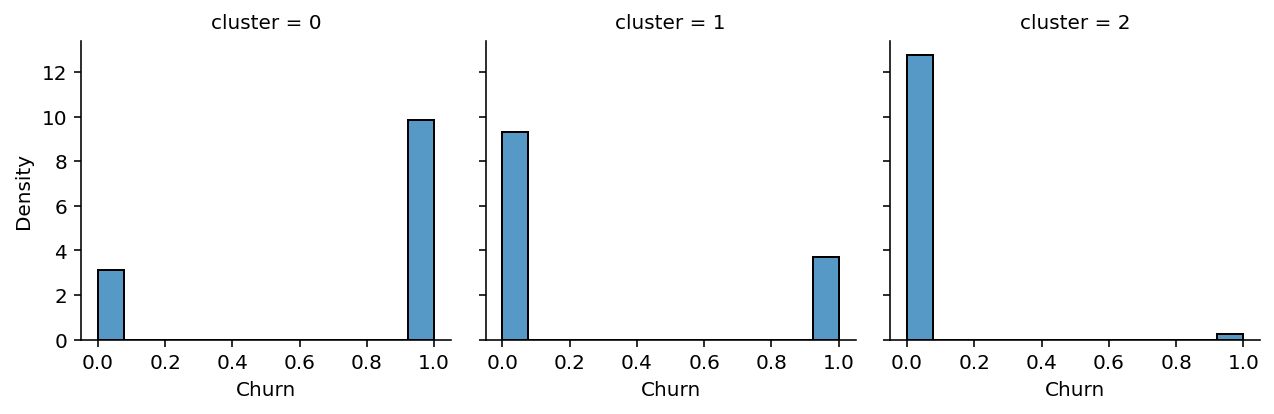

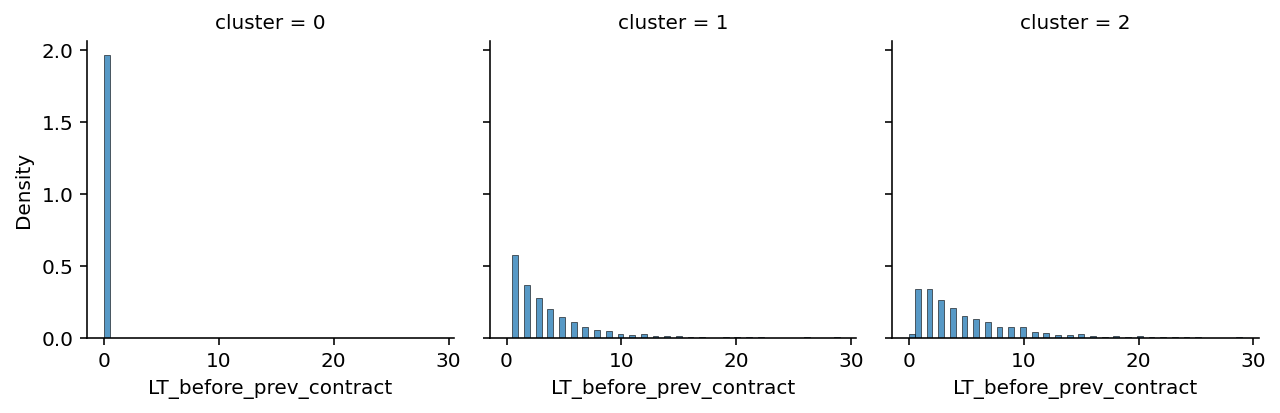

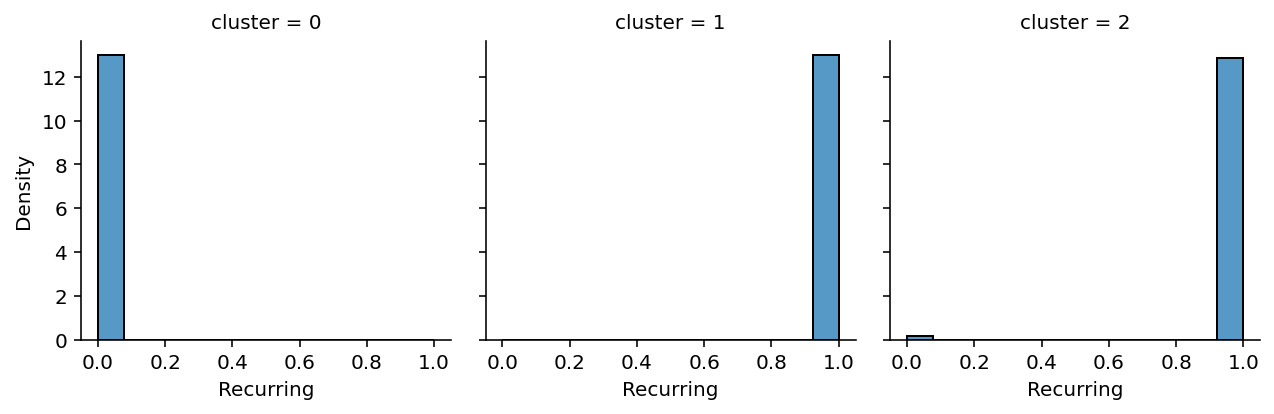

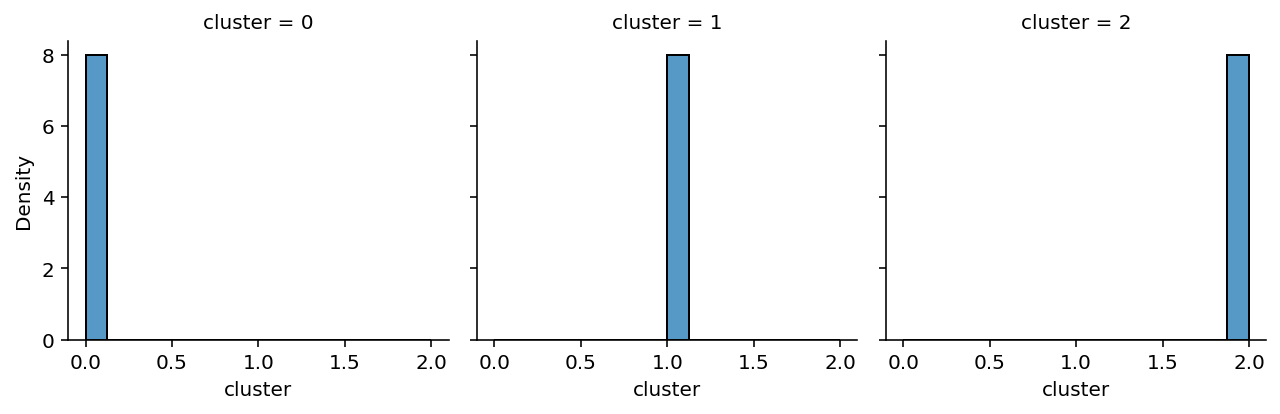

In [52]:
for i in data_k.columns:

    sns.displot(
        data_k, x=i, col="cluster", stat="density", common_norm=False,
        height=3, facet_kws=dict(margin_titles=True)
    );

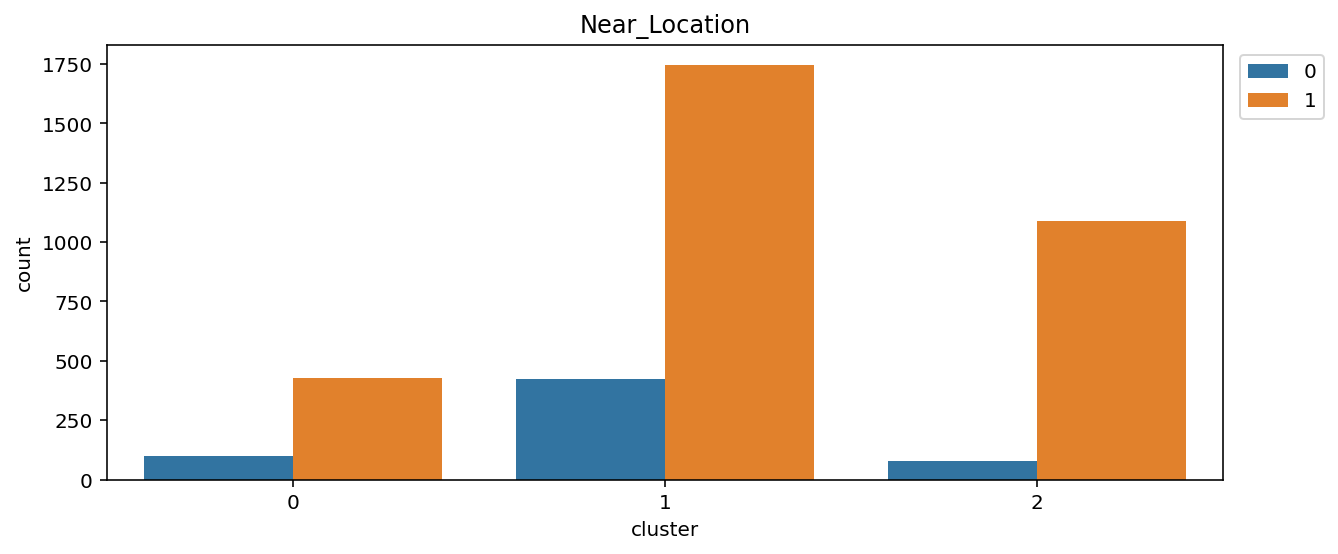

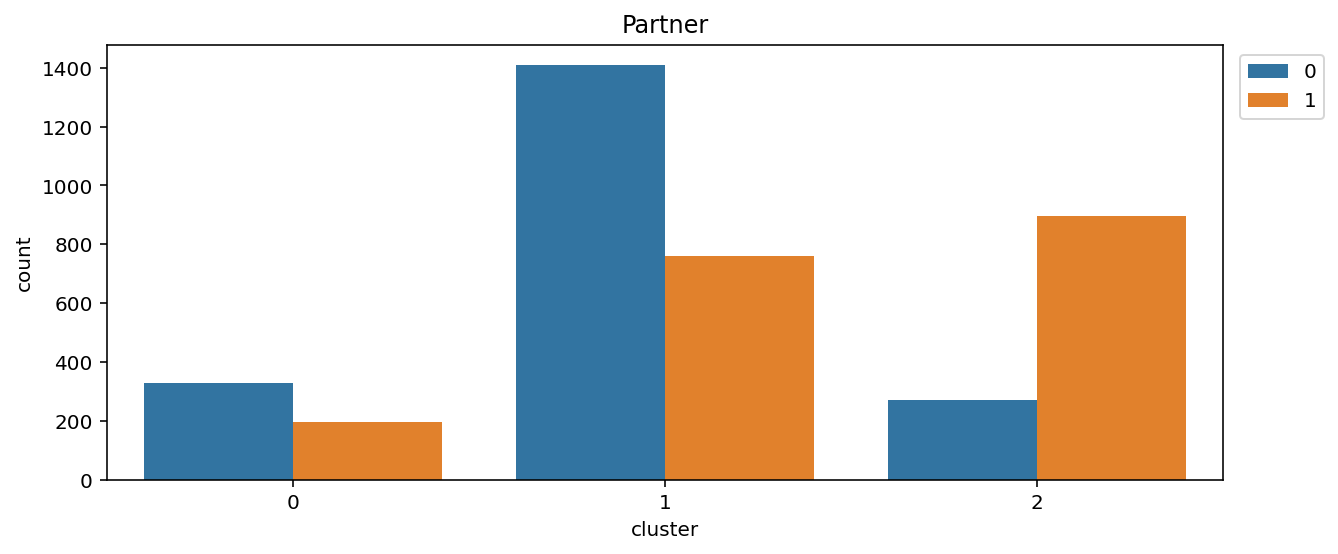

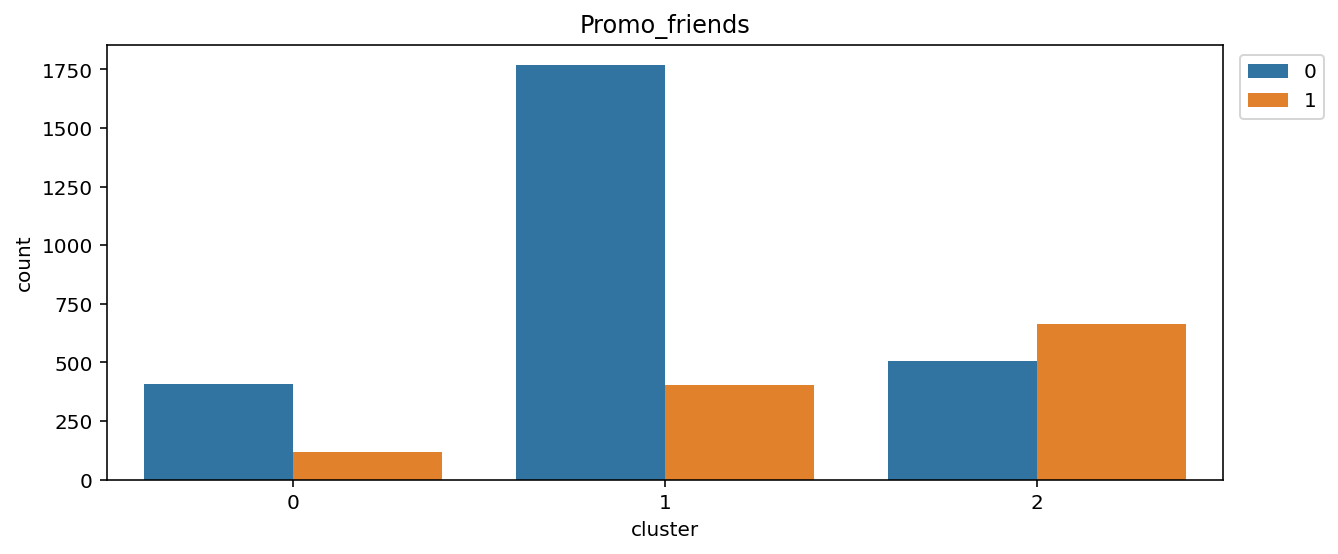

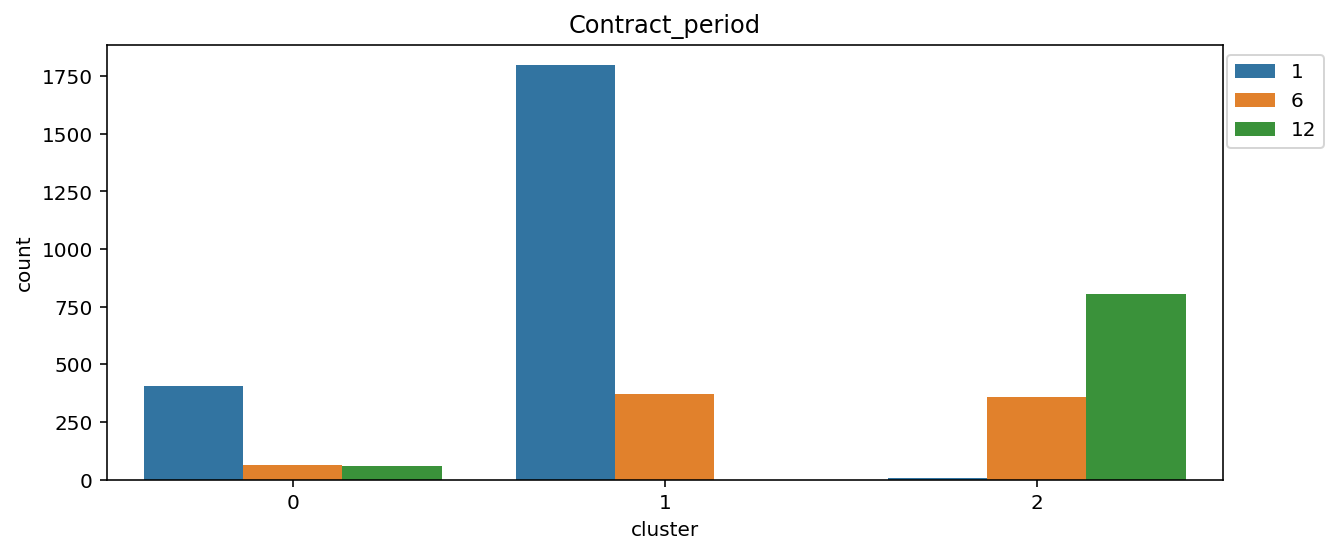

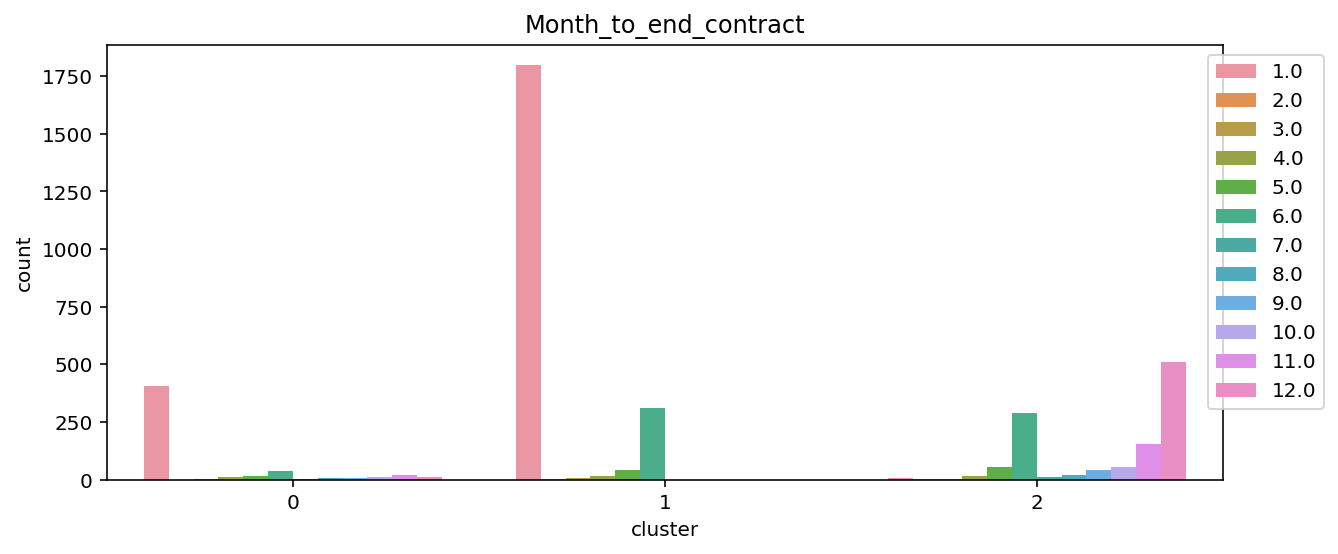

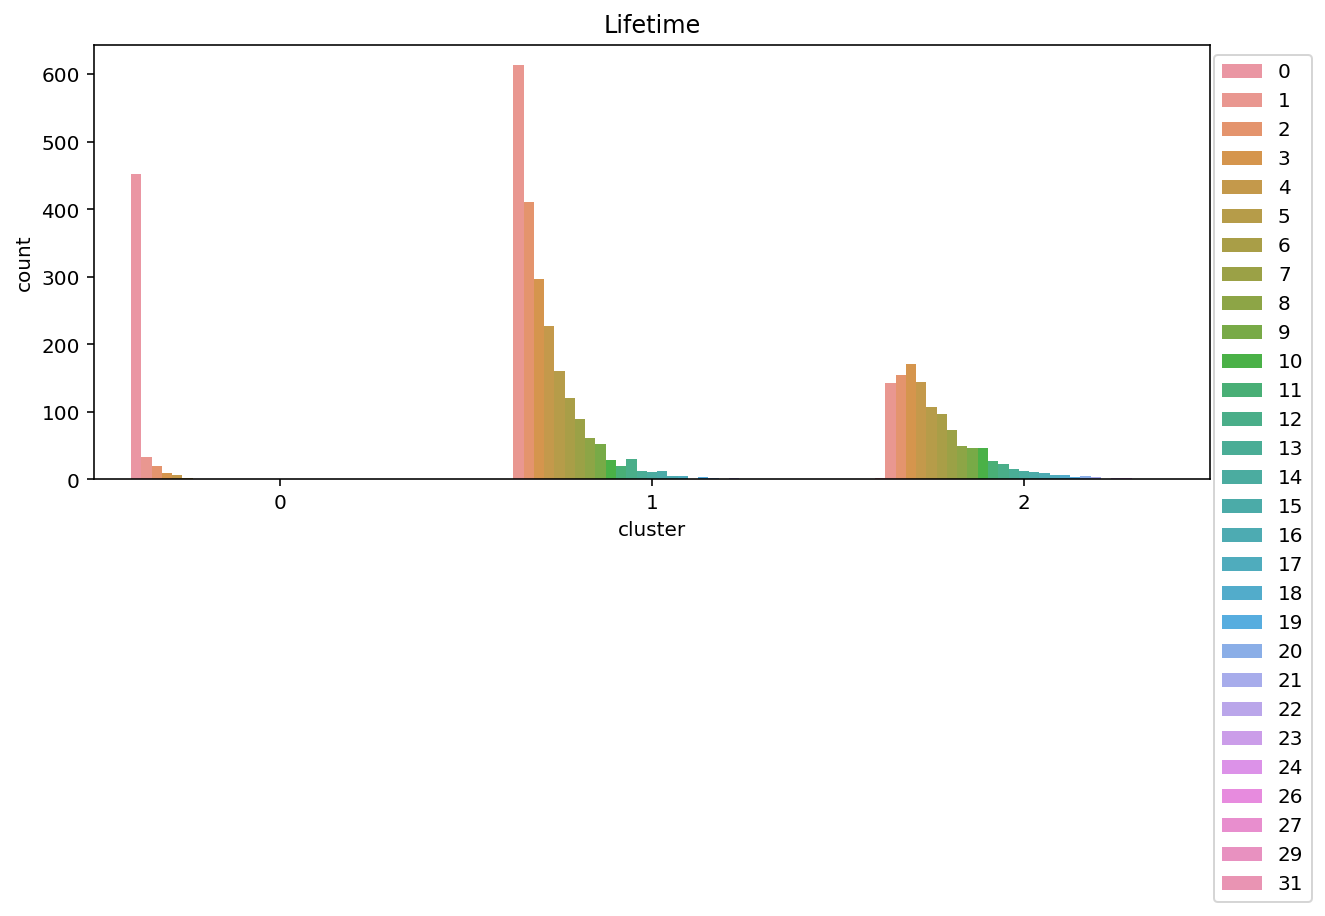

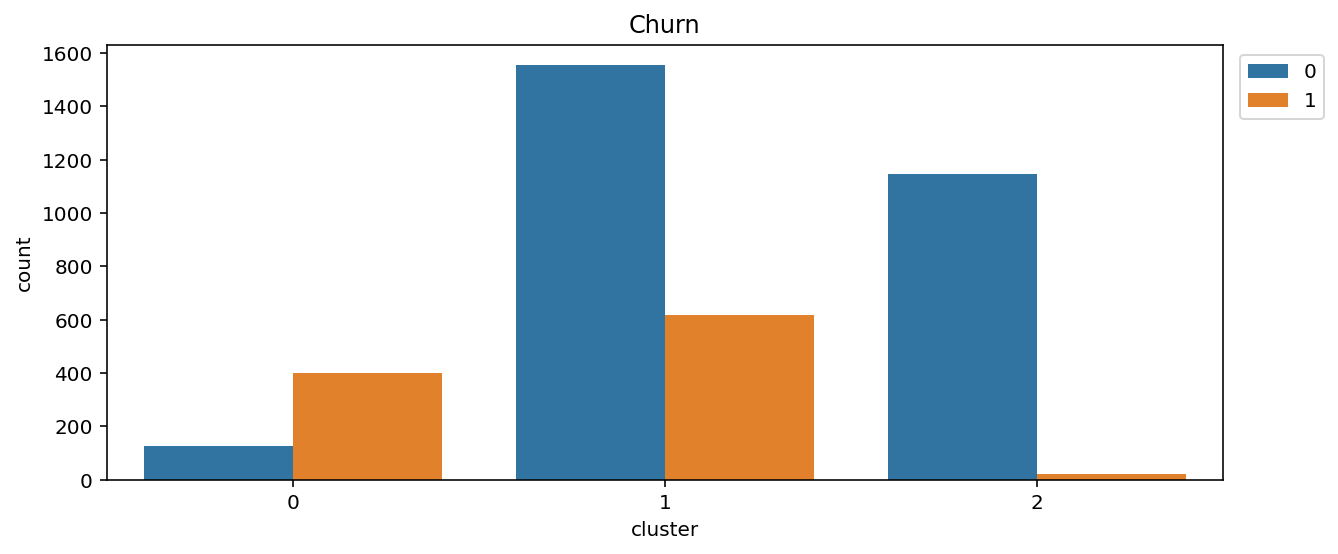

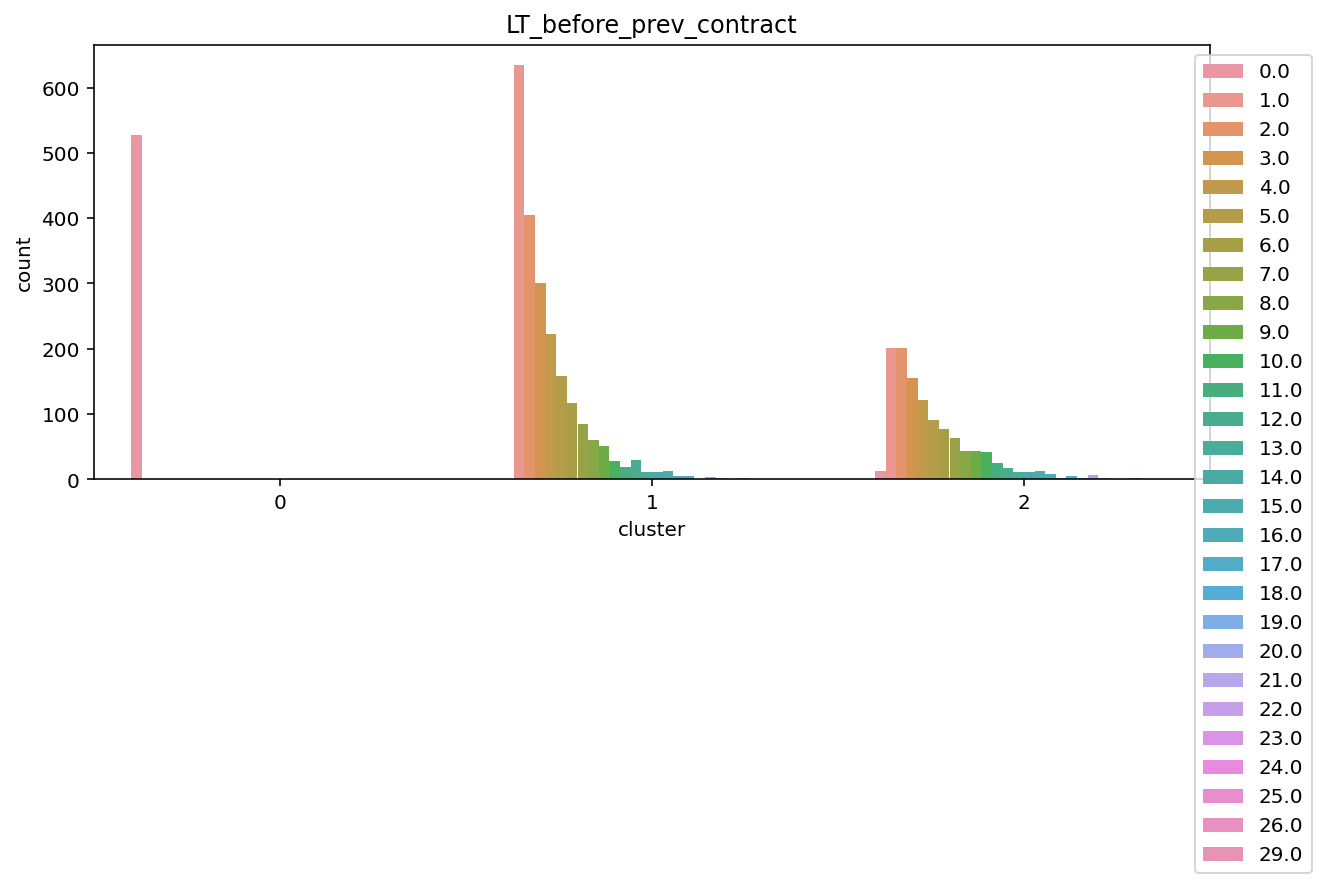

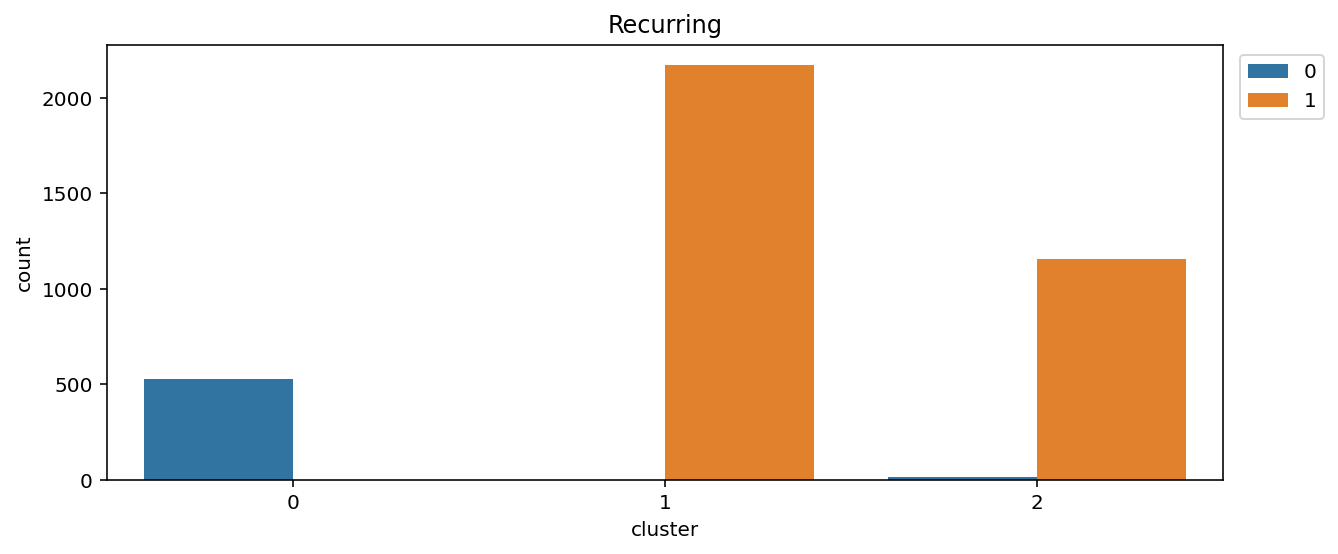

In [93]:
for column in ['Near_Location', 'Partner', 'Promo_friends', 'Contract_period',
       'Month_to_end_contract', 'Lifetime',
       'Churn', 'LT_before_prev_contract',
       'Recurring']:
    plt.figure(figsize=(10,4)) 
    plt.title(column)   
    sns.countplot(data = data_k, x = 'cluster', hue = column )
    plt.legend(bbox_to_anchor=(1.1, 1));

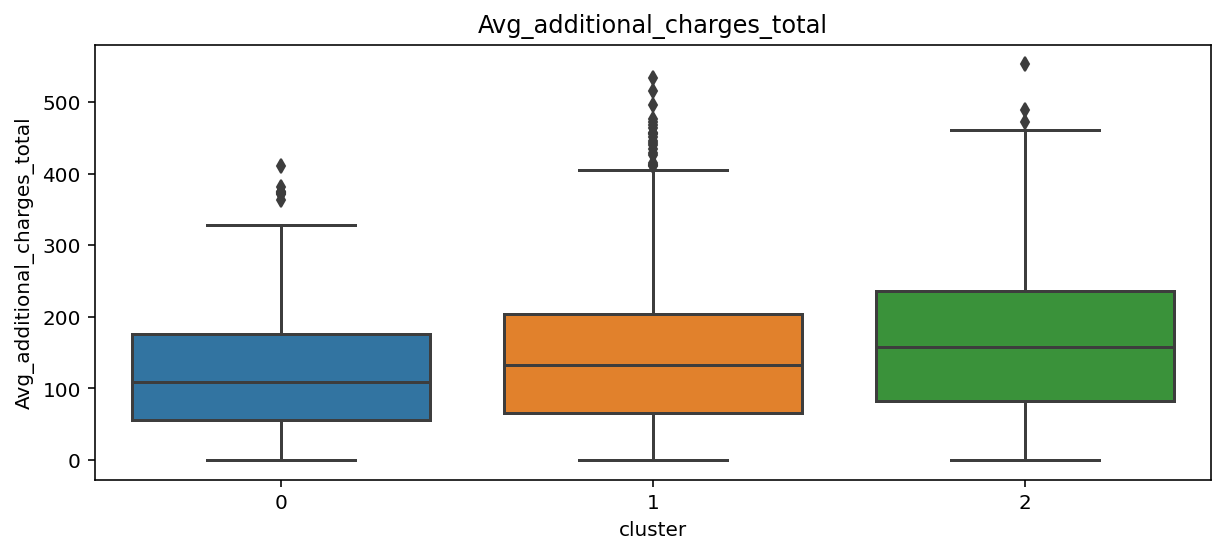

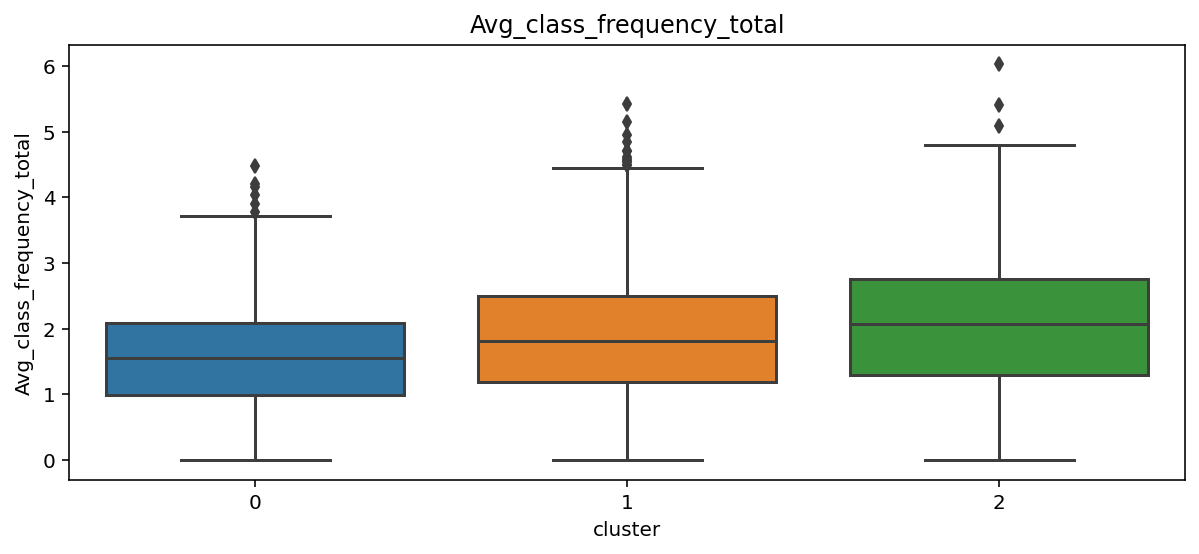

In [96]:
for column in ['Avg_additional_charges_total', 'Avg_class_frequency_total']:
    plt.figure(figsize=(10,4)) 
    plt.title(column)   
    sns.boxplot(x ='cluster',y = column, data = data_k)
    ;

Посчитаем корреляции для кластера с большим оттоком:

In [53]:
i = top_clusters.index[0]
    
print ('кластер ', i , top_clusters.loc[i])
display (
 pd.DataFrame(data_k.query('cluster == @i').corr()['Churn']
      .drop(['Churn', 'cluster'])
      .sort_values())
      .style.background_gradient(cmap='PiYG', vmin=-1, vmax=1)
)

кластер  0 Churn  mean       0.759013
       count    527.000000
Name: 0, dtype: float64


#### Вывод по кластеризации: 

Основной признак - это производная метрика "повторный клиент", основанная на длительности контракта, сроке окончания контракта и лайфтайме. Как мы выяснили раньше, по этим метрикам есть существенные вопросы и было бы некорректно давать рекомендации на основе моделей, базирующихся на этих метриках.

## ВЫВОДЫ:

<div class="alert alert-block alert-info">

Если предположить, что данные верны и все клиенты в наборе уникальны, то можно сделать такие наблюдения:
    
- клуб существует больше 2,5 лет (судя по максимальному лайфтайму)
- существует устойчивая клиентская база, 86% клиентов повторные
- динамика количества посещений клуба клиентами с разным лайфтаймом довольно стабильна
- при этом 57% контрактов - на 1 месяц
- было бы логично предположить, что контракты на 1 месяц - это пробные, промо контракты. Тем не менее, 47% от всех контрактов - это контракты длиной в 1 месяц, заключенные с повторными клиентами
- возможно короткие контракты НЕ способствуют привлечению новых клиентов. Прогноз, полученный с помощью машинного обучения предсказывает, что новые клиенты, заключившие короткие контракты, не останутся в клубе. Это предварительный вывод, который необходимо проверить на дополненном наборе данных. 
    
**Рекомендации:** 

1. Проанализировать систему мотивации менеджеров по продажам. Возможно, результаты работы оцениваются по количеству заключенных контрактов и это может объяснить такое количество коротких контрактов. Если это не оптимальный для бизнеса результат, то систему мотивации может быть полезно пересмотреть.

2. Добавить в набор данных ID клиента и дату заключения контракта и провести повторный анализ данных.

</div>